In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [2]:
%pip install umap-learn

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE #TSNE is t-stochastic neighbor embeddings
from umap.umap_ import UMAP
from mpl_toolkits.mplot3d import axes3d

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Sprint 1 - Strategic Store Expansion Using Household Debt Insights

In this project, we aim to uncover insights into the relationship between household debt to income ratio and the strategic decisions of store openings by Target.  While we don't have access to the performance data of existing stores, we can use economic information to identify regions with high potential for new store success. By analyzing household debt characteristics, we can recommend prime locations for Target's expansion.

Our key question is: Where should I open the next Target?

We will be using two datasets for this project:

1.   targets.csv - This dataset includes a record for Target locations currently in operation as of April 2017
2.   debt_county.csv - This dataset includes a record of the household debt to income ration since 1999
3.    pop_age_sex.csv - This dataset includes a record of population by age and sex per county
4.    race_data.csv - This dataset includes a record of race per county

Let's begin the cleaning process for target.csv

### Data Inspection

In [6]:
raw_target_data = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/target.csv', encoding='latin1')
raw_target_data.head()

X.locale      Address.AddressLine1 Address.AddressLine2 Address.City  \
0    en-US  400 Oxford Exchange Blvd                  NaN       Oxford   
1    en-US        2640 Enterprise Dr                  NaN      Opelika   
2    en-US            1129 S Park St                  NaN   Carrollton   
3    en-US          555 Bullsboro Dr                  NaN       Newnan   
4    en-US      1591 Bradley Park Dr                  NaN     Columbus   

  Address.CountryName Address.County  \
0       United States        Calhoun   
1       United States            Lee   
2       United States        Carroll   
3       United States         Coweta   
4       United States       Muscogee   

                          Address.FormattedAddress  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459   
1       2640 Enterprise Dr, Opelika, AL 36801-1511   
2        1129 S Park St, Carrollton, GA 30117-4429   
3          555 Bullsboro Dr, Newnan, GA 30265-1045   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071   

  Address.IntersectionDescription  Address.Latitude  Address.Longitude  \
0      SEC I-20 & Golden Creek Rd         33.608825         -85.783182   
1              NWC I-85 & Hwy 280         32.618108         -85.410636   
2      NWC US 27 & Hwy 166 Bypass         33.558920         -85.076473   
3               SWC I-85 & Rte 34         33.392907         -84.758875   
4  NEC Bradley Pk & JR Allen Pkwy         32.534649         -84.971073   

  Address.PostalCode Address.Subdivision AlternateIdentifier.ID    ID  \
0         36203-3459                  AL                  T2153  2153   
1         36801-1511                  AL                  T1499  1499   
2         30117-4429                  GA                  T1073  1073   
3         30265-1045                  GA                  T1223  1223   
4         31904-3071                  GA                  T1179  1179   

   IsDaylightSavingsTimeRecognized LocationMilestones.LastRemodelDate  \
0                             True                                NaN   
1                             True                                NaN   
2                             True                                NaN   
3                             True                2013-06-27T12:00:00   
4                             True                2004-10-17T12:00:00   

  LocationMilestones.OpenDate Market        Name OperatingHours..timeFormat  \
0         2006-07-19T12:00:00    ESE      Oxford                    12-hour   
1         2005-07-20T12:00:00    ESE     Opelika                    12-hour   
2         1997-07-23T12:00:00    ESE  Carrollton                    12-hour   
3         1999-10-06T12:00:00    ESE      Newnan                    12-hour   
4         1999-03-03T12:00:00    ESE    Columbus                    12-hour   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TimeZone.TimeZoneCode TimeZone.TimeZoneDescription  \
0                NaN                   CST             Central Std Time   
1                NaN                   CST             Central Std Time   
2                NaN                   EST             Eastern Std Time   
3                NaN                   EST             Eastern Std Time   
4                NaN                   EST             Eastern Std Time   

  TimeZone.TimeZoneOffset.OffsetCode  TimeZone.TimeZoneOffset.OffsetHours  \
0                                UTC                                   -6   
1                                UTC                                   -6   
2                                UTC                                   -5   
3                  

Here we can see the first 5 rows in our dataset and understand the formats of each column. In this dataset, there are 47 features that we need to examine to determine their relevance to our analysis.

In [7]:
raw_target_data.shape

(1829, 47)

Here we see that there are 1829 rows/stores. Let's check for duplicate values to ensure every row is unique.

In [8]:
raw_target_data.duplicated().sum()

0

We see that there are no duplicated, but to be sure let's ensure there are the same number of unique values as there are rows. This ensures there are no duplicate stores even if the row is not completely the same


In [9]:
raw_target_data.duplicated(subset=['Address.AddressLine1']).sum()

0

Here we see again that there are no duplicates in terms of addresses.

Let's now assess which columns are impactful to our analysis of answering our key question: How can household debt data, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?

First let's take a look at all of the columns.

In [10]:
raw_target_data.columns

Index(['X.locale', 'Address.AddressLine1', 'Address.AddressLine2',
       'Address.City', 'Address.CountryName', 'Address.County',
       'Address.FormattedAddress', 'Address.IntersectionDescription',
       'Address.Latitude', 'Address.Longitude', 'Address.PostalCode',
       'Address.Subdivision', 'AlternateIdentifier.ID', 'ID',
       'IsDaylightSavingsTimeRecognized', 'LocationMilestones.LastRemodelDate',
       'LocationMilestones.OpenDate', 'Market', 'Name',
       'OperatingHours..timeFormat', 'Store.StoreDistrictID',
       'Store.StoreGroupID', 'Store.StoreRegionID', 'SubTypeDescription',
       'TimeZone.TimeZoneCode', 'TimeZone.TimeZoneDescription',
       'TimeZone.TimeZoneOffset.OffsetCode',
       'TimeZone.TimeZoneOffset.OffsetHours', 'TypeCode', 'PhoneNumber',
       'FaxNumber', 'BeginTime.MF', 'Is24Hours.MF', 'IsOpen.MF', 'Summary.MF',
       'ThruTime.MF', 'BeginTime.Sat', 'Is24Hours.Sat', 'IsOpen.Sat',
       'Summary.Sat', 'ThruTime.Sat', 'BeginTime.Sun', 'Is24Hour

We see here many fields having to do with store open times. I will keep these variables in mind however at this time they are not relevant to our analysis so they will be dropped. I will explore remaining data later on in the notebook.

Irrelevant time fields will now be dropped.

In [11]:
# List of columns to drop
columns_to_drop = [
    'BeginTime.MF', 'Is24Hours.MF', 'IsOpen.MF', 'Summary.MF',
    'ThruTime.MF', 'BeginTime.Sat', 'Is24Hours.Sat', 'IsOpen.Sat',
    'Summary.Sat', 'ThruTime.Sat', 'BeginTime.Sun', 'Is24Hours.Sun',
    'IsOpen.Sun', 'Summary.Sun', 'ThruTime.Sun',
    'TimeZone.TimeZoneCode', 'TimeZone.TimeZoneDescription',
    'TimeZone.TimeZoneOffset.OffsetCode', 'OperatingHours..timeFormat',
    'TimeZone.TimeZoneOffset.OffsetHours'
]

# Drop the columns
raw_target_data_drop = raw_target_data.drop(columns=columns_to_drop)

#check for relevant columns
raw_target_data_drop.columns

Index(['X.locale', 'Address.AddressLine1', 'Address.AddressLine2',
       'Address.City', 'Address.CountryName', 'Address.County',
       'Address.FormattedAddress', 'Address.IntersectionDescription',
       'Address.Latitude', 'Address.Longitude', 'Address.PostalCode',
       'Address.Subdivision', 'AlternateIdentifier.ID', 'ID',
       'IsDaylightSavingsTimeRecognized', 'LocationMilestones.LastRemodelDate',
       'LocationMilestones.OpenDate', 'Market', 'Name',
       'Store.StoreDistrictID', 'Store.StoreGroupID', 'Store.StoreRegionID',
       'SubTypeDescription', 'TypeCode', 'PhoneNumber', 'FaxNumber',
       'AllCapability'],
      dtype='object')

Now that we've removed all irrelevant store operating hours columns we can begin to explore if the remaining columns are relevant and how relevant they are to our analysis. Off the bat features such as phone number, fax number, 'is day light savings recognized" are irrelevant so we will drop those.

In [12]:
# List of columns to drop
columns_to_drop2 = ['PhoneNumber', 'FaxNumber', 'IsDaylightSavingsTimeRecognized',
                    'Address.IntersectionDescription','Address.CountryName','AlternateIdentifier.ID','ID']

# Drop the columns
raw_target_data_drop.drop(columns=columns_to_drop2, inplace=True)

In [13]:


#Check Columns
raw_target_data_drop.columns


Index(['X.locale', 'Address.AddressLine1', 'Address.AddressLine2',
       'Address.City', 'Address.County', 'Address.FormattedAddress',
       'Address.Latitude', 'Address.Longitude', 'Address.PostalCode',
       'Address.Subdivision', 'LocationMilestones.LastRemodelDate',
       'LocationMilestones.OpenDate', 'Market', 'Name',
       'Store.StoreDistrictID', 'Store.StoreGroupID', 'Store.StoreRegionID',
       'SubTypeDescription', 'TypeCode', 'AllCapability'],
      dtype='object')

Now we have 24 columns left. We will now explore each column to understand if it's relevant to our analysis and how relevant it is to answering our question: How can household debt data, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?

### Column Cleaning

Let's analyze the number of null values in our datset

In [14]:
raw_target_data_drop.isnull().sum()

X.locale                                 0
Address.AddressLine1                     0
Address.AddressLine2                  1771
Address.City                             0
Address.County                           1
Address.FormattedAddress                 0
Address.Latitude                         0
Address.Longitude                        0
Address.PostalCode                       0
Address.Subdivision                      0
LocationMilestones.LastRemodelDate     395
LocationMilestones.OpenDate              0
Market                                  91
Name                                     0
Store.StoreDistrictID                    0
Store.StoreGroupID                       0
Store.StoreRegionID                      0
SubTypeDescription                    1522
TypeCode                                 0
AllCapability                           12
dtype: int64

In [15]:
raw_target_data['Name']

0                 Oxford
1                Opelika
2             Carrollton
3                 Newnan
4               Columbus
              ...       
1824           Stone Oak
1825       New Braunfels
1826          San Marcos
1827                Kyle
1828    Austin Southpark
Name: Name, Length: 1829, dtype: object

We've identified null values in several columns, including 'Address.AddressLine2' (1771 nulls), 'SubTypeDescription' (1522 nulls), 'LocationMilestones.LastRemodelDate' (395 nulls), 'Capabilities' (12 nulls), and 'Market' (91 nulls). These nulls may reflect non-remodeled locations or a lack of additional capabilities. Further analysis is needed to determine the most appropriate handling of these null values.

Let's start with Address Line 2

In [16]:
#explore address.line2
raw_target_data_drop['Address.AddressLine2'].unique()

array([nan, 'Ste 4000', 'Ste B', 'Ste 400', 'Ste 7', 'Ste 300', 'Ste 600',
       'Ste A', 'Ste 80', 'Ste 200', 'Ste 100', 'Ste 90', 'Ste F',
       'Ste 2400', 'Ste H', 'Ste 120', 'Ste 1', 'Ste 700', 'Ste 2250',
       'Ste Target', '#50', 'Ste F600', 'Suite 201', 'Ste 140', 'Ste 5',
       'Ste 121', 'Ste 110', 'Ste 1S', 'Ste 1900', 'Ste 49', 'STE 1',
       'Ste 201', 'Ste 500', 'Ste 101', 'Ste 102', 'Ste 2', 'Ste 42',
       'Bldg A100', 'Ste 1A', 'PO Box 5124', 'Ste. 100', 'Ste 125',
       'Ste G'], dtype=object)

Here we see the Adress Line 2 data. It's mostly unit numbers which are not very relevant to our analysis since we have the main address in another field. We can drop this column from the data.

In [17]:
#drop AddressLine2
raw_target_data_drop1 = raw_target_data_drop.drop('Address.AddressLine2', axis=1)

#check drop
raw_target_data_drop1.columns

Index(['X.locale', 'Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Market', 'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode',
       'AllCapability'],
      dtype='object')

Now we can explore the subtype description field

In [18]:
#explore subtype description

raw_target_data_drop1['SubTypeDescription'].unique()

array([nan, 'SuperTarget', 'TargetExpress', 'City'], dtype=object)

This columns' information might actually be interesting to analyze, it describes the type of Target that has been opened - 'SuperTarget', 'TargetExpress', or'City'. I can deal with the Nan values by webscraping or can assume that they are regular targets. For now I will assume that they are regular targets and map all nan values to 'Regular'

In [19]:
#replace all null values with 'Regular'
raw_target_data_drop1['SubTypeDescription'].fillna('Regular',inplace = True)


In [20]:
#check for no null values
raw_target_data_drop1['SubTypeDescription'].isnull().sum()

0

In [21]:
#check for unique values
raw_target_data_drop1['SubTypeDescription'].unique()

array(['Regular', 'SuperTarget', 'TargetExpress', 'City'], dtype=object)

We now see that there are no nulls in the SubTypeDescription column and all NaN have been replaced with 'Regular'

Now it's time to explore the X.locale column

In [22]:
#explore X.Locale
raw_target_data_drop1['X.locale'].unique()

array(['en-US'], dtype=object)

This column only contains 'en-US' meaning all locations are the same we can drop this column as it is redundant.

In [23]:
#drop x.locale
raw_target_data_drop2 = raw_target_data_drop1.drop('X.locale', axis=1)

#check drop
raw_target_data_drop2.columns

Index(['Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Market', 'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode',
       'AllCapability'],
      dtype='object')

Now let's clean the LastRemodeled field. This field is important for analysis because I'd like to see if remodeling occurred because it can be a sign of Target re-investing which could indicate a successful store since we don't have sales/performance data.

In [24]:
#explore last remodeled field
raw_target_data_drop2['LocationMilestones.LastRemodelDate'].isna().sum()

395

We see that there are 395 nulls to handle. Because this field's nulls could mean that the Target wasnt remodeled we will create a new field with a binary indicator. Set it to 1 if 'LocationMilestones.LastRemodelDate' is not null and 0 otherwise.

In [25]:

# Create a binary indicator column
raw_target_data_drop2['Remodeled'] = pd.notna(raw_target_data['LocationMilestones.LastRemodelDate']).astype(int)

#check new column
raw_target_data_drop2[['LocationMilestones.LastRemodelDate','Remodeled']]


LocationMilestones.LastRemodelDate  Remodeled
0                                   NaN          0
1                                   NaN          0
2                                   NaN          0
3                   2013-06-27T12:00:00          1
4                   2004-10-17T12:00:00          1
...                                 ...        ...
1824                                NaN          0
1825                2013-06-27T12:00:00          1
1826                2009-03-04T12:00:00          1
1827                                NaN          0
1828                2007-10-10T12:00:00          1

[1829 rows x 2 columns]

In [26]:
raw_target_data_drop2.shape

(1829, 19)

We can now see the Remodeled column ther 0's where there are NaNs and 1's where there are dates.



Let's convert the open date and last remodeled date column to pandas datetime in order to be able to use it for analysis later.

In [27]:
# Convert the columns to datetime format
raw_target_data_drop2['LocationMilestones.OpenDate'] = pd.to_datetime(raw_target_data_drop2['LocationMilestones.OpenDate'])
raw_target_data_drop2['LocationMilestones.LastRemodelDate'] = pd.to_datetime(raw_target_data_drop2['LocationMilestones.LastRemodelDate'])


In [28]:
raw_target_data_drop2[['LocationMilestones.OpenDate','LocationMilestones.LastRemodelDate']]

LocationMilestones.OpenDate LocationMilestones.LastRemodelDate
0            2006-07-19 12:00:00                                NaT
1            2005-07-20 12:00:00                                NaT
2            1997-07-23 12:00:00                                NaT
3            1999-10-06 12:00:00                2013-06-27 12:00:00
4            1999-03-03 12:00:00                2004-10-17 12:00:00
...                          ...                                ...
1824         2007-07-25 12:00:00                                NaT
1825         2008-07-23 12:00:00                2013-06-27 12:00:00
1826         2009-03-04 12:00:00                2009-03-04 12:00:00
1827         2009-10-07 12:00:00                                NaT
1828         2007-10-10 12:00:00                2007-10-10 12:00:00

[1829 rows x 2 columns]

Now let's explore the Market Column

In [29]:
raw_target_data_drop2['Market'].unique()

array(['ESE', 'ESF', nan, 'SFL', 'BTC', 'RG3', 'RG4', 'RG1', 'EMW', 'RG2',
       'ENE', 'SMA', 'RBO', 'RMI', 'SMN', 'RMP', "['GTM', 'RMP']", 'GTM'],
      dtype=object)

I was unable to find any documentation on what this field means so I will drop it.

In [30]:
raw_target_data_drop2.shape

(1829, 19)

In [31]:
#drop Market column
raw_target_data_drop3 = raw_target_data_drop2.drop('Market', axis = 1)

#check for clean data
raw_target_data_drop3.columns

Index(['Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode',
       'AllCapability', 'Remodeled'],
      dtype='object')

Now let's explore 'All Capability'

In [32]:
raw_target_data_drop3['AllCapability']

0       ['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Star...
1       ['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'...
2                                                     NaN
3       ['CVS pharmacy', 'Café', 'Fresh Grocery', 'Mob...
4       ['CVS pharmacy', 'Café', 'Mobile Kiosk', 'Phot...
                              ...                        
1824    ['Bakery', 'CVS pharmacy', 'Cafe-Pizza', 'Deli...
1825    ['Accepts WIC', 'CVS pharmacy', 'Cafe-Pizza', ...
1826    ['CVS pharmacy', 'Cafe-Pizza', 'Fresh Grocery'...
1827    ['CVS pharmacy', 'Cafe-Pizza', 'Drive Up', 'Fr...
1828    ['Accepts WIC', 'Bakery', 'CVS pharmacy', 'Caf...
Name: AllCapability, Length: 1829, dtype: object

We see that this field contains lists of additional features that a Target has such as a CVS, Cafe, Bakery etc. This could be useful for analysis. In order to process this I will create binary indicators for each unique value. First we need to explore what all of the unique value are

In [33]:


# Replace NaN values with an empty list
raw_target_data_drop3['AllCapability'].fillna('[]', inplace=True)



In [34]:
# Remove unwanted characters from the string and split the values into lists
raw_target_data_drop3['AllCapability'] = raw_target_data_drop3['AllCapability'].str.replace("[\[\]']", '', regex=True)
raw_target_data_drop3['AllCapability'] = raw_target_data_drop3['AllCapability'].str.split(', ')



In [35]:
# Assuming raw_target_data_drop3['AllCapability'] contains lists of capabilities
# Convert each list of capabilities into a string of comma-separated values
raw_target_data_drop3['AllCapability_str'] = raw_target_data_drop3['AllCapability'].apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Now use `str.get_dummies` which works on comma-separated strings to create one-hot encoding
capabilities_dummies = raw_target_data_drop3['AllCapability_str'].str.get_dummies(sep=',')

# Join the one-hot encoded DataFrame with the original DataFrame
raw_target_data_drop3 = raw_target_data_drop3.join(capabilities_dummies)

# You can drop the intermediate 'AllCapability_str' if it's no longer needed
raw_target_data_drop3.drop('AllCapability_str', axis=1, inplace=True)


In [36]:

# Drop the original 'AllCapability' column
raw_target_data_drop3.drop('AllCapability', axis=1, inplace=True)

In [37]:
raw_target_data_drop3.head()

Address.AddressLine1 Address.City Address.County  \
0  400 Oxford Exchange Blvd       Oxford        Calhoun   
1        2640 Enterprise Dr      Opelika            Lee   
2            1129 S Park St   Carrollton        Carroll   
3          555 Bullsboro Dr       Newnan         Coweta   
4      1591 Bradley Park Dr     Columbus       Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2    

In [38]:
raw_target_data_drop3.columns

Index(['Address.AddressLine1', 'Address.City', 'Address.County',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode', 'Remodeled',
       '"DAmico & Sons Italian Kitchen"', '& Spirits Available', 'Accepts WIC',
       'Bakery', 'Beauty Concierge', 'Beer', 'Beer Available', 'CVS pharmacy',
       'Cafe-Pizza', 'Café', 'Chobani Cafe',
       'Clinic care by Kaiser Permanente', 'Deli', 'Drive Up', 'Fresh Grocery',
       'In-Store Apple Store', 'MinuteClinic', 'Mobile Kiosk', 'Optical',
       'Photo Lab', 'Pizza Hut Salads and Snacks', 'Starbucks', 'Sun Boutique',
       'Super Target', 'Which Wich Superior Sandwiches', 'Wine',
       'Wine & Beer Available', 'Wine Available'],
      dtype='object')

We now see each Capability hot-encoded as a binary values

### Statistical Analysis

Let's explore the statistical distribution and possible correlations in this dataset. We'll start with a heat map of all numerical columns.

<ipython-input-39-664b269be1c7>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = raw_target_data_drop3[group].corr()


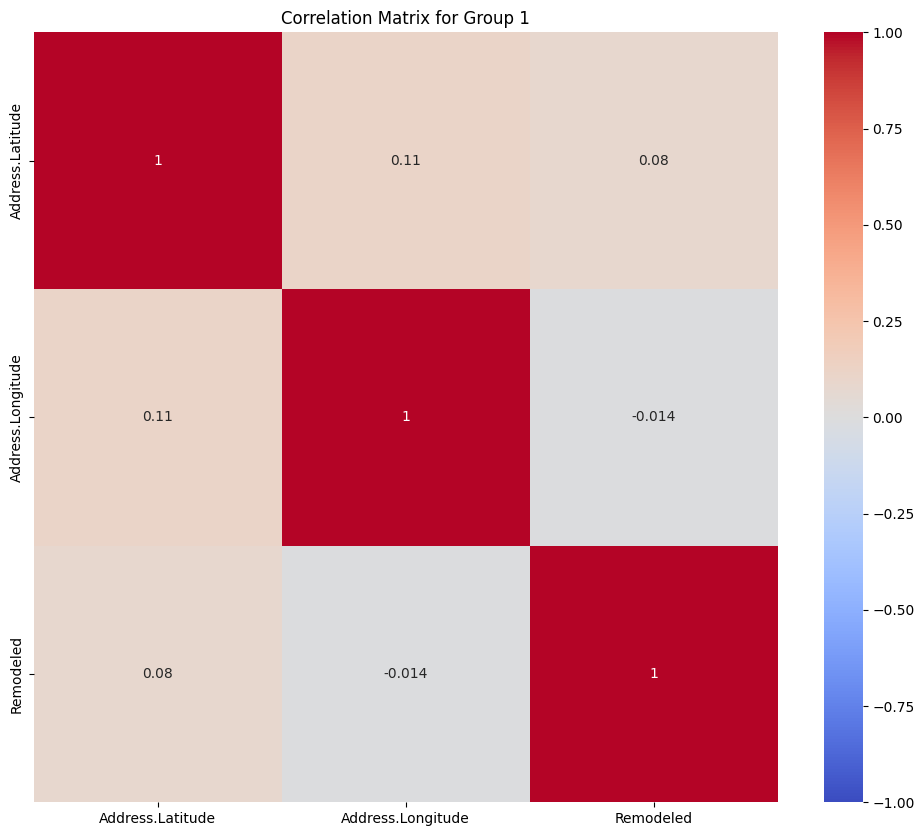

<ipython-input-39-664b269be1c7>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = raw_target_data_drop3[group].corr()


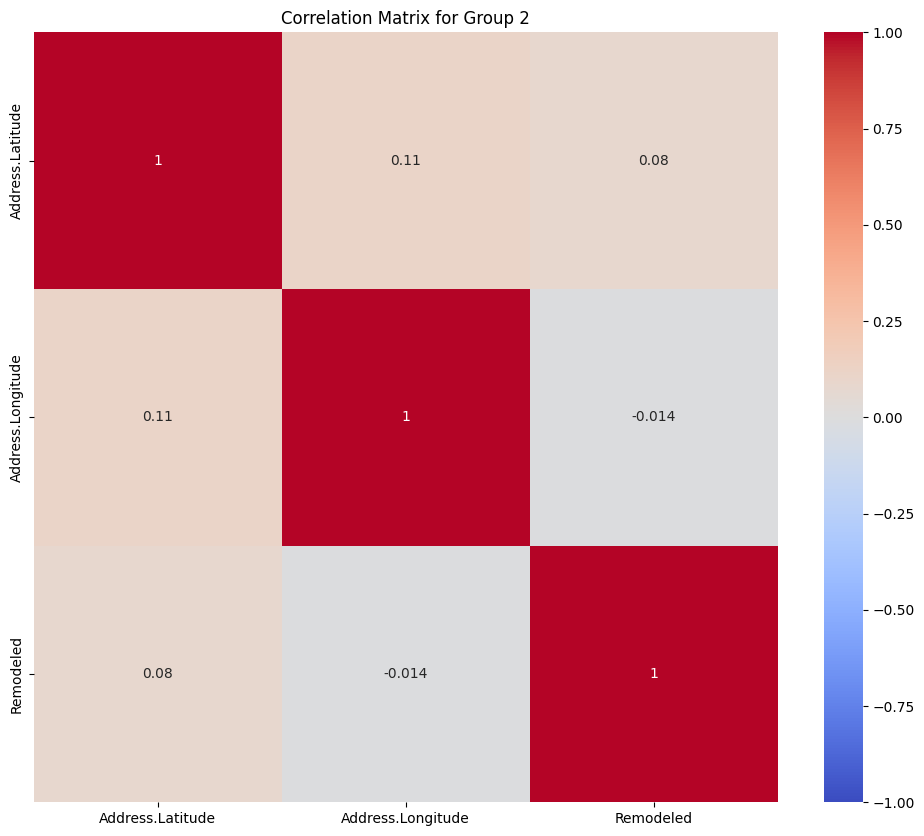

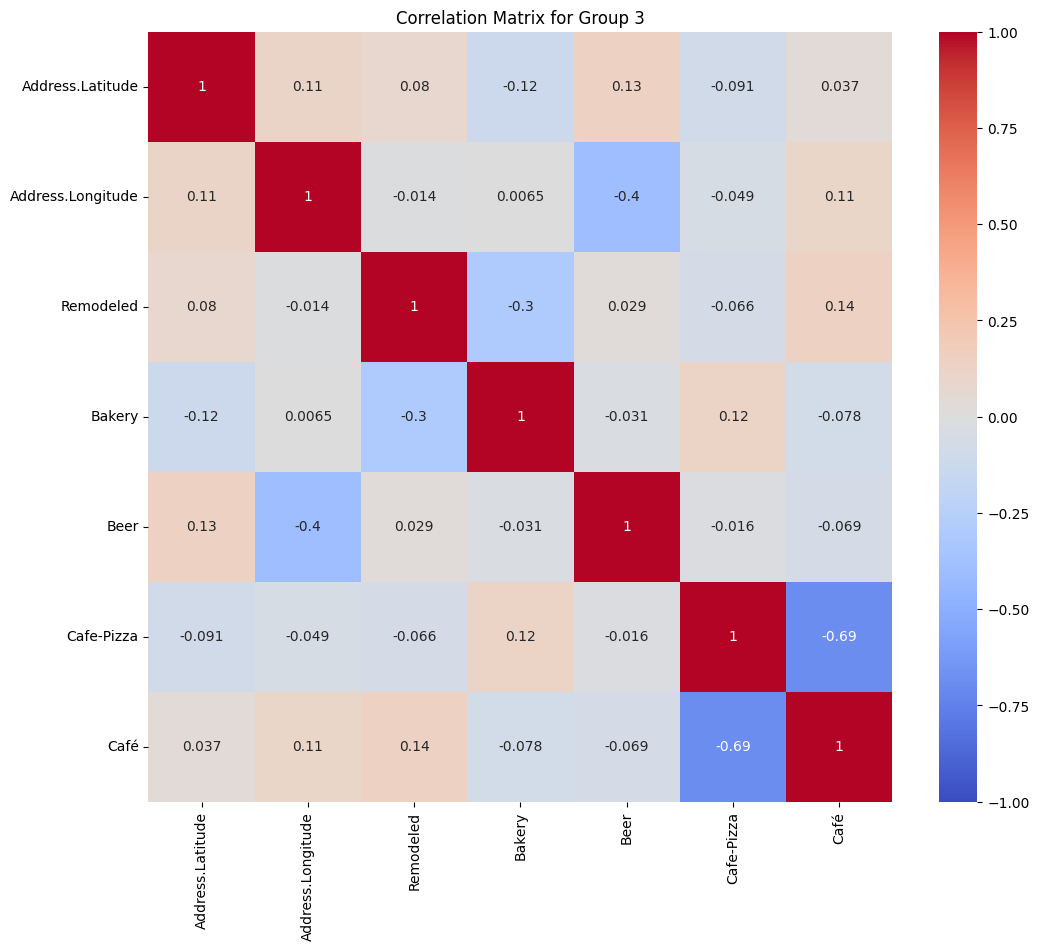

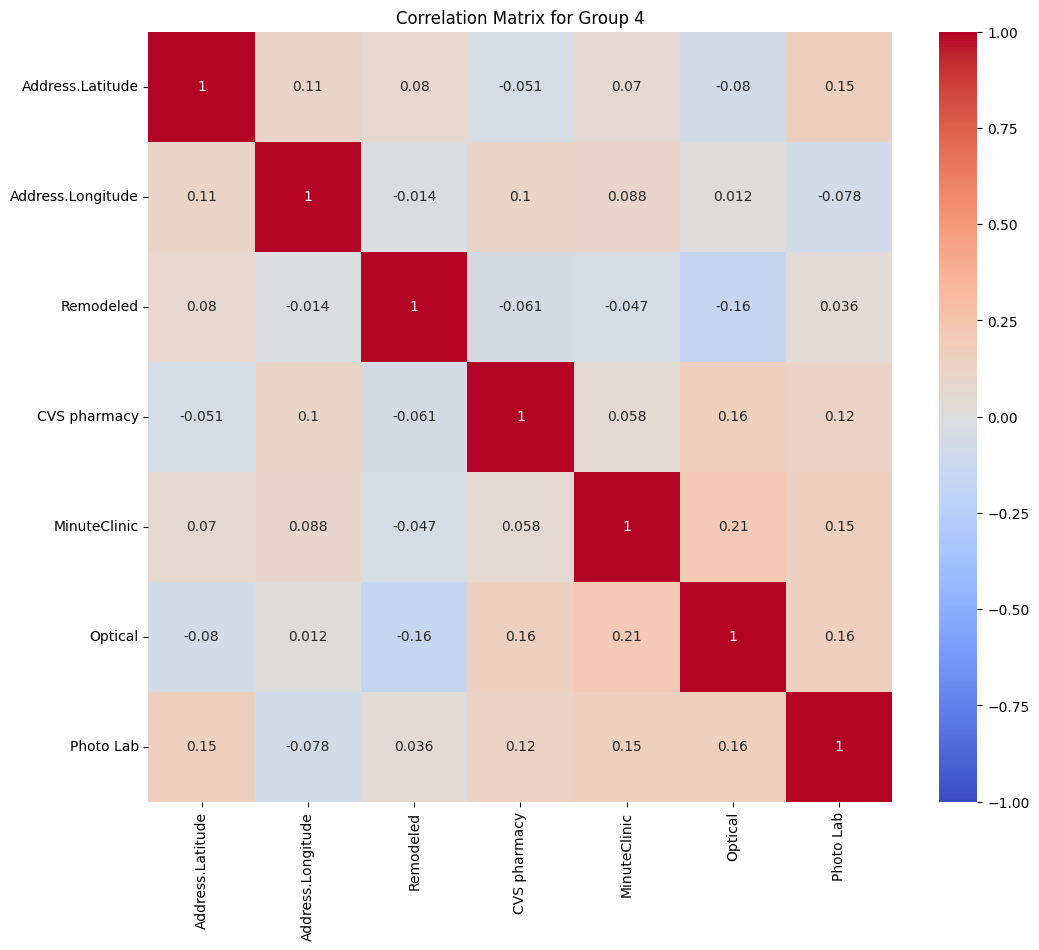

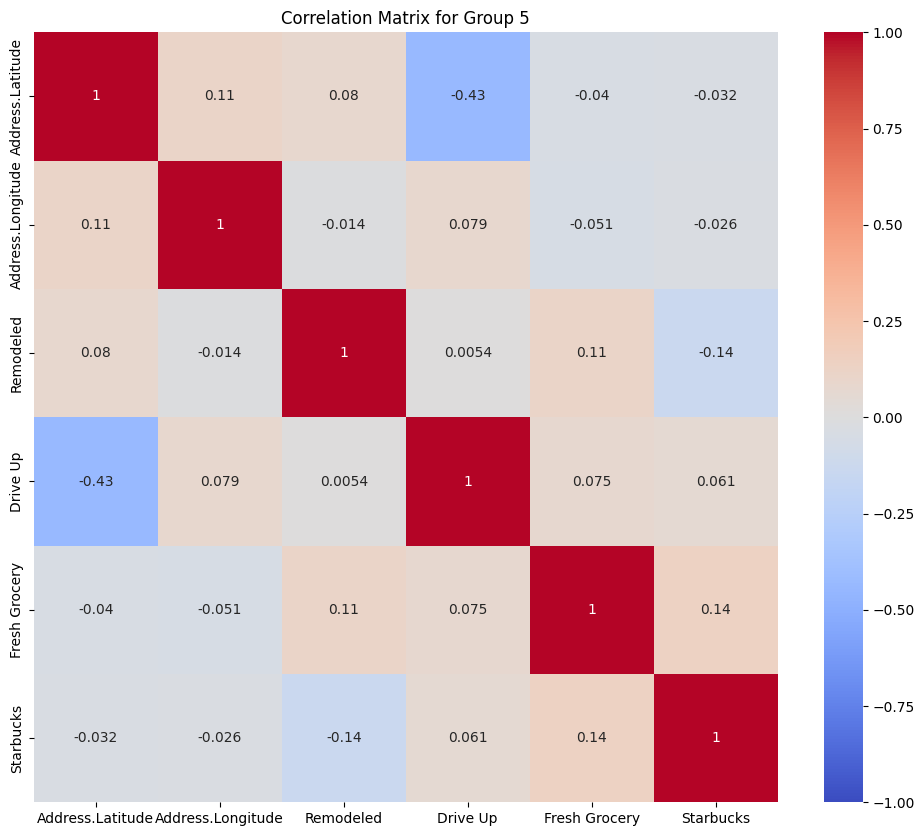

In [39]:
# Define column groups
groups = [
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Address.AddressLine1', 'Address.City', 'Address.County', 'Address.PostalCode'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Name'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Bakery', 'Beer', 'Cafe-Pizza', 'Café'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'CVS pharmacy', 'MinuteClinic', 'Optical', 'Photo Lab'],
    ['Address.Latitude', 'Address.Longitude', 'Remodeled', 'Drive Up', 'Fresh Grocery', 'Starbucks']
]

#Loop through each group to compute and display correlation matrix
for index, group in enumerate(groups, 1):
    correlation_matrix = raw_target_data_drop3[group].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for Group {index}")
    plt.show()


Upon examining the correlation matrix, we observe predominantly weak linear relationships between variables, hinting that they might largely function independently. This independence mitigates concerns about multicollinearity. However, these low correlations don't necessarily indicate an absence of relationships; non-linear interactions might be present but not reflected in the current metrics. While the initial impression suggests some variables might have lesser relevance due to their low correlation with the target, I will approach feature selection with a holistic view by exploring other types of relationships

###Histogram Analysis

Let's now plot histograms for each of the numeric columns

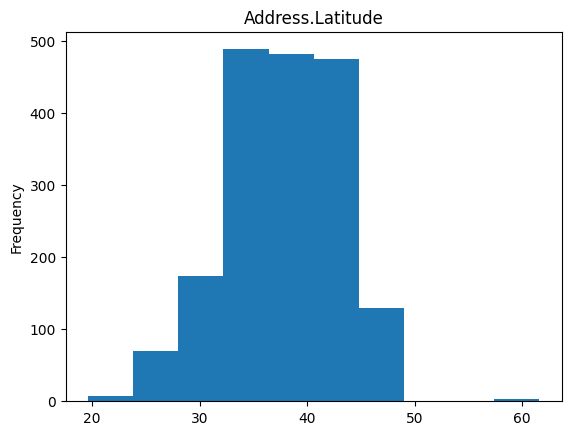

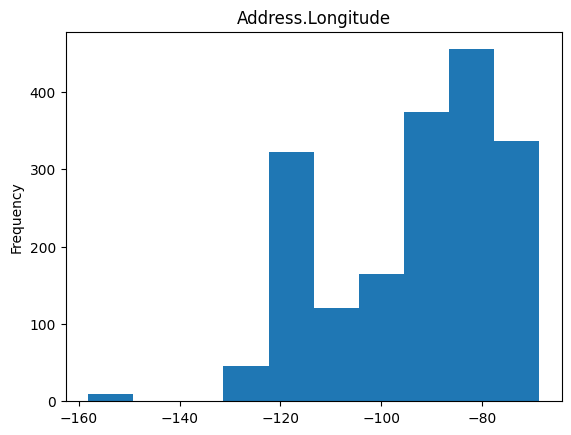

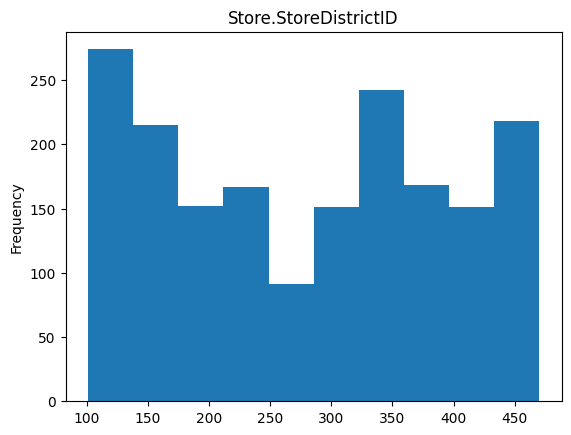

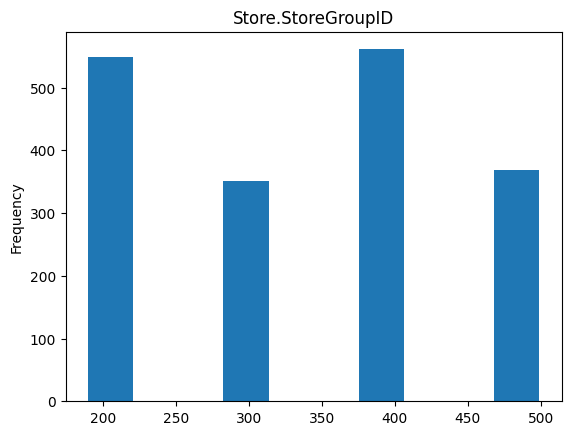

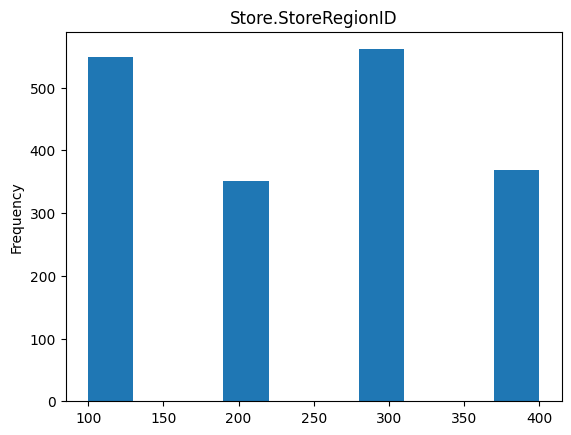

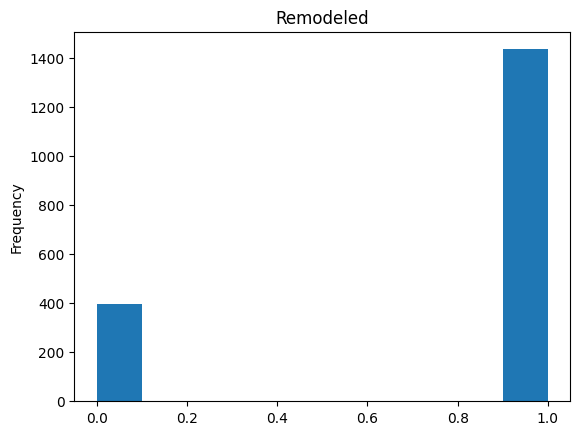

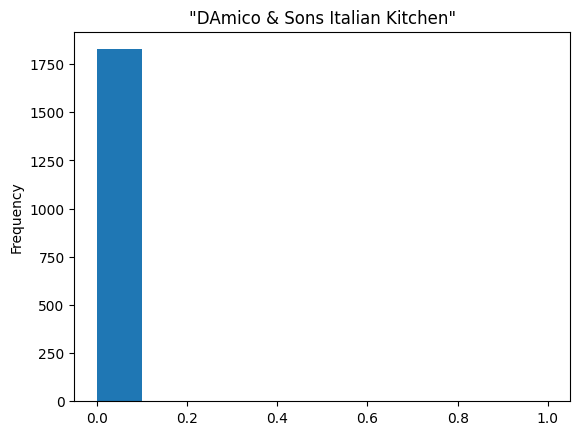

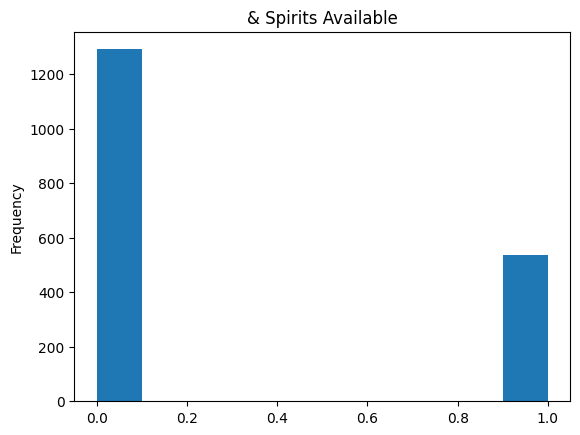

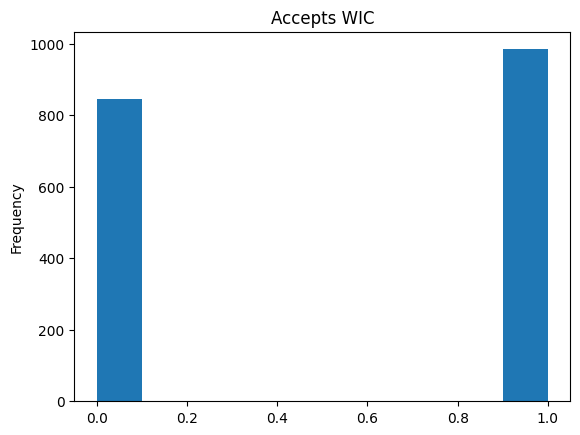

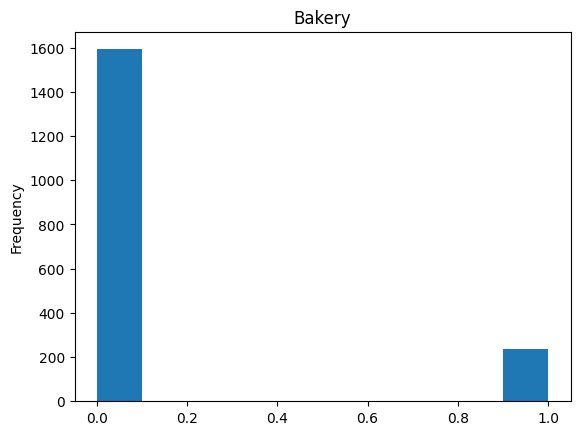

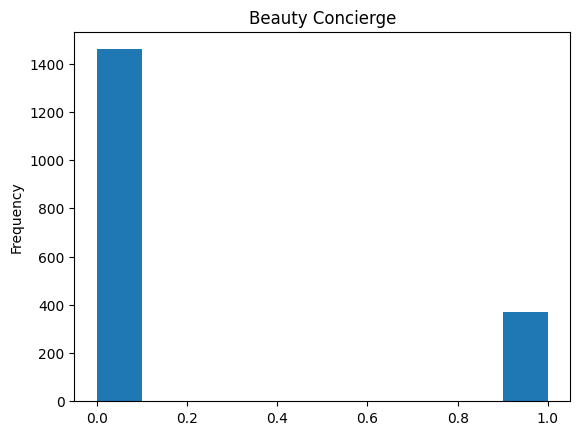

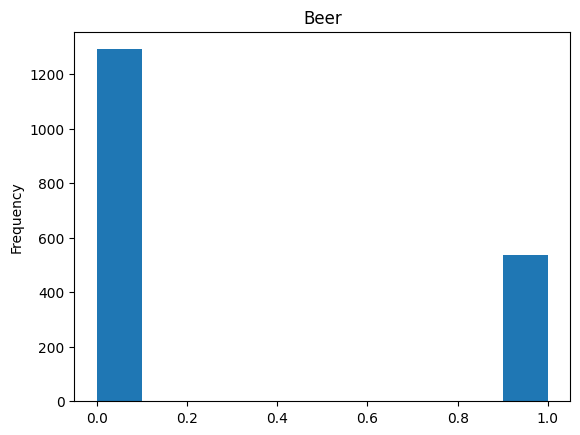

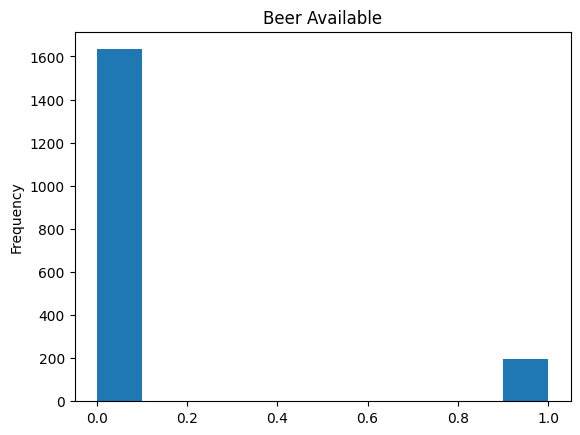

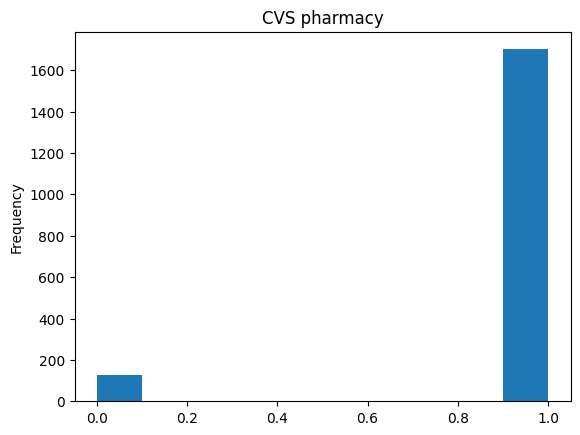

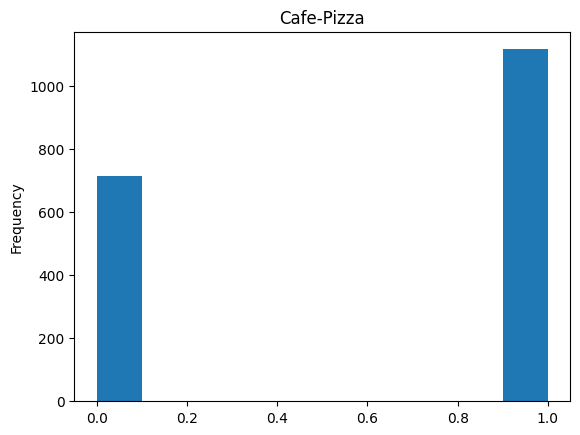

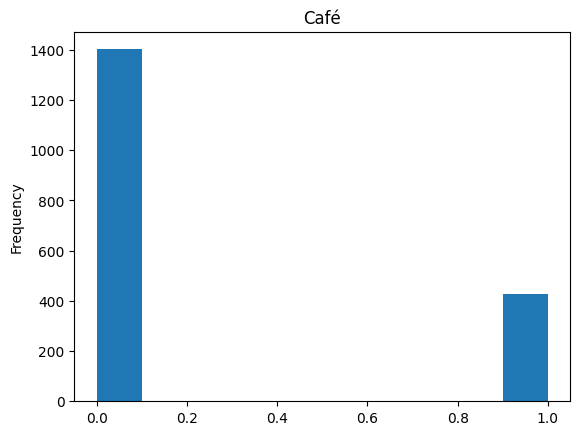

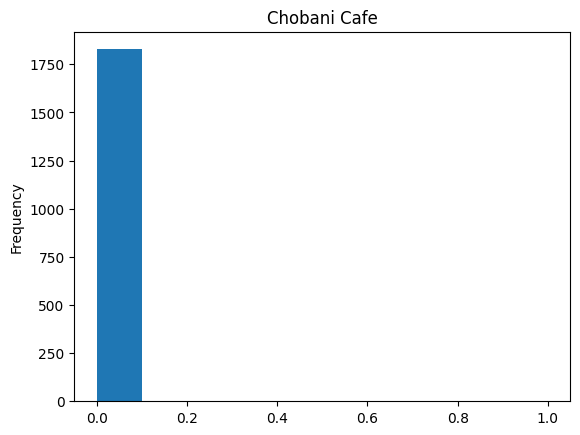

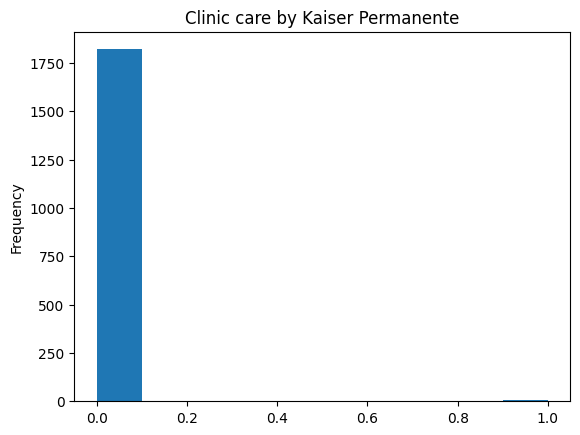

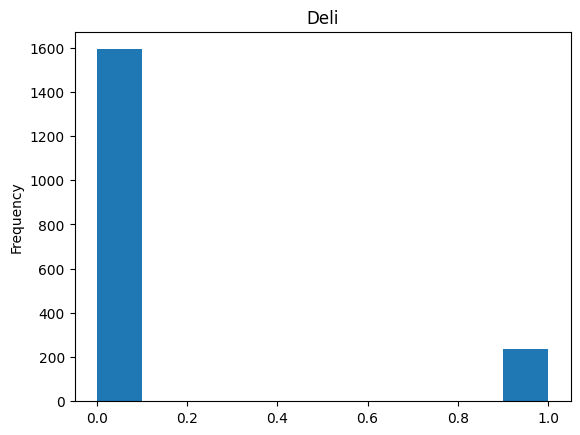

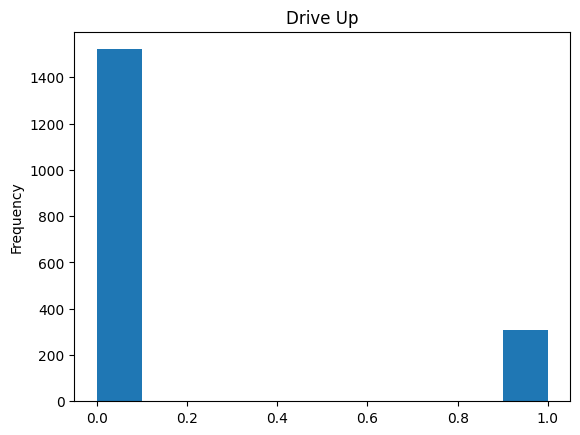

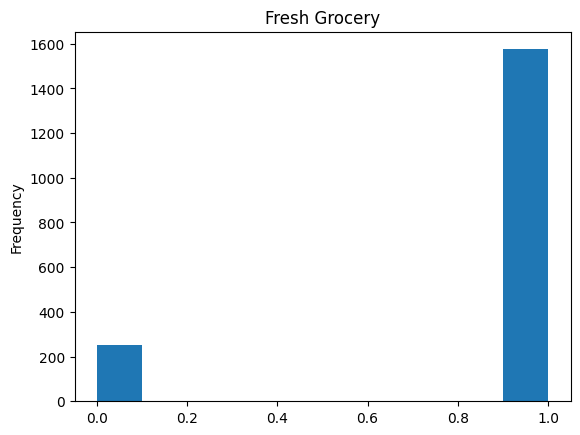

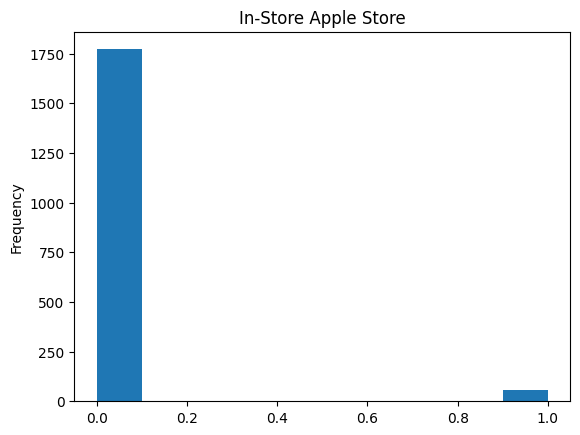

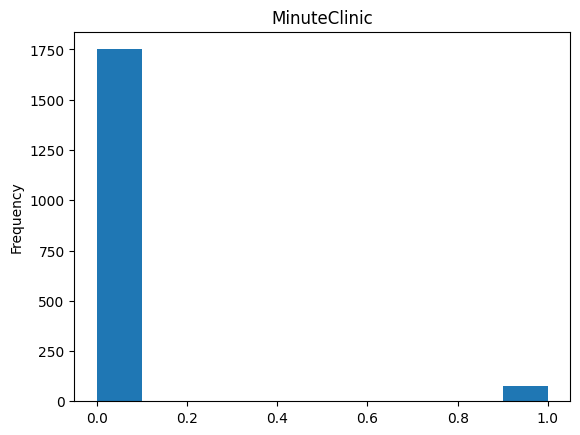

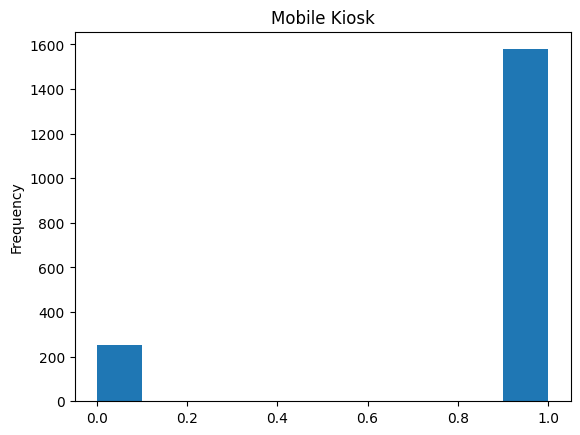

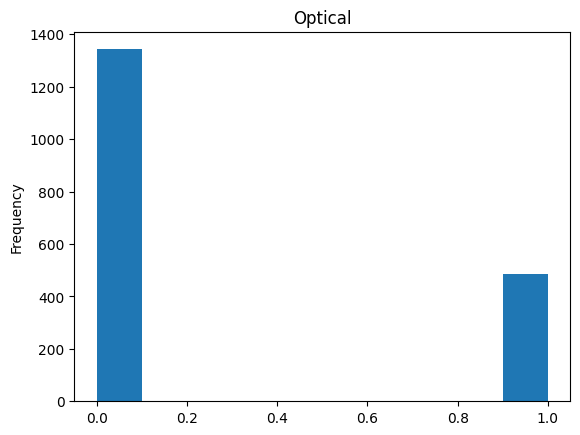

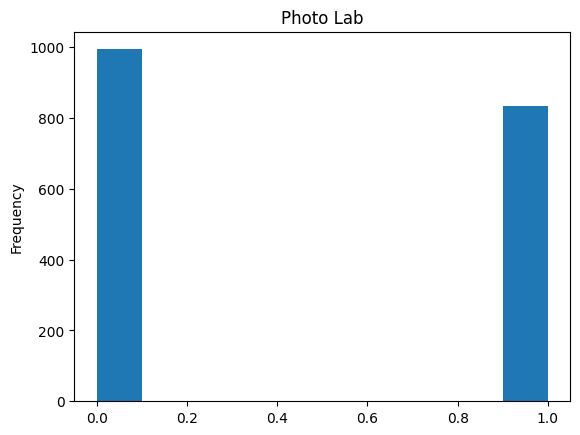

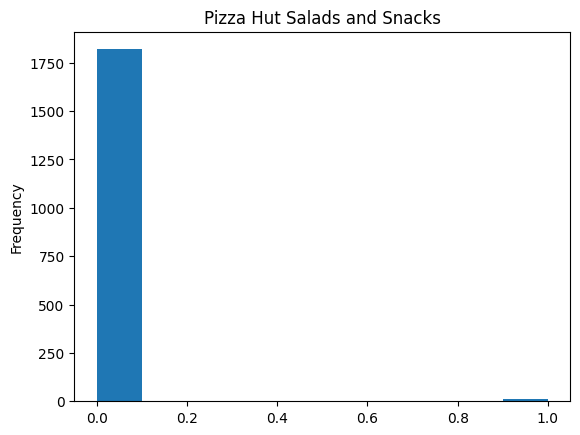

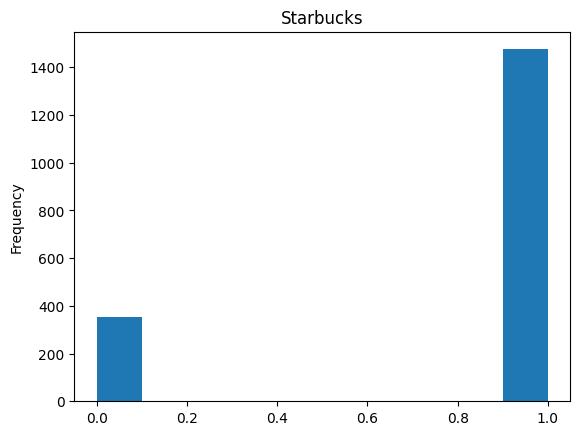

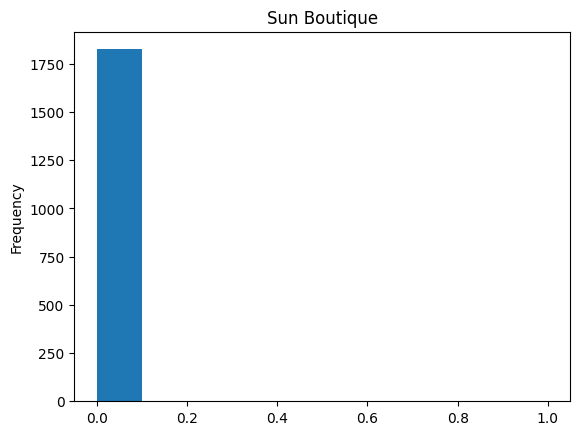

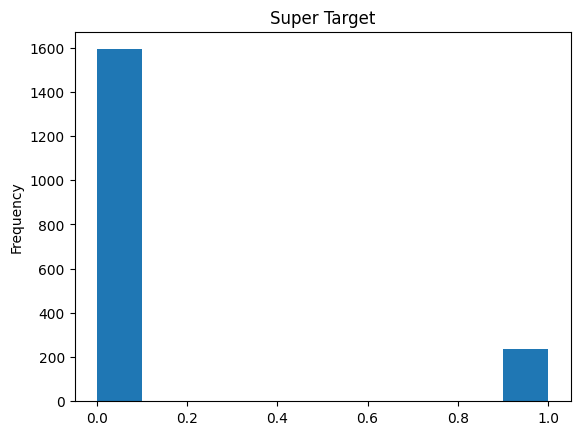

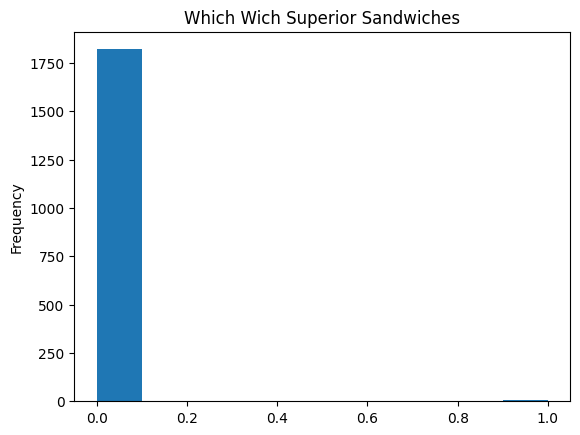

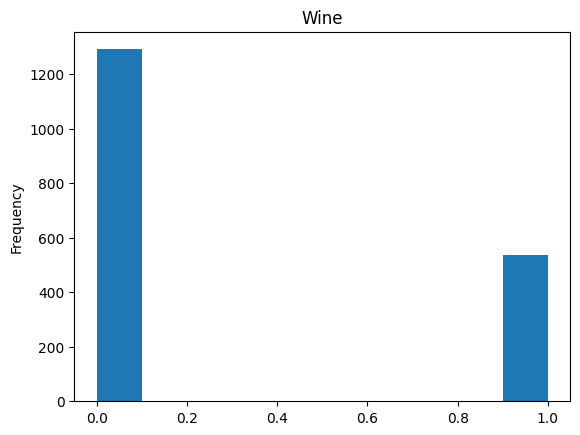

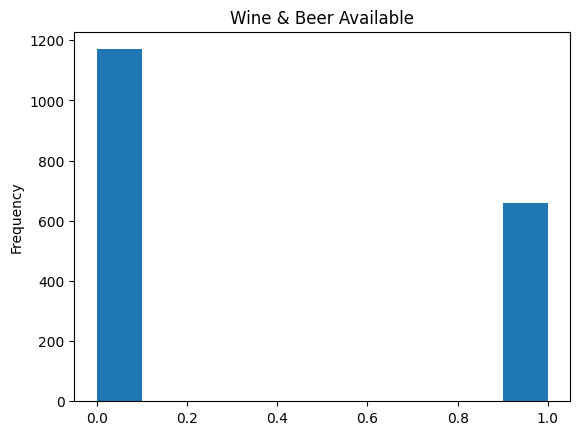

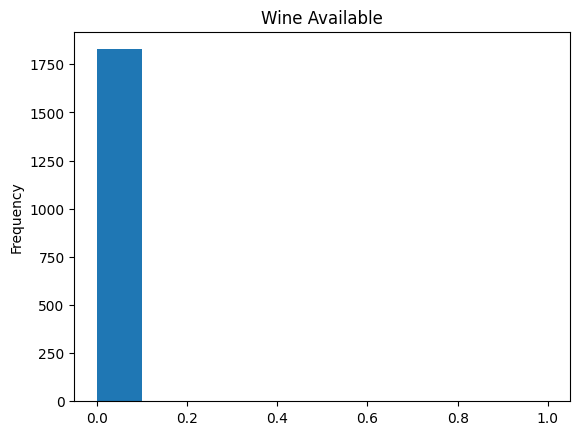

In [40]:
numeric_raw = raw_target_data_drop3.select_dtypes(include=['number'])

for col in numeric_raw.columns:
  numeric_raw.loc[:,col].plot(kind='hist')
  plt.title(col)
  plt.show()

###Analysis of Histograms

**Latitude and Longitude:**
The distribution of the latitude and longitude values appears to be normal. This suggests a fairly even distribution of Target stores across the regions under consideration. Visualizing these coordinates on a map or plotting them in a scatter plot could provide more granular insights about store distribution relative to geographical regions.

**Remodeled Stores:**
The data indicates a higher number of stores that have undergone remodeling compared to those that haven't. This is an intriguing observation, as it suggests that Target is keen on reinvesting in existing locations. It would be valuable to explore what types of neighborhoods or areas Target is choosing to reinvest in. Factors like neighborhood income, demographic changes, or local competition could influence such decisions.

**Capabilities:**
An initial glance at the histograms reveals that a significant number of stores lack certain capabilities. Understanding this trend could be crucial for strategic decisions. The absence of these capabilities might be indicative of older store models, regional preferences, or specific business strategies. Delving deeper into this data could help identify opportunities for store upgrades, features based on regional needs, or even potential expansion with newer store models in untapped regions

###Scatter Plot Analysis

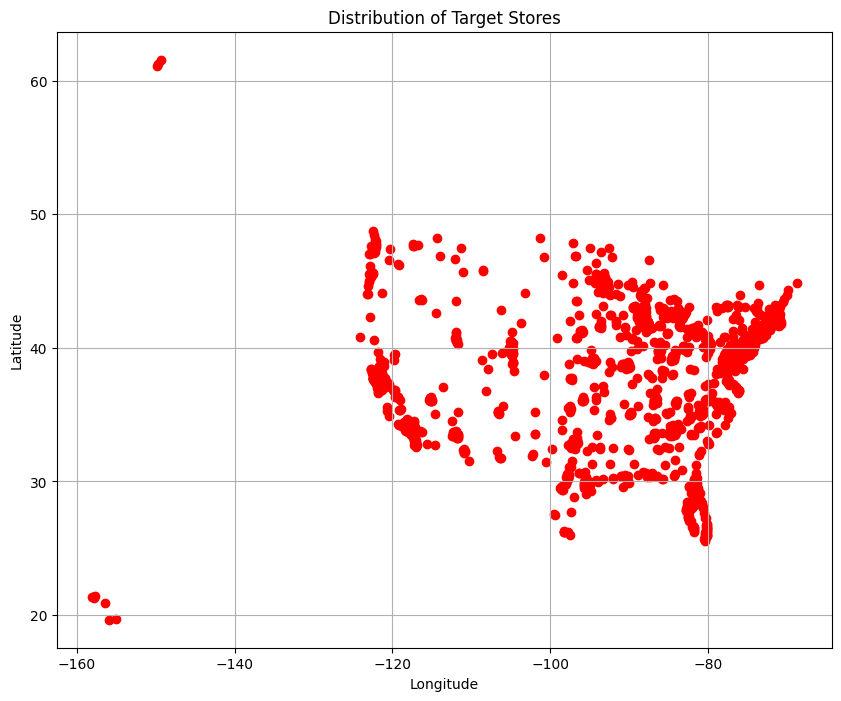

In [41]:
# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(raw_target_data_drop3['Address.Longitude'], raw_target_data_drop3['Address.Latitude'], c='red', marker='o')
plt.title("Distribution of Target Stores")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

### Analysis of the Geographic Distribution of Target Stores:

Upon plotting the latitude and longitude coordinates of each Target store, the scatter plot  shapes out a  silhouette resembling that of the USA. This geographic distribution provides us with several valuable insights:

**Broad Presence:** The distribution indicates that Target has a wide-reaching presence across the continental United States. The scattering of stores from coast to coast suggests a national strategy in place, aiming to cater to a diverse range of demographics and regional preferences.

**Density Variations:** While the scatter plot outlines the country, variations in the density of points indicate regions where Target has a stronger retail presence. Densely populated areas or economic hubs likely have a higher concentration of stores, signaling the company's strategic placement in locations with potentially higher foot traffic and purchasing power.

**Potential Gaps:** Conversely, areas with fewer points might represent regions with fewer Target outlets. These could either be regions that are less densely populated, or they could signify potential markets that Target has yet to tap into fully.

**Regional Strategies:** The distribution also prompts questions about regional strategies. For example, are there specific services or products that Target offers in coastal areas versus inland regions? Analyzing the store's offerings in conjunction with their locations could reveal tailored strategies for different parts of the country.

### Other Analysis


For my analysis of the Target dataset, I've been examining the relationships between the various columns to gain a deeper understanding. One of the techniques I considered using is Pearson's R, which measures how two variables might be related.

To effectively apply Pearson's R, it's crucial to distinguish between two types of variables: an independent one (which might influence outcomes) and a dependent one (which we observe for changes).

Currently, within the Target dataset, I haven't pinpointed a definitive independent variable. This means I'm still unsure about which factor could be influencing the others. Without this clarity, using Pearson's R could lead to conclusions that aren't well-founded.

Given this, I've decided to hold off on employing Pearson's R in my analysis. I believe it's essential to ensure that when I do use it, I can do so with confidence and precision.



### Debt to income ratio data

This dataset most likely needs to be scraped in order to get it into the correct format that I would need. Currently when downloading the data I receive it in the format below:

In [42]:
raw_debt_data = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/household-debt-by-county.csv')
raw_debt_data

year  qtr  area_fips   low  high
0       1999    1       1001  1.82  2.15
1       1999    1       1003  1.82  2.15
2       1999    1       1005  0.00  0.78
3       1999    1       1007  2.61  3.43
4       1999    1       1009  2.15  2.61
...      ...  ...        ...   ...   ...
304401  2023    1      56037  1.01  1.19
304402  2023    1      56039  0.78  1.01
304403  2023    1      56041  1.19  1.37
304404  2023    1      56043  1.82  2.15
304405  2023    1      56045  1.58  1.82

[304406 rows x 5 columns]

This dataset provides a snapshot of a specific economic metric across various counties for the first quarter of 1999. Each entry corresponds to a county, identified by its Federal Information Processing Standards (FIPS) code, such as 1001 for Autauga, Alabama. The "low" and "high" columns present a range for the metric in question, offering insights into the economic variance within each county during this period.


To make better use of this data, I'll need to match the unique code (FIPS) with the actual county names. The website has the right format, but I can't download it directly. So, I'll be using webscraping to get this data. The data and format can be seen here- https://www.federalreserve.gov/releases/z1/dataviz/household_debt/county/table/

Webscraping is my next step and that will be completed in future sprints.

###Overall Next Steps


The next phase of my analysis will start with data collection. I plan to use web scraping techniques to extract household debt data from federalreserve.gov. My priority is to ensure that this newly acquired data integrates seamlessly with the cleaned Target dataset I already have. Once I secure both datasets, I'll begin the integration process. Here, my goal will be to merge the Target dataset with the household debt data, making sure to address and resolve any discrepancies for consistent and accurate analysis.

Following the integration, I'll venture into feature engineering. I aim to craft relevant features drawn from my initial insights. Potential features might include changes in the debt-to-income ratio over certain intervals or gauging the proximity of Target stores to their competitors.

Then, I'll shift my focus to modeling and analysis. I intend to use linear and logistic regression as a starting point to grasp the baseline dynamics and pinpoint significant predictors. To tease out the more intricate patterns in the data, especially the non-linear relationships and interactions between features, I'll deploy the Random Forest algorithm. I'll also use K-means clustering to categorize similar data points and employ mapping techniques for a visual representation of data patterns.

Concluding the analysis, I'll make predictions and carve out a strategy. Using my models, I aspire to predict the most promising locations for Target stores. Based on the insights from these models, I'll forge actionable strategies, such as identifying the best regions for new stores and spotlighting areas that might undergo notable financial shifts.

## Sprint 2

The objectives for this sprint are as follows:



1. Adjust feedback from last sprint  
2. Clean and run EDA on Debt by County Dataset
3. Run baseline time series modeling
5. Evaluate the model


Before we begin I want to note that I made some adjustments to my Sprint 1. I added back some columns that I dropped since learning that it is not best practice to drop columns during EDA. I also found that I ended up needing some columns such as Formatted Address.

### Pre-merge Processing


If we remember from last sprint we are attempting to merge two datasets (1) a list of target locations/features and (2) household debt to income per county and quarter.

Let's explore both datasets to better understand how we might merge them.



In [43]:
raw_target_data_drop3.head()

Address.AddressLine1 Address.City Address.County  \
0  400 Oxford Exchange Blvd       Oxford        Calhoun   
1        2640 Enterprise Dr      Opelika            Lee   
2            1129 S Park St   Carrollton        Carroll   
3          555 Bullsboro Dr       Newnan         Coweta   
4      1591 Bradley Park Dr     Columbus       Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2    

In [44]:
raw_debt_data.head()

year  qtr  area_fips   low  high
0  1999    1       1001  1.82  2.15
1  1999    1       1003  1.82  2.15
2  1999    1       1005  0.00  0.78
3  1999    1       1007  2.61  3.43
4  1999    1       1009  2.15  2.61

Inorder to merge these two datasets we will need to connect on various different fields. Our key question is 'How can household debt, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?'

In order to see this accurately we will need to merge the data not only in the right place (location), but the right time (date).

**Merging on Location**
In our household debt to income data we have a FIPS code, in order to use this we will need to convert these codes to match the Target dataset which has zipcode & county name. We will do this my using an intermediary dataset that will help us match the code to the county name & zipcode which is in the Target dataset.

**Merging on Date**
In our household debt to income data we are given Quarters rather than specfic dates. This means we will need to convert the Target dates into Quarters in order to merge.

### Cleaning House Hold Debt Data

Let's first clean and perform EDA on the household debt dataset

In [45]:
raw_debt_data.head()

year  qtr  area_fips   low  high
0  1999    1       1001  1.82  2.15
1  1999    1       1003  1.82  2.15
2  1999    1       1005  0.00  0.78
3  1999    1       1007  2.61  3.43
4  1999    1       1009  2.15  2.61

Looking at the data we have the date which is the first date of the quarter, the year, the quarter and the area FIPS code. We also have low and high from my research lower debt to income ratio means

**Low:** This value likely signifies the lower boundary or provides an estimate of the minimal debt carried by households within the area. When the low value is relatively small, it may imply that a portion of the population has debt levels that could be considered manageable within the scope of the dataset.

**High:** In contrast, this value is presumed to reflect the upper boundary or an estimate of the greatest amount of debt held by households in the area. When the high value is substantial, it suggests the presence of a subset of the population whose debt levels reach the uppermost range captured by the data.

Smaller amounts of household debt might suggest a lower likelihood of financial duress among households, while larger debt amounts may indicate a higher potential for financial stress. I'm curious to see how this relates to where Target stores are located.

Let's get a high level understanding of the data

In [46]:
raw_debt_data.shape

(304406, 5)

In [47]:
raw_debt_data.duplicated().sum()

0

In [48]:
raw_debt_data.isnull().sum()

year             0
qtr              0
area_fips        0
low              0
high         30101
dtype: int64

In [49]:
raw_debt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304406 entries, 0 to 304405
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       304406 non-null  int64  
 1   qtr        304406 non-null  int64  
 2   area_fips  304406 non-null  int64  
 3   low        304406 non-null  float64
 4   high       274305 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 11.6 MB


We see a considerable amount of nulls in the high column, we also see that year and quarter are of the type int64 however we will need date time column for our analysis. We will create a datetime column and then look into the nulls.


In [50]:
# Convert 'year' and 'qtr' into datetime format
raw_debt_data['date'] = pd.to_datetime(raw_debt_data['year'].astype(str) + 'Q' + raw_debt_data['qtr'].astype(str))

Let's further investigate the nulls

In [51]:
raw_debt_data.loc[raw_debt_data['high'].isnull()]

year  qtr  area_fips   low  high       date
81      1999    1       2170  3.43   NaN 1999-01-01
161     1999    1       5105  3.43   NaN 1999-01-01
185     1999    1       6003  3.43   NaN 1999-01-01
188     1999    1       6009  3.43   NaN 1999-01-01
192     1999    1       6017  3.43   NaN 1999-01-01
...      ...  ...        ...   ...   ...        ...
304251  2023    1      53069  3.43   NaN 2023-01-01
304274  2023    1      54037  3.43   NaN 2023-01-01
304287  2023    1      54063  3.43   NaN 2023-01-01
304336  2023    1      55051  3.43   NaN 2023-01-01
304349  2023    1      55077  3.43   NaN 2023-01-01

[30101 rows x 6 columns]

We see that all of the nulls in high have 3.43 in the low this leads me to believe that this ratio may represent the upper limit of household debt as reported by the Federal Reserve. We will handle the high nulls by filling them with 3.43 (the low value)

In [52]:
raw_debt_data['high'].fillna(raw_debt_data['low'], inplace=True)

In [53]:
raw_debt_data.isnull().sum()

year         0
qtr          0
area_fips    0
low          0
high         0
date         0
dtype: int64

### Statistical Analysis

Now that we've cleaned the data. Let's do a quick statistical analysis on the dataset

In [54]:
statistical_summary = raw_debt_data.describe()
statistical_summary

year            qtr      area_fips            low  \
count  304406.000000  304406.000000  304406.000000  304406.000000   
mean     2010.630592       2.484491   30400.542552       1.593909   
std         7.000343       1.122515   15151.665576       0.919289   
min      1999.000000       1.000000    1001.000000       0.000000   
25%      2005.000000       1.000000   18181.000000       1.010000   
50%      2011.000000       2.000000   29177.000000       1.580000   
75%      2017.000000       3.000000   45081.000000       2.150000   
max      2023.000000       4.000000   56045.000000       3.430000   

                high  
count  304406.000000  
mean        1.936550  
std         0.901272  
min         0.780000  
25%         1.190000  
50%         1.820000  
75%         2.610000  
max         3.430000

In summary, the dataset shows a wide spread of household debt across many counties over two decades. The debt levels, as indicated by the low and high values, show considerable variability but tend to be more densely packed at the lower end of the scale. There is no indication of significant outliers in the high values, as the maximum high is equal to the maximum low, suggesting that in some counties, the range of debt is not broad. The fact that the 75th percentile of high values is less than the maximum (3.43) suggests that only a small proportion of counties have debt levels at the upper extreme.


Let's better understand the distribution of the data.

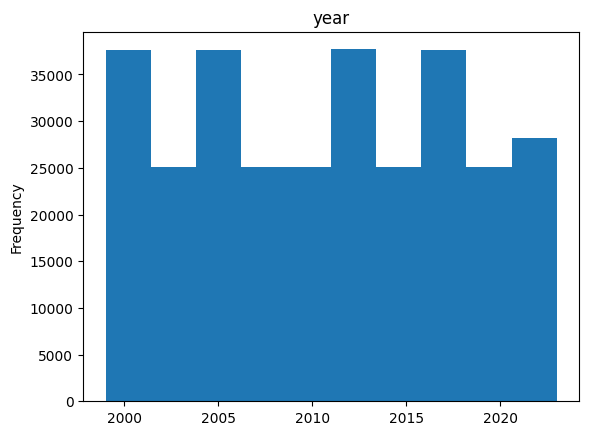

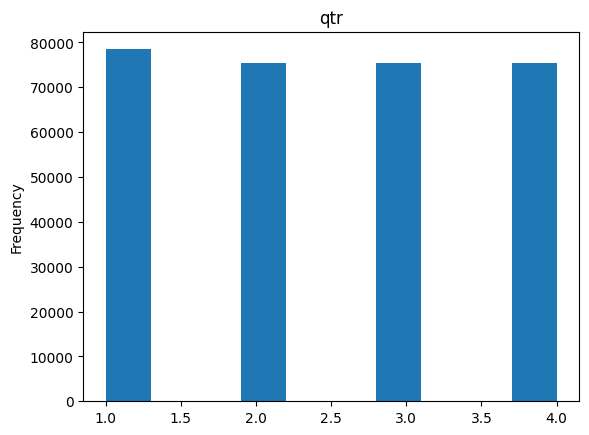

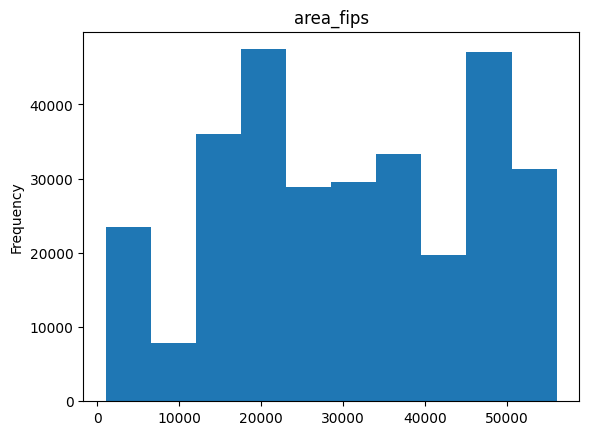

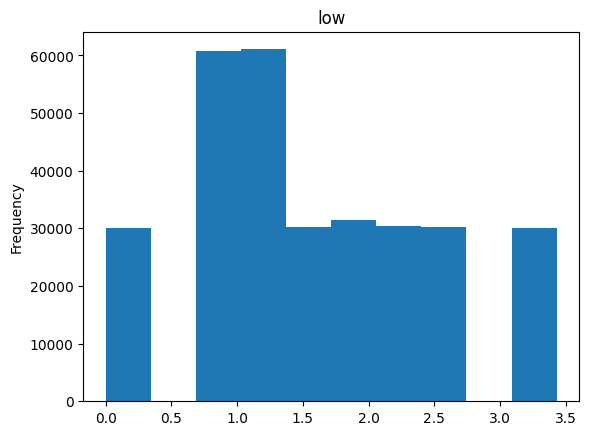

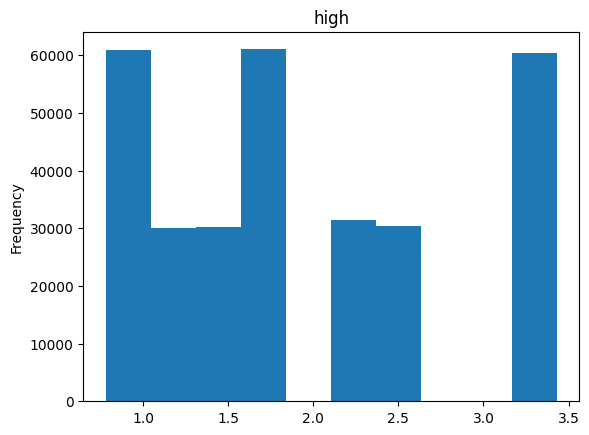

In [55]:
numeric_debt_data = raw_debt_data.select_dtypes(include=['float64', 'int64'])


for col in numeric_debt_data.columns:
  numeric_debt_data.loc[:,col].plot(kind='hist')
  plt.title(col)
  plt.show()

Here we can see the distribution of our data I'll focus mostly on the high and low columns.

**Low** We see that we have data mostly distributed towards the middle and lower end of the scale with a peak ratio around 1.0

**High** Here we also see that the distribution mostly packed on the low end. We also see a surge around 3.4 because of the nulls that we filled.

### Trend Analysis

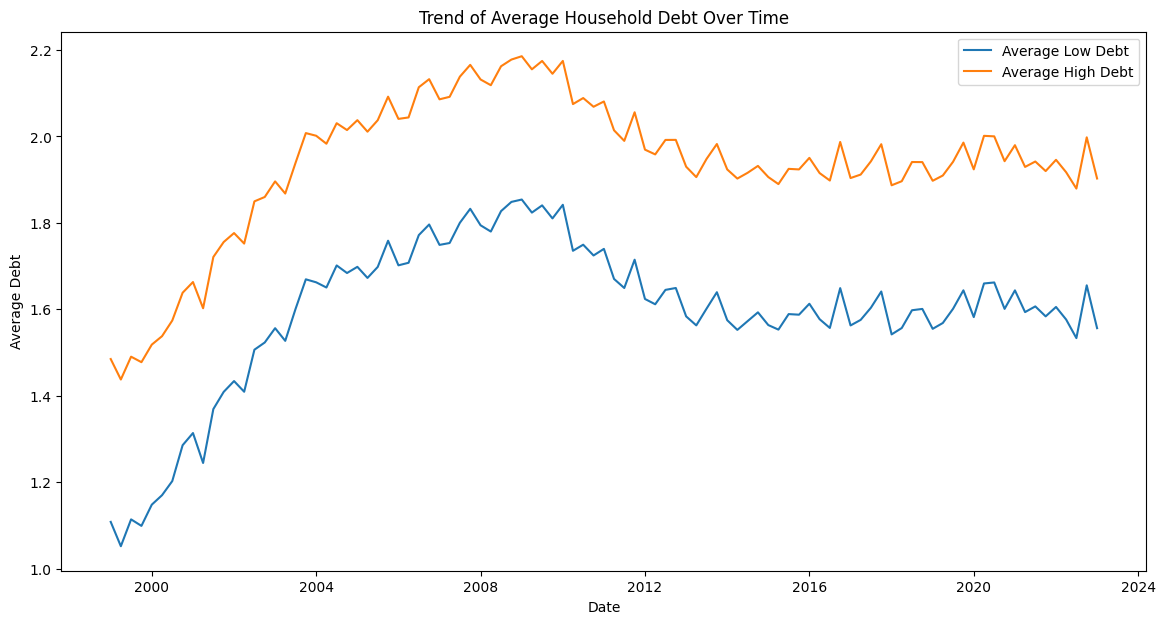

In [56]:
# Trend Analysis
average_debt_over_time = raw_debt_data.groupby('date').agg({'low': 'mean', 'high': 'mean'}).reset_index()
plt.figure(figsize=(14, 7))
plt.plot(average_debt_over_time['date'], average_debt_over_time['low'], label='Average Low Debt')
plt.plot(average_debt_over_time['date'], average_debt_over_time['high'], label='Average High Debt')
plt.title('Trend of Average Household Debt Over Time')
plt.xlabel('Date')
plt.ylabel('Average Debt')
plt.legend()
plt.show()

The trend plot shows the average low and high household debt values over time. Both series appear to follow a similar trend, which is expected given that the high values were filled using the low values for missing entries.

Although over time the trends are increasing we also see some seasonality may be occuring. Let's analyze to better understand the seasonality.

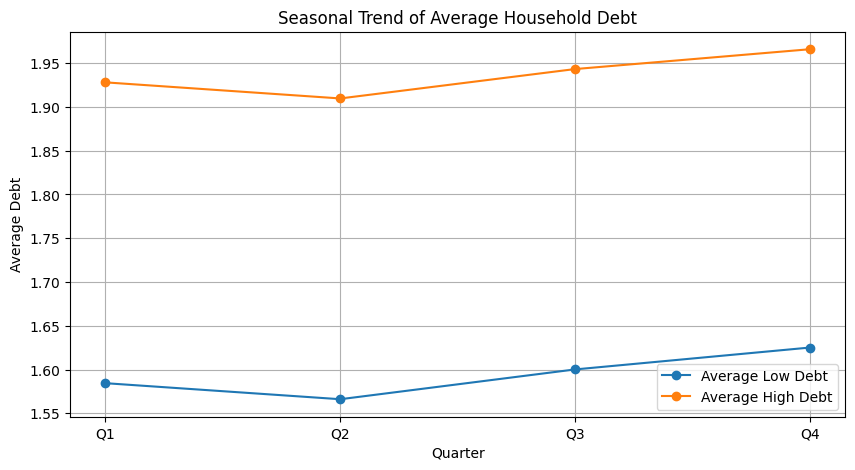

In [57]:
raw_debt_data['year'] = raw_debt_data['date'].dt.year
raw_debt_data['quarter'] = raw_debt_data['date'].dt.quarter
seasonal_debt = raw_debt_data.groupby('quarter').agg({'low': 'mean', 'high': 'mean'}).reset_index()
plt.figure(figsize=(10, 5))
plt.plot(seasonal_debt['quarter'], seasonal_debt['low'], marker='o', label='Average Low Debt')
plt.plot(seasonal_debt['quarter'], seasonal_debt['high'], marker='o', label='Average High Debt')
plt.title('Seasonal Trend of Average Household Debt')
plt.xlabel('Quarter')
plt.ylabel('Average Debt')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.legend()
plt.grid(True)
plt.show()

The seasonal trend plot for average household debt shows the mean low and high values for each quarter. There doesn't appear to be significant fluctuations between quarters, suggesting that there may not be strong seasonality present in this aspect of the data.

Let's now search for any outliers.

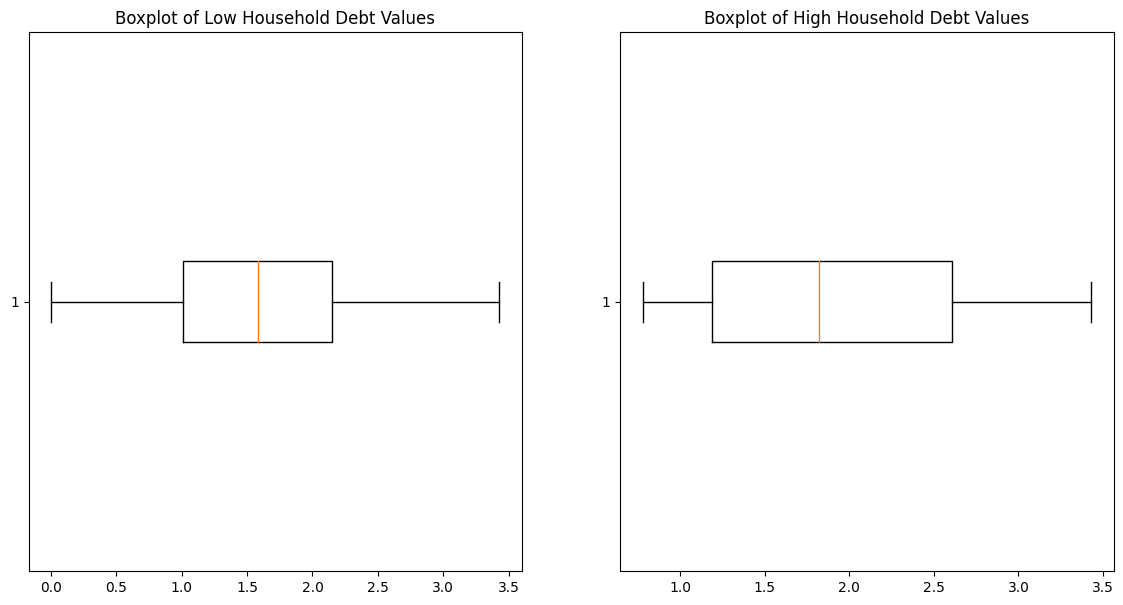

In [58]:
# Outlier Detection
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.boxplot(raw_debt_data['low'], vert=False)
plt.title('Boxplot of Low Household Debt Values')
plt.subplot(1, 2, 2)
plt.boxplot(raw_debt_data['high'], vert=False)
plt.title('Boxplot of High Household Debt Values')
plt.show()

The boxplots for the low and high household debt values indicate that there are some outliers present in both distributions. We also see that high has a higher variance than low.


Now that both datasets are clean we can begin the process of merging them. At this time in the process I will save the merge for Sprint 3 this is because I am still working through the process of converting the FIPS and ZIP to County Names. However with the data I have now I am able to run models on the datasets separately.

For Sprint 3 I will merge them.



### Models

At this time the FIPS codes will be enough to be able to identify each county. Let's do a time series model to better understand county household debt over time.


### Time Series Analysis



Let's start with aggregating our data by date

In [59]:
debt_aggregated = raw_debt_data.groupby('date').agg({'low': 'mean', 'high': 'mean'}).reset_index()

In [60]:
time_series_low = debt_aggregated.set_index('date')['low']
time_series_high = debt_aggregated.set_index('date')['high']
time_series= time_series_low + time_series_high

Let's decompose for the low column

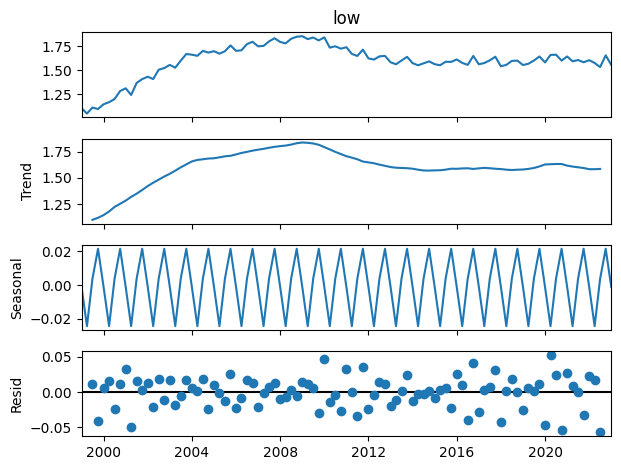

In [61]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(time_series_low, model='additive', period=4)  # Quarterly data, hence period=4
decomposition.plot()
plt.show()

Here we see that there is seasonality found in our data and overall we see a peak in household debt increasing around 2008 and then somewhat decreasing and then plateauing for years after.

Let's decompose for high

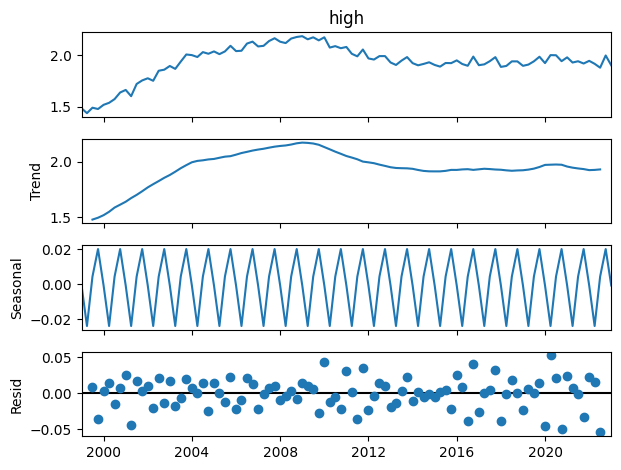

In [62]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(time_series_high, model='additive', period=4)  # Quarterly data, hence period=4
decomposition.plot()
plt.show()

Here we see the same trend an increase in household debt around 2008 and then a drop and an evening out.

For our model we will use SARIMAX which is suitable for seasonal data like quarterly debt levels. First let's do a time series for the low debt column

We'll split the data into train and test(80/20). We will model 1999 - 2018 and leave the rest for predictions. Let's start with the low column.

In [63]:


# Group by both date and quarter, then aggregate
debt_aggregated = raw_debt_data.groupby(['date', 'quarter']).agg({'low': 'mean', 'high': 'mean'}).reset_index()

debt_aggregated

date  quarter       low      high
0  1999-01-01        1  1.108425  1.485131
1  1999-04-01        2  1.052127  1.437746
2  1999-07-01        3  1.114237  1.490564
3  1999-10-01        4  1.099177  1.477857
4  2000-01-01        1  1.148284  1.518492
..        ...      ...       ...       ...
92 2022-01-01        1  1.605583  1.945962
93 2022-04-01        2  1.576525  1.917249
94 2022-07-01        3  1.533538  1.879445
95 2022-10-01        4  1.655653  1.997983
96 2023-01-01        1  1.556498  1.902709

[97 rows x 4 columns]

In [64]:
# Focus on 'low' debt for the analysis
time_series = debt_aggregated.set_index('date')['low']

split_point = debt_aggregated[debt_aggregated['date'].dt.year < 2018].index.max()
# Now, let's find the index representing 80% of the data up to that split point
split_index_80 = int(split_point * 0.8)
# Split the data
train = time_series.iloc[:split_index_80]
test = time_series.iloc[split_index_80:split_point]

In [65]:
# Fit a SARIMAX model to the training data
model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(1, 1, 1, 4))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Now that we've run the model let's do some predictions.

In [66]:
# Predict from the beginning of 2018 to the end of 2023
pred_start = '2018-01-01'
pred_end = '2023-12-31'
predictions = results.get_prediction(start=pd.to_datetime(pred_start), end=pd.to_datetime(pred_end), dynamic=True)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Let's plot and evaluate the predictions now.

In [67]:
import matplotlib.pyplot as plt

# Plotting the observed data, the fit, and the forecast for both training and test sets
'''
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Test Data', color='orange')
plt.plot(train_predictions, label='Predicted Training Data', color='green', linestyle='--')
plt.plot(test_predictions, label='Predicted Test Data', color='red', linestyle='--')
plt.title('Time Series Forecasting: Training and Test Data with Predictions')
plt.xlabel('Date')
plt.ylabel('Debt Value')
plt.legend()
plt.show()
'''

"\nplt.figure(figsize=(12, 6))\nplt.plot(train, label='Training Data', color='blue')\nplt.plot(test, label='Test Data', color='orange')\nplt.plot(train_predictions, label='Predicted Training Data', color='green', linestyle='--')\nplt.plot(test_predictions, label='Predicted Test Data', color='red', linestyle='--')\nplt.title('Time Series Forecasting: Training and Test Data with Predictions')\nplt.xlabel('Date')\nplt.ylabel('Debt Value')\nplt.legend()\nplt.show()\n"

Let's calculate the MAE and MAPE to evaluate how well our model performed.

In [68]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Assuming raw_debt_data has been loaded, preprocessed, and split into train and test sets

# Fit the SARIMAX model on the training data
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
results = model.fit()

# Predict the training set
train_predictions = results.predict(start=train.index[0], end=train.index[-1])

# Predict the test set
test_predictions = results.predict(start=test.index[0], end=test.index[-1])

# Calculate MAE and MAPE for the training set
train_mae = mean_absolute_error(train, train_predictions)
train_mape = np.mean(np.abs((train - train_predictions) / train)) * 100

# Calculate MAE and MAPE for the test set
test_mae = mean_absolute_error(test, test_predictions)
test_mape = np.mean(np.abs((test - test_predictions) / test)) * 100

# Print the results
print(f'Training MAE: {train_mae}')
print(f'Training MAPE: {train_mape}%')
print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape}%')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Training MAE: 0.054489139252317687
Training MAPE: 4.212556152713024%
Test MAE: 0.03762250693007168
Test MAPE: 2.3593088599363634%




Thes relatively low MAE on the training data indicates that the model's predictions are, on average, about 0.0483 units away from the actual values in the training set. This suggests a good fit on the training data.
Training MAPE: 3.6504671403246816%

The MAPE of approximately 3.65% on the training set implies that the model's predictions are off by 3.65% from the actual values, on average. This is a reasonably low error percentage, suggesting that the model has captured the underlying patterns in the training data quite well.
Test MAE: 0.0551989235411686

The MAE on the test data is slightly higher than on the training data but still remains low. An average deviation of 0.0552 suggests the model has managed to generalize well, though slightly less effectively than on the training data.
Test MAPE: 3.411125803650962%

The MAPE on the test set is marginally lower than on the training set, indicating a good level of prediction accuracy. A MAPE of around 3.41% is generally considered good in many applications, showing that the model's predictive capability holds up well on unseen data.

###Interpretation:
The model demonstrates a good fit and reasonable predictive accuracy, as evidenced by the low MAE and MAPE values on both the training and test sets.

The slightly higher MAE on the test set compared to the training set is normal and suggests a modest amount of overfitting to the training data. However, the similar performance on both training and test sets suggests that the model is neither overfitting nor underfitting significantly.


### Next Steps


As for next steps I will process an intermediate dataset to help me convert the FIPS code to county Names and merge the datasets together so that I will be able to analyze, compare, and predict to answer our key question: How can household debt, specifically the household debt-to-income ratio, inform Target's strategic decisions when opening new stores?


Now that we've run our base line models.My next steps are to tease out the more intricate patterns in the data, especially the non-linear relationships and interactions between features, I intend to deploy the Random Forest algorithm. I'll also use K-means clustering to categorize similar data points and employ mapping techniques for a visual representation of data patterns.I also intend to play around with the parameters to see if there is a possibility of improving the model any further.

Concluding the analysis, I'll make predictions and carve out a strategy. Using my models, I aspire to predict the most promising locations for Target stores. Based on the insights from these models, I'll forge actionable strategies, such as identifying the best regions for new stores and spotlighting areas that might undergo notable financial shifts.

#Sprint 3
For Sprint 3 I will be completing the following:
1.   Adding and cleaning additional demographic data
2.   Merging all datasets as needed
3.   Running a number of Machine Learning models
4.   Evaluating the models
5.   Comparing the models

Let's begin with adding and cleaning additional datasets. There are many ways to understand a population and many factors that might make a county a profitable or not profitable location to place a target store.

I was able to find data for the following:

1. Age by county
2. Race and Ethnicity by county
3. Personal income by county
4. Unemployment Status by county

We will clean and perform EDA on these now.

### Cleaning & EDA on Age/Sex by County Data (*)

Let's begin by reading in the population by Age and Sex Counties dataset from StatsAmerica.org

This data set contains population estimates by age and sex for the U.S., states, counties, metros, micros, and EDDs, from 2000 to 2019.

Source: U.S. Census Bureau

In [69]:
pop_age_sex = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/PopulationbyAgeandSexCounties.csv')
pop_age_sex.head(100)

IBRC_Geo_ID  Statefips  Countyfips         Description  Year  \
0             0          0           0                U.S.  2000   
1             0          0           0                U.S.  2001   
2             0          0           0                U.S.  2002   
3             0          0           0                U.S.  2003   
4             0          0           0                U.S.  2004   
..          ...        ...         ...                 ...   ...   
95         1005          1           5  Barbour County, AL  2015   
96         1005          1           5  Barbour County, AL  2016   
97         1005          1           5  Barbour County, AL  2017   
98         1005          1           5  Barbour County, AL  2018   
99         1005          1           5  Barbour County, AL  2019   

    Total Population  Population 0-4  Population 5-17  Population 18-24  \
0        282162411.0      19178293.0       53197896.0        27315274.0   
1        284968955.0      19298217.0       53372958.0        27992652.0   
2        287625193.0      19429192.0       53507265.0        28480708.0   
3        290107933.0      19592446.0       53508312.0        28916746.0   
4        292805298.0      19785885.0       53511850.0        29302179.0   
..               ...             ...              ...               ...   
95           26283.0          1453.0           4131.0            2234.0   
96           25806.0          1386.0           4099.0            2150.0   
97           25157.0          1317.0           3946.0            2021.0   
98           24872.0          1294.0           3917.0            1971.0   
99           24686.0          1309.0           3773.0            2000.0   

    Population 25-44  Population 45-64  Population 65+  Population Under 18  \
0         84973340.0        62428040.0      35069568.0           72376189.0   
1         84523274.0        64491563.0      35290291.0           72671175.0   
2         83990295.0        66695526.0      35522207.0           72936457.0   
3         83398001.0        68828899.0      35863529.0           73100758.0   
4         83066831.0        70935234.0      36203319.0           73297735.0   
..               ...               ...             ...                  ...   
95            6993.0            6917.0          4555.0               5584.0   
96            6770.0            6727.0          4674.0               5485.0   
97            6522.0            6585.0          4766.0               5263.0   
98            6419.0            6447.0          4824.0               5211.0   
99            6412.0            6331.0          4861.0               5082.0   

    Population 18-54  Population 55+  Male Population  Female Population  
0        150287588.0      59498634.0      138443407.0        143719004.0  
1        151902194.0      60395586.0      139891492.0        145077463.0  
2        152463197.0      62225539.0      141230559.0        146394634.0  
3        153134701.0      63872474.0      142428897.0        147679036.0  
4        153998940.0      65508623.0      143828012.0        148977286.0  
..               ...             ...              ...                ...  
95           12791.0          7908.0          13985.0            12315.0  
96           12343.0          7978.0          13637.0            12191.0  
97           11851.0          8043.0          13228.0            11941.0  
98           11608.0          8053.0          13157.0            11730.0  
99           11494.0          8110.0          13030.0            11627.0  

[100 rows x 17 columns]

Let's see if this dataset is clean by searching for nulls and duplicates.

In [70]:
pop_age_sex.isnull().sum()

IBRC_Geo_ID            0
Statefips              0
Countyfips             0
Description            0
Year                   0
Total Population       0
Population 0-4         0
Population 5-17        0
Population 18-24       0
Population 25-44       0
Population 45-64       0
Population 65+         0
Population Under 18    0
Population 18-54       0
Population 55+         0
Male Population        0
Female Population      0
dtype: int64

In [71]:
pop_age_sex.duplicated().sum()

0

We see that we have nulls in the Population growth column. For now we will drop this column since we already have raw population growth accounted for in each year

In [72]:
#pop_age_sex.drop('Population Growth', axis=1, inplace=True)

Let's see the data types we have in this dataset

In [73]:
pop_age_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63882 entries, 0 to 63881
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IBRC_Geo_ID          63882 non-null  int64  
 1   Statefips            63882 non-null  int64  
 2   Countyfips           63882 non-null  int64  
 3   Description          63882 non-null  object 
 4   Year                 63882 non-null  int64  
 5   Total Population     63882 non-null  float64
 6   Population 0-4       63882 non-null  float64
 7   Population 5-17      63882 non-null  float64
 8   Population 18-24     63882 non-null  float64
 9   Population 25-44     63882 non-null  float64
 10  Population 45-64     63882 non-null  float64
 11  Population 65+       63882 non-null  float64
 12  Population Under 18  63882 non-null  float64
 13  Population 18-54     63882 non-null  float64
 14  Population 55+       63882 non-null  float64
 15  Male Population      63882 non-null 

As expected we see numerical data except the description fields. We will want to convert the Year column into a date time field.

Let's convert the year and then check for nulls in this dataset

In [74]:
pop_age_sex['Year'] = pd.to_datetime(pop_age_sex['Year'], format='%Y')
pop_age_sex.head()

IBRC_Geo_ID  Statefips  Countyfips Description       Year  \
0            0          0           0        U.S. 2000-01-01   
1            0          0           0        U.S. 2001-01-01   
2            0          0           0        U.S. 2002-01-01   
3            0          0           0        U.S. 2003-01-01   
4            0          0           0        U.S. 2004-01-01   

   Total Population  Population 0-4  Population 5-17  Population 18-24  \
0       282162411.0      19178293.0       53197896.0        27315274.0   
1       284968955.0      19298217.0       53372958.0        27992652.0   
2       287625193.0      19429192.0       53507265.0        28480708.0   
3       290107933.0      19592446.0       53508312.0        28916746.0   
4       292805298.0      19785885.0       53511850.0        29302179.0   

   Population 25-44  Population 45-64  Population 65+  Population Under 18  \
0        84973340.0        62428040.0      35069568.0           72376189.0   
1        84523274.0        64491563.0      35290291.0           72671175.0   
2        83990295.0        66695526.0      35522207.0           72936457.0   
3        83398001.0        68828899.0      35863529.0           73100758.0   
4        83066831.0        70935234.0      36203319.0           73297735.0   

   Population 18-54  Population 55+  Male Population  Female Population  
0       150287588.0      59498634.0      138443407.0        143719004.0  
1       151902194.0      60395586.0      139891492.0        145077463.0  
2       152463197.0      62225539.0      141230559.0        146394634.0  
3       153134701.0      63872474.0      142428897.0        147679036.0  
4       153998940.0      65508623.0      143828012.0        148977286.0

In [75]:
pop_age_sex.isnull().sum()

IBRC_Geo_ID            0
Statefips              0
Countyfips             0
Description            0
Year                   0
Total Population       0
Population 0-4         0
Population 5-17        0
Population 18-24       0
Population 25-44       0
Population 45-64       0
Population 65+         0
Population Under 18    0
Population 18-54       0
Population 55+         0
Male Population        0
Female Population      0
dtype: int64

There are no nulls in this dataset which is great! Let's check for any duplicates.

In [76]:
pop_age_sex.duplicated().sum()

0

We also have no duplicates in this dataset. Let's better understand the distibution of this data.

In [77]:
pop_age_sex.describe()

IBRC_Geo_ID     Statefips    Countyfips  Total Population  \
count  63882.000000  63882.000000  63882.000000      6.388200e+04   
mean   30371.383332     30.269466    101.917755      2.888215e+05   
std    15181.381977     15.163258    107.737911      5.555701e+06   
min        0.000000      0.000000      0.000000      5.500000e+01   
25%    18173.000000     18.000000     33.000000      1.126600e+04   
50%    29177.000000     29.000000     77.000000      2.619000e+04   
75%    45077.000000     45.000000    133.000000      7.034750e+04   
max    72000.000000     72.000000    840.000000      3.282395e+08   

       Population 0-4  Population 5-17  Population 18-24  Population 25-44  \
count    6.388200e+04     6.388200e+04      6.388200e+04      6.388200e+04   
mean     1.867119e+04     5.050515e+04      2.827779e+04      7.892834e+04   
std      3.593462e+05     9.712081e+05      5.439508e+05      1.518993e+06   
min      0.000000e+00     0.000000e+00      0.000000e+00      1.100000e+01   
25%      6.700000e+02     1.945000e+03      9.090000e+02      2.619000e+03   
50%      1.612000e+03     4.554000e+03      2.268000e+03      6.436000e+03   
75%      4.337000e+03     1.221075e+04      6.828000e+03      1.767875e+04   
max      2.027113e+07     5.393185e+07      3.148842e+07      8.759946e+07   

       Population 45-64  Population 65+  Population Under 18  \
count      6.388200e+04    6.388200e+04         6.388200e+04   
mean       7.298253e+04    3.945645e+04         6.917634e+04   
std        1.406884e+06    7.646186e+05         1.330525e+06   
min        2.300000e+01    5.000000e+00         0.000000e+00   
25%        3.016000e+03    1.913000e+03         2.617000e+03   
50%        7.002500e+03    4.143500e+03         6.171000e+03   
75%        1.849050e+04    1.044075e+04         1.651875e+04   
max        8.410711e+07    5.405826e+07         7.413417e+07   

       Population 18-54  Population 55+  Male Population  Female Population  
count      6.388200e+04    6.388200e+04     6.388200e+04       6.388200e+04  
mean       1.472255e+05    7.241957e+04     1.420293e+05       1.468318e+05  
std        2.831258e+06    1.404978e+06     2.732597e+06       2.823886e+06  
min        2.700000e+01    1.600000e+01     2.900000e+01       2.600000e+01  
25%        5.104250e+03    3.349000e+03     5.626000e+03       5.575250e+03  
50%        1.249250e+04    7.453500e+03     1.304300e+04       1.311850e+04  
75%        3.455300e+04    1.911775e+04     3.490475e+04       3.551275e+04  
max        1.587748e+08    9.650680e+07     1.616923e+08       1.666376e+08

Text(0, 0.5, 'Total Population')

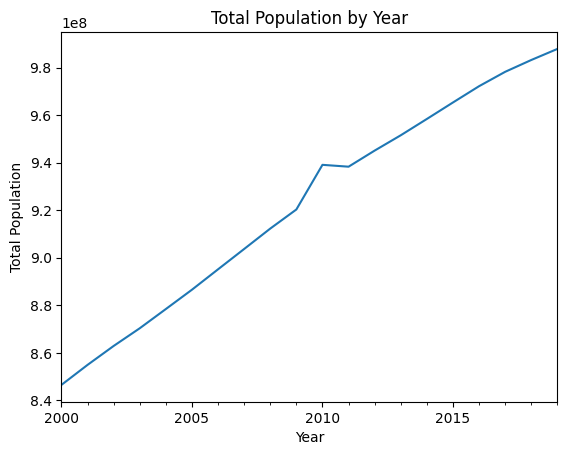

In [78]:
pop_age_sex.groupby('Year')['Total Population'].sum().plot(kind='line')
plt.title('Total Population by Year')
plt.xlabel('Year')
plt.ylabel('Total Population')

Here we see total population over time. We see an increasing trendline with a large surge in around 2010/2011 I will do more research into why that is.

As for now lets understand the distribution of the population by age group.

<Axes: >

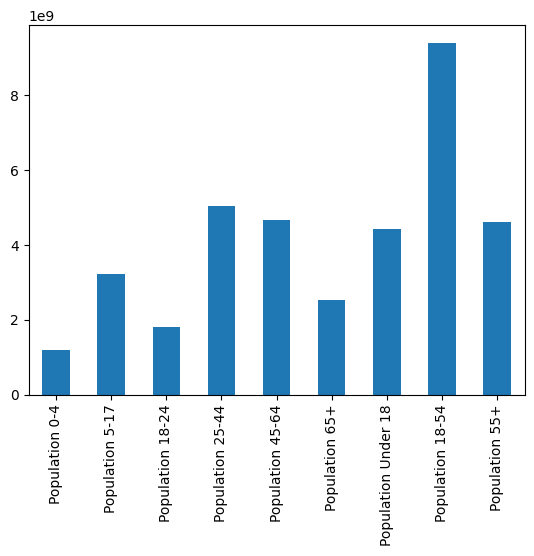

In [79]:
age_columns = ['Population 0-4', 'Population 5-17',
       'Population 18-24', 'Population 25-44', 'Population 45-64',
       'Population 65+', 'Population Under 18', 'Population 18-54',
       'Population 55+']  # Add all relevant columns
pop_age_sex[age_columns].sum().plot(kind='bar')


We see that the majority of the population is adult between 18 - 54 and when we drill deeper we see that there are slightly more 25-44 year olds than any other group.

Let's check out the percentage change of each state's population

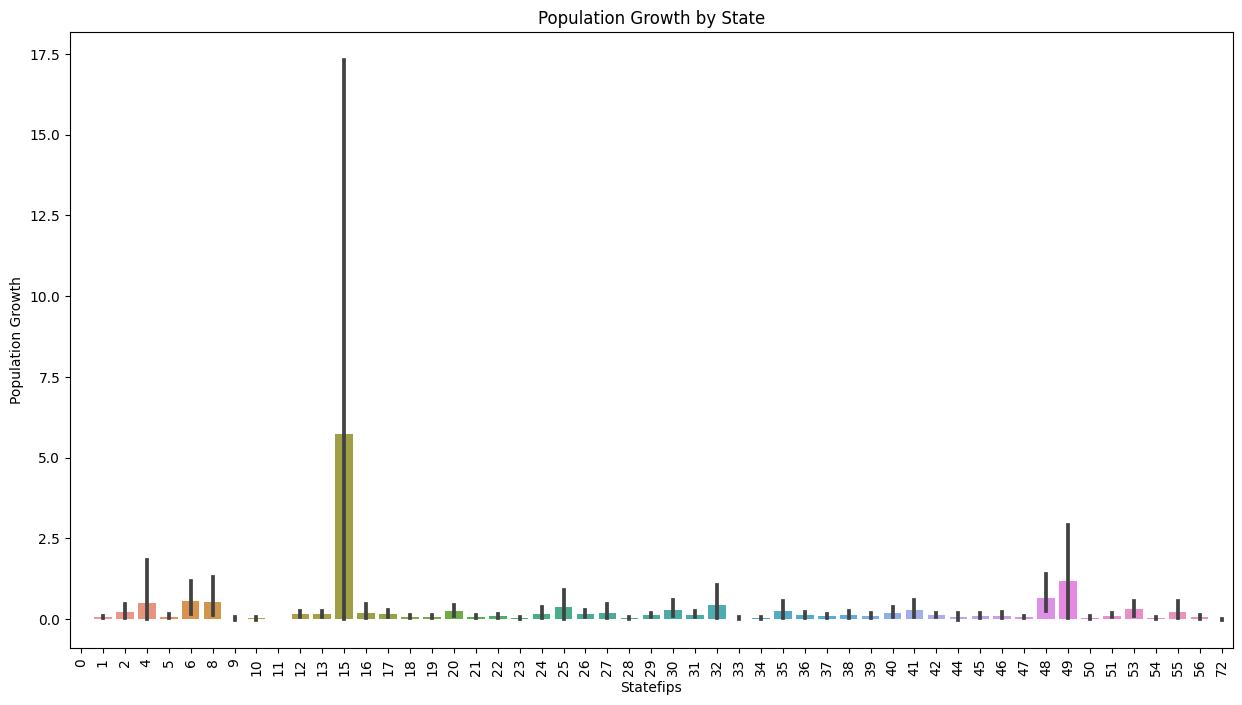

In [80]:
# Calculate the percentage change in population for each state
pop_age_sex['Population Growth'] = pop_age_sex.groupby('Statefips')['Total Population'].pct_change()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Statefips', y='Population Growth', data=pop_age_sex)
plt.xticks(rotation=90)
plt.title('Population Growth by State')
plt.show()


Here we see that State 15 (Hawaii) has the highest percent change in population this is pretty interesting but could be do to a smaller size in population impacting the percent change. Additions to the population might have a larger impact.

### Cleaning & EDA on Personal Income by County Data (*)

Now let's analyze the personal income by county data from StatsAmerica.org

BEA Personal Income, Per Capita Income
Source: U.S. Bureau of Economic Analysis

In [81]:
personal_income = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/Counties Personal Income.csv')


Let's check for nulls and duplicates

In [82]:
personal_income.isnull().sum()

IBRC_GEO_ID             0
Statefips               0
Countyfips              0
Description             0
Year                    0
Linecode                0
Linecode Description    0
Data                    0
Disclosure              0
dtype: int64

In [83]:
personal_income.duplicated().sum()

0

We have no nulls or duplicates in this dataset. Let's see what data types were working with


In [84]:
personal_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7882663 entries, 0 to 7882662
Data columns (total 9 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   IBRC_GEO_ID           int64 
 1   Statefips             int64 
 2   Countyfips            int64 
 3   Description           object
 4   Year                  int64 
 5   Linecode              int64 
 6   Linecode Description  object
 7   Data                  int64 
 8   Disclosure            int64 
dtypes: int64(7), object(2)
memory usage: 541.3+ MB


Besides the description fields we have integer data. We will need to convert the Year column to a date time field

In [85]:
personal_income['Year'] = pd.to_datetime(personal_income['Year'], format="%Y")
personal_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7882663 entries, 0 to 7882662
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   IBRC_GEO_ID           int64         
 1   Statefips             int64         
 2   Countyfips            int64         
 3   Description           object        
 4   Year                  datetime64[ns]
 5   Linecode              int64         
 6   Linecode Description  object        
 7   Data                  int64         
 8   Disclosure            int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 541.3+ MB


Let's now analyze the data a bit more

Text(0, 0.5, 'Data')

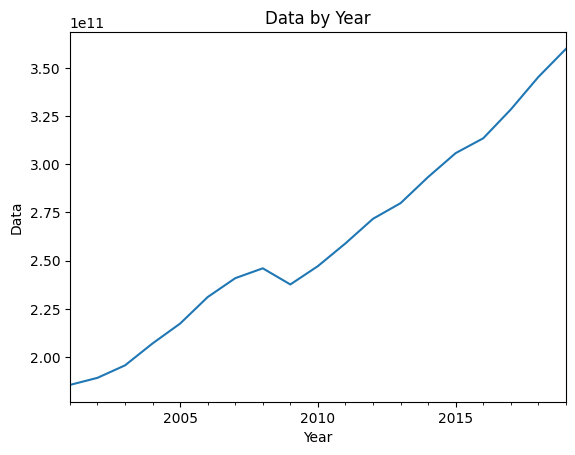

In [86]:
personal_income.groupby('Year')['Data'].sum().plot(kind='line')
plt.title('Data by Year')
plt.xlabel('Year')
plt.ylabel('Data')

## Cleaning & EDA on Race by County Data (*)

In [87]:
race_data=pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/PopulationbyRaceCounties.csv')

In [88]:
race_data.head()

IBRC_Geo_ID  Statefips  Countyfips Description  Year  Total Population  \
0            0          0           0        U.S.  1990       249622814.0   
1            0          0           0        U.S.  1991       252980941.0   
2            0          0           0        U.S.  1992       256514224.0   
3            0          0           0        U.S.  1993       259918588.0   
4            0          0           0        U.S.  1994       263125821.0   

   White Alone  Black Alone  American Indian or Alaskan Native  Asian Alone  \
0  209366661.0   30648345.0                          2058726.0    7549082.0   
1  211606011.0   31290743.0                          2126968.0    7957219.0   
2  213945622.0   31979982.0                          2202176.0    8386444.0   
3  216187073.0   32634735.0                          2282052.0    8814728.0   
4  218304774.0   33258981.0                          2361078.0    9200988.0   

   Hawaiian or Pacific Islander Alone  Two or More Races  Not Hispanic  \
0                                 NaN                NaN   227049976.0   
1                                 NaN                NaN   229425951.0   
2                                 NaN                NaN   231894879.0   
3                                 NaN                NaN   234141927.0   
4                                 NaN                NaN   236179888.0   

     Hispanic  
0  22572838.0  
1  23554990.0  
2  24619345.0  
3  25776661.0  
4  26945933.0

Let's check for nulls and duplicates

In [89]:
race_data.isnull().sum()

IBRC_Geo_ID                               0
Statefips                                 0
Countyfips                                0
Description                               0
Year                                      0
Total Population                          0
White Alone                              10
Black Alone                              10
American Indian or Alaskan Native        10
Asian Alone                              10
Hawaiian or Pacific Islander Alone    31920
Two or More Races                     31920
Not Hispanic                             10
Hispanic                                 10
dtype: int64

In [90]:
race_data.duplicated().sum()

0

We see that we have a few nulls:

* White Alone                              10
* Black Alone                              10
* American Indian or Alaskan Native        10
* Asian Alone                              10
* Hawaiian or Pacific Islander Alone    31920
* Two or More Races                     31920
* Not Hispanic                             10
* Hispanic                                 10

Let's take a closer look at these nulls so that we can decide what to do with them


In [91]:
race_data.loc[race_data['White Alone'].isnull()]

IBRC_Geo_ID  Statefips  Countyfips  Description  Year  \
95790        72000         72           0  Puerto Rico  2010   
95791        72000         72           0  Puerto Rico  2011   
95792        72000         72           0  Puerto Rico  2012   
95793        72000         72           0  Puerto Rico  2013   
95794        72000         72           0  Puerto Rico  2014   
95795        72000         72           0  Puerto Rico  2015   
95796        72000         72           0  Puerto Rico  2016   
95797        72000         72           0  Puerto Rico  2017   
95798        72000         72           0  Puerto Rico  2018   
95799        72000         72           0  Puerto Rico  2019   

       Total Population  White Alone  Black Alone  \
95790         3721525.0          NaN          NaN   
95791         3678732.0          NaN          NaN   
95792         3634488.0          NaN          NaN   
95793         3593077.0          NaN          NaN   
95794         3534874.0          NaN          NaN   
95795         3473232.0          NaN          NaN   
95796         3406672.0          NaN          NaN   
95797         3325286.0          NaN          NaN   
95798         3193354.0          NaN          NaN   
95799         3193694.0          NaN          NaN   

       American Indian or Alaskan Native  Asian Alone  \
95790                                NaN          NaN   
95791                                NaN          NaN   
95792                                NaN          NaN   
95793                                NaN          NaN   
95794                                NaN          NaN   
95795                                NaN          NaN   
95796                                NaN          NaN   
95797                                NaN          NaN   
95798                                NaN          NaN   
95799                                NaN          NaN   

       Hawaiian or Pacific Islander Alone  Two or More Races  Not Hispanic  \
95790                                 NaN                NaN           NaN   
95791                                 NaN                NaN           NaN   
95792                                 NaN                NaN           NaN   
95793                                 NaN                NaN           NaN   
95794                                 NaN                NaN           NaN   
95795                                 NaN                NaN           NaN   
95796                                 NaN                NaN           NaN   
95797                                 NaN                NaN           NaN   
95798                                 NaN                NaN           NaN   
95799                                 NaN                NaN           NaN   

       Hispanic  
95790       NaN  
95791       NaN  
95792       NaN  
95793       NaN  
95794       NaN  
95795       NaN  
95796       NaN  
95797       NaN  
95798       NaN  
95799       NaN

When we take a closer look we see 10 years of data for Puerto Rico is null we can assume these are what is causing the 10 nulls for.
* White Alone                              10
* Black Alone                              10
* American Indian or Alaskan Native        10
* Asian Alone                              10
* Not Hispanic                             10
* Hispanic                                 10

We will drop the Puerto Rico data since there isn't much value added in this analysis with the nulls. Let's evaluate the 31920 nulls in Pacific Islander and Two or more races.


In [92]:
#Drop puerto rico rows

race_data = race_data[race_data['Statefips'] != 72]


In [93]:
race_data.loc[race_data['Hawaiian or Pacific Islander Alone'].isnull()]

IBRC_Geo_ID  Statefips  Countyfips        Description  Year  \
0                0          0           0               U.S.  1990   
1                0          0           0               U.S.  1991   
2                0          0           0               U.S.  1992   
3                0          0           0               U.S.  1993   
4                0          0           0               U.S.  1994   
...            ...        ...         ...                ...   ...   
95765        56045         56          45  Weston County, WY  1995   
95766        56045         56          45  Weston County, WY  1996   
95767        56045         56          45  Weston County, WY  1997   
95768        56045         56          45  Weston County, WY  1998   
95769        56045         56          45  Weston County, WY  1999   

       Total Population  White Alone  Black Alone  \
0           249622814.0  209366661.0   30648345.0   
1           252980941.0  211606011.0   31290743.0   
2           256514224.0  213945622.0   31979982.0   
3           259918588.0  216187073.0   32634735.0   
4           263125821.0  218304774.0   33258981.0   
...                 ...          ...          ...   
95765            6721.0       6651.0          0.0   
95766            6768.0       6690.0          0.0   
95767            6725.0       6657.0          0.0   
95768            6739.0       6669.0          0.0   
95769            6667.0       6592.0          0.0   

       American Indian or Alaskan Native  Asian Alone  \
0                              2058726.0    7549082.0   
1                              2126968.0    7957219.0   
2                              2202176.0    8386444.0   
3                              2282052.0    8814728.0   
4                              2361078.0    9200988.0   
...                                  ...          ...   
95765                               66.0          4.0   
95766                               74.0          4.0   
95767                               66.0          2.0   
95768                               67.0          3.0   
95769                               73.0          2.0   

       Hawaiian or Pacific Islander Alone  Two or More Races  Not Hispanic  \
0                                     NaN                NaN   227049976.0   
1                                     NaN                NaN   229425951.0   
2                                     NaN                NaN   231894879.0   
3                                     NaN                NaN   234141927.0   
4                                     NaN                NaN   236179888.0   
...                                   ...                ...           ...   
95765                                 NaN                NaN        6629.0   
95766                                 NaN                NaN        6670.0   
95767                                 NaN                NaN        6628.0   
95768                                 NaN                NaN        6633.0   
95769                                 NaN                NaN        6550.0   

         Hispanic  
0      22572838.0  
1      23554990.0  
2      24619345.0  
3      25776661.0  
4      26945933.0  
...           ...  
95765        92.0  
95766        98.0  
95767        97.0  
95768       106.0  
95769       117.0  

[31910 rows x 14 columns]

For this project we can assume for the Hawaiian or Pacific Islander Alone & Two or More Races there are 0 in that county. We will replace these null values with 0.

In [94]:
race_data['Hawaiian or Pacific Islander Alone'] = race_data['Hawaiian or Pacific Islander Alone'].fillna(0)
race_data['Two or More Races'] = race_data['Two or More Races'].fillna(0)

In [95]:
race_data.isnull().sum()

IBRC_Geo_ID                           0
Statefips                             0
Countyfips                            0
Description                           0
Year                                  0
Total Population                      0
White Alone                           0
Black Alone                           0
American Indian or Alaskan Native     0
Asian Alone                           0
Hawaiian or Pacific Islander Alone    0
Two or More Races                     0
Not Hispanic                          0
Hispanic                              0
dtype: int64

Let's do a bit of analysis on the data to better understand it.

Let's look at population over time

Text(0, 0.5, 'Total Population')

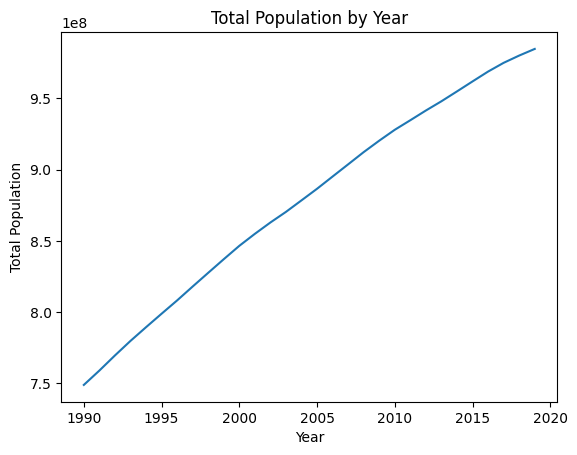

In [96]:
race_data.groupby('Year')['Total Population'].sum().plot(kind='line')
plt.title('Total Population by Year')
plt.xlabel('Year')
plt.ylabel('Total Population')

As expected we see population increasing over time. Let's look at each race over time.

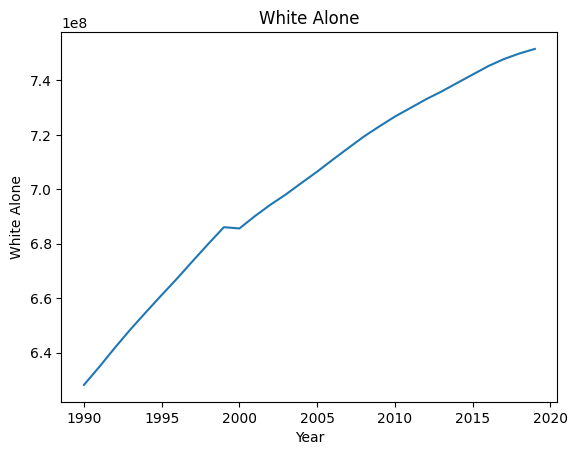

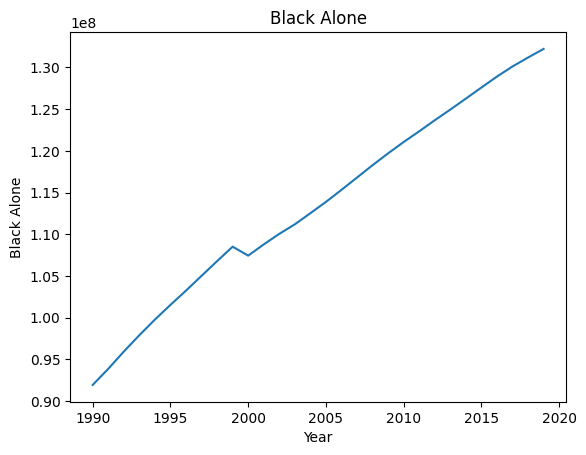

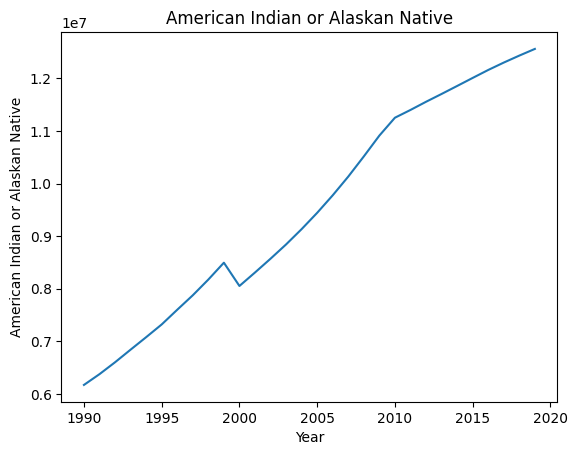

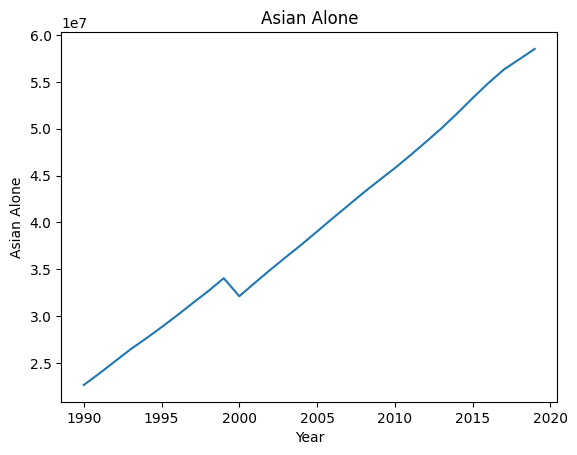

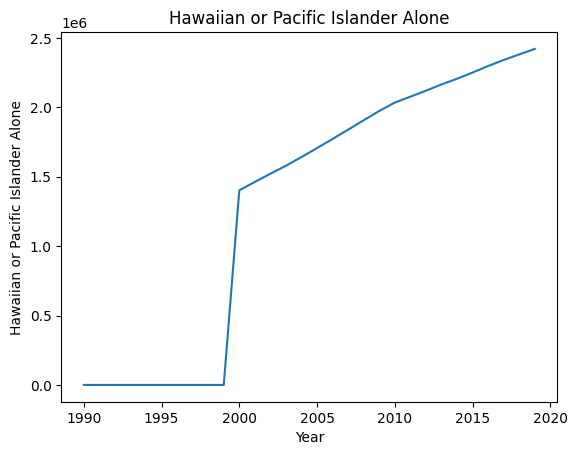

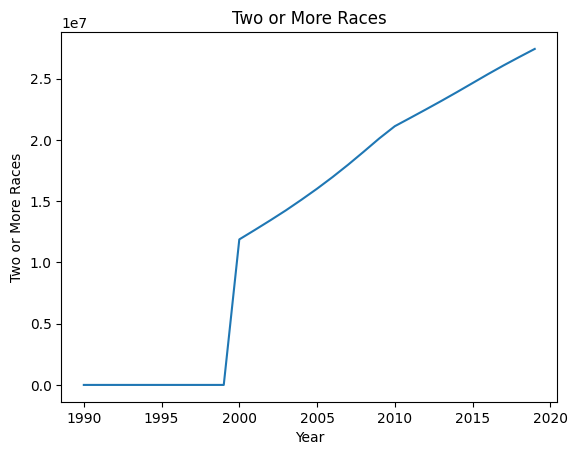

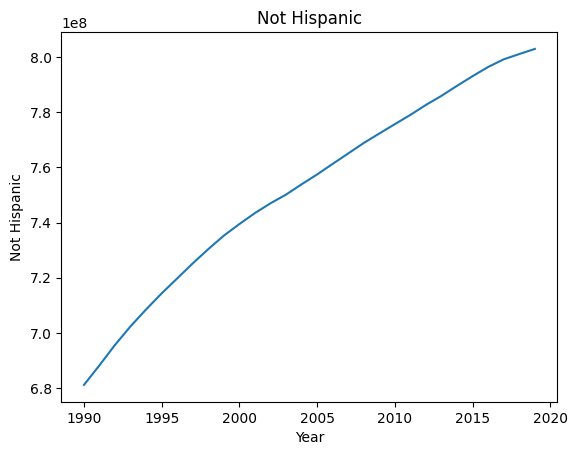

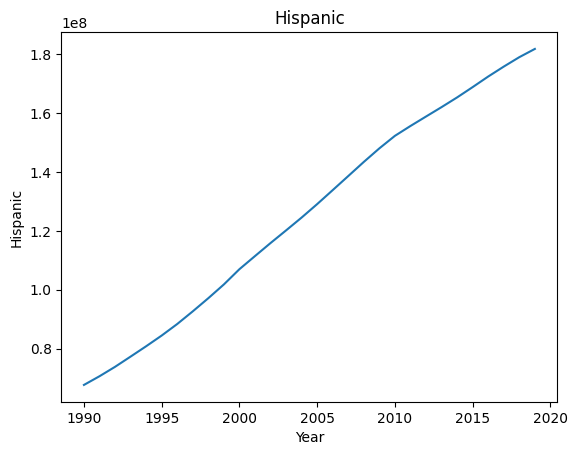

In [97]:
race_columns = ['White Alone', 'Black Alone', 'American Indian or Alaskan Native', 'Asian Alone', 'Hawaiian or Pacific Islander Alone', 'Two or More Races', 'Not Hispanic', 'Hispanic']

for col in race_columns:
  race_data.groupby('Year')[col].sum().plot(kind='line')
  plt.title(col)
  plt.xlabel('Year')
  plt.ylabel(col)
  plt.show()

In general we see that the populations of each group are trending upwards as expected. In the year 1999/2000 we see a sharp decrease in population which I am unable to source the reason why. I'd like to believe it is because many people thought the world was going to end in Y2K -
[link here](https://www.eonline.com/news/541614/remember-when-everyone-thought-the-world-was-going-to-end-with-y2k) However I have no proof of this so we will just accept the decline as is.



## Cleaning & EDA on Unemployment by County (x)

This data has information from 2000-2022

Because this data is structured in a way that makes it challenging to analyze. I will not be merging this dataset to the final table for this sprint.

Please move forward to the next section "Location Data Processing"

In [98]:
unemployment_data=pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/unemployment_data.csv')

In [99]:
unemployment_data.head()

FIPS_Code State           Area_Name  Rural_Urban_Continuum_Code_2013  \
0          0    US       United States                              NaN   
1       1000    AL             Alabama                              NaN   
2       1001    AL  Autauga County, AL                              2.0   
3       1003    AL  Baldwin County, AL                              3.0   
4       1005    AL  Barbour County, AL                              6.0   

   Urban_Influence_Code_2013  Metro_2013 Civilian_labor_force_2000  \
0                        NaN         NaN               142,601,576   
1                        NaN         NaN                 2,147,173   
2                        2.0         1.0                    21,861   
3                        2.0         1.0                    69,979   
4                        6.0         0.0                    11,449   

  Employed_2000 Unemployed_2000  Unemployment_rate_2000  \
0   136,904,853       5,696,723                     4.0   
1     2,047,731          99,442                     4.6   
2        20,971             890                     4.1   
3        67,370           2,609                     3.7   
4        10,812             637                     5.6   

  Civilian_labor_force_2001 Employed_2001 Unemployed_2001  \
0               143,786,537   136,977,996       6,808,541   
1                 2,128,027     2,017,467         110,560   
2                    22,081        21,166             915   
3                    69,569        66,545           3,024   
4                    11,324        10,468             856   

   Unemployment_rate_2001 Civilian_labor_force_2002 Employed_2002  \
0                     4.7               144,839,298   136,455,783   
1                     5.2                 2,112,621     1,987,633   
2                     4.1                    22,161        21,096   
3                     4.3                    69,379        65,881   
4                     7.6                    11,006        10,154   

  Unemployed_2002  Unemployment_rate_2002 Civilian_labor_force_2003  \
0       8,383,515                     5.8               145,660,094   
1         124,988                     5.9                 2,128,668   
2           1,065                     4.8                    22,695   
3           3,498                     5.0                    72,598   
4             852                     7.7                    11,019   

  Employed_2003 Unemployed_2003  Unemployment_rate_2003  \
0   136,944,522       8,715,572                     6.0   
1     2,001,568         127,100                     6.0   
2        21,557           1,138                     5.0   
3        69,010           3,588                     4.9   
4        10,241             778                     7.1   

  Civilian_labor_force_2004 Employed_2004 Unemployed_2004  \
0               146,724,795   138,613,904       8,110,891   
1                 2,138,306     2,018,783         119,523   
2                    23,241        22,146           1,095   
3                    74,843        71,061           3,782   
4                    10,639         9,884             755   

   Unemployment_rate_2004 Civilian_labor_force_2005 Employed_2005  \
0                     5.5               148,597,241   141,000,912   
1                     5.6                 2,140,356     2,045,234   
2                     4.7                    23,887        22,986   
3                     5.1                    76,608        73,581   
4                     7.1                    10,730        10,114   

  Unemployed_2005  Unemployment_rate_2005 Civilian_labor_force_2006  \
0       7,596,329                     5.1               150,707,773   
1          95,122                     4.4                 2,170,007   
2             901                     3.8                    24,425   
3           3,027                     4.0                    79,806   
4             616                     5.7                    10,713   

  E

In [100]:
unemployment_data.columns

Index(['FIPS_Code', 'State', 'Area_Name', 'Rural_Urban_Continuum_Code_2013',
       'Urban_Influence_Code_2013', 'Metro_2013', 'Civilian_labor_force_2000',
       'Employed_2000', 'Unemployed_2000', 'Unemployment_rate_2000',
       'Civilian_labor_force_2001', 'Employed_2001', 'Unemployed_2001',
       'Unemployment_rate_2001', 'Civilian_labor_force_2002', 'Employed_2002',
       'Unemployed_2002', 'Unemployment_rate_2002',
       'Civilian_labor_force_2003', 'Employed_2003', 'Unemployed_2003',
       'Unemployment_rate_2003', 'Civilian_labor_force_2004', 'Employed_2004',
       'Unemployed_2004', 'Unemployment_rate_2004',
       'Civilian_labor_force_2005', 'Employed_2005', 'Unemployed_2005',
       'Unemployment_rate_2005', 'Civilian_labor_force_2006', 'Employed_2006',
       'Unemployed_2006', 'Unemployment_rate_2006',
       'Civilian_labor_force_2007', 'Employed_2007', 'Unemployed_2007',
       'Unemployment_rate_2007', 'Civilian_labor_force_2008', 'Employed_2008',
       'Unemplo

We find that we have data from 2000-2022 which works well for our analysis. Let's check for nulls and duplicates

In [101]:
unemployment_data.duplicated().sum()

0

In [102]:
unemployment_data.isnull().sum()

FIPS_Code                                     0
State                                         0
Area_Name                                     0
Rural_Urban_Continuum_Code_2013              58
Urban_Influence_Code_2013                    58
                                             ..
Employed_2022                                 4
Unemployed_2022                               4
Unemployment_rate_2022                        4
Median_Household_Income_2021                 83
Med_HH_Income_Percent_of_State_Total_2021    84
Length: 100, dtype: int64

There are no duplicates but we find a number of nulls. Let's explore these nulls further starting with 'Med_HH_Income_Percent_of_State_Total_2021' since it has the highest amount.

In [103]:
unemployment_data.loc[unemployment_data['Med_HH_Income_Percent_of_State_Total_2021'].isna()]

FIPS_Code State                                        Area_Name  \
0             0    US                                    United States   
94         2201    AK  Prince of Wales-Outer Ketchikan Census Area, AK   
97         2232    AK            Skagway-Hoonah-Angoon Census Area, AK   
99         2261    AK                   Valdez-Cordova Census Area, AK   
101        2280    AK              Wrangell-Petersburg Census Area, AK   
...         ...   ...                                              ...   
3272      72145    PR                          Vega Baja Municipio, PR   
3273      72147    PR                            Vieques Municipio, PR   
3274      72149    PR                           Villalba Municipio, PR   
3275      72151    PR                            Yabucoa Municipio, PR   
3276      72153    PR                              Yauco Municipio, PR   

      Rural_Urban_Continuum_Code_2013  Urban_Influence_Code_2013  Metro_2013  \
0                                 NaN                        NaN         NaN   
94                                NaN                        NaN         0.0   
97                                NaN                        NaN         0.0   
99                                9.0                       11.0         0.0   
101                               NaN                        NaN         0.0   
...                               ...                        ...         ...   
3272                              1.0                        1.0         1.0   
3273                              7.0                       12.0         0.0   
3274                              2.0                        2.0         1.0   
3275                              1.0                        1.0         1.0   
3276                              2.0                        2.0         1.0   

     Civilian_labor_force_2000 Employed_2000 Unemployed_2000  \
0                  142,601,576   136,904,853       5,696,723   
94                       2,666         2,289             377   
97                       1,830         1,650             180   
99                       5,226         4,830             396   
101                      3,077         2,780             297   
...                        ...           ...             ...   
3272                    19,805        17,607           2,198   
3273                     2,441         2,120             321   
3274                     7,636         6,648             988   
3275                    10,613         9,005           1,608   
3276                    14,664        12,871           1,793   

      Unemployment_rate_2000 Civilian_labor_force_2001 Employed_2001  \
0                        4.0               143,786,537   136,977,996   
94                      14.1                     2,359         2,002   
97                       9.8                     1,840         1,626   
99                       7.6                     5,081         4,644   
101                      9.7                     3,038         2,731   
...                      ...                       ...           ...   
3272                    11.1                    19,554        17,138   
3273                    13.2                     2,323         1,999   
3274                    12.9                     7,564         6,546   
3275                    15.2                    10,751         8,746   
3276                    12.2                    14,416        12,475   

     Unemployed_2001  Unemployment_rate_2001 Civilian_labor_force_2002  \
0          6,808,541                     4.7               144,839,298   
94               357                    15.1                     2,354   
97               214                    11.6                     1,800   
99               437                     8.6                     5,205   
101              307                    10.1                     2,997   
...              ...                     ...                       ...   
3272

Interestingly enough we find that there are no columns similar to HH Median Income Percent of State Total in 2021 no other year has that attribute. For this reason I will explore dropping it.

In [104]:
unemployment_data = unemployment_data.drop(['Med_HH_Income_Percent_of_State_Total_2021'], axis=1)

Let's move on to our next null column Median Household income 2021. We find the same to be true there is no other column similar to this column so let's explore dropping it

In [105]:
unemployment_data.loc[unemployment_data['Median_Household_Income_2021'].isna()]

FIPS_Code State                                        Area_Name  \
94         2201    AK  Prince of Wales-Outer Ketchikan Census Area, AK   
97         2232    AK            Skagway-Hoonah-Angoon Census Area, AK   
99         2261    AK                   Valdez-Cordova Census Area, AK   
101        2280    AK              Wrangell-Petersburg Census Area, AK   
3198      72000    PR                                      Puerto Rico   
...         ...   ...                                              ...   
3272      72145    PR                          Vega Baja Municipio, PR   
3273      72147    PR                            Vieques Municipio, PR   
3274      72149    PR                           Villalba Municipio, PR   
3275      72151    PR                            Yabucoa Municipio, PR   
3276      72153    PR                              Yauco Municipio, PR   

      Rural_Urban_Continuum_Code_2013  Urban_Influence_Code_2013  Metro_2013  \
94                                NaN                        NaN         0.0   
97                                NaN                        NaN         0.0   
99                                9.0                       11.0         0.0   
101                               NaN                        NaN         0.0   
3198                              NaN                        NaN         NaN   
...                               ...                        ...         ...   
3272                              1.0                        1.0         1.0   
3273                              7.0                       12.0         0.0   
3274                              2.0                        2.0         1.0   
3275                              1.0                        1.0         1.0   
3276                              2.0                        2.0         1.0   

     Civilian_labor_force_2000 Employed_2000 Unemployed_2000  \
94                       2,666         2,289             377   
97                       1,830         1,650             180   
99                       5,226         4,830             396   
101                      3,077         2,780             297   
3198                 1,291,993     1,161,033         130,960   
...                        ...           ...             ...   
3272                    19,805        17,607           2,198   
3273                     2,441         2,120             321   
3274                     7,636         6,648             988   
3275                    10,613         9,005           1,608   
3276                    14,664        12,871           1,793   

      Unemployment_rate_2000 Civilian_labor_force_2001 Employed_2001  \
94                      14.1                     2,359         2,002   
97                       9.8                     1,840         1,626   
99                       7.6                     5,081         4,644   
101                      9.7                     3,038         2,731   
3198                    10.1                 1,273,405     1,128,704   
...                      ...                       ...           ...   
3272                    11.1                    19,554        17,138   
3273                    13.2                     2,323         1,999   
3274                    12.9                     7,564         6,546   
3275                    15.2                    10,751         8,746   
3276                    12.2                    14,416        12,475   

     Unemployed_2001  Unemployment_rate_2001 Civilian_labor_force_2002  \
94               357                    15.1                     2,354   
97               214                    11.6                     1,800   
99               437                     8.6                     5,205   
101              307                    10.1                     2,997   
3198         144,701                    11.4                 1,321,370   
...              ...                     ...                       ...   
3272

In [106]:
unemployment_data = unemployment_data.drop(['Median_Household_Income_2021'], axis=1)

In [107]:
unemployment_data.loc[unemployment_data['Employed_2022'].isna()]

FIPS_Code State                                        Area_Name  \
94        2201    AK  Prince of Wales-Outer Ketchikan Census Area, AK   
97        2232    AK            Skagway-Hoonah-Angoon Census Area, AK   
99        2261    AK                   Valdez-Cordova Census Area, AK   
101       2280    AK              Wrangell-Petersburg Census Area, AK   

     Rural_Urban_Continuum_Code_2013  Urban_Influence_Code_2013  Metro_2013  \
94                               NaN                        NaN         0.0   
97                               NaN                        NaN         0.0   
99                               9.0                       11.0         0.0   
101                              NaN                        NaN         0.0   

    Civilian_labor_force_2000 Employed_2000 Unemployed_2000  \
94                      2,666         2,289             377   
97                      1,830         1,650             180   
99                      5,226         4,830             396   
101                     3,077         2,780             297   

     Unemployment_rate_2000 Civilian_labor_force_2001 Employed_2001  \
94                     14.1                     2,359         2,002   
97                      9.8                     1,840         1,626   
99                      7.6                     5,081         4,644   
101                     9.7                     3,038         2,731   

    Unemployed_2001  Unemployment_rate_2001 Civilian_labor_force_2002  \
94              357                    15.1                     2,354   
97              214                    11.6                     1,800   
99              437                     8.6                     5,205   
101             307                    10.1                     2,997   

    Employed_2002 Unemployed_2002  Unemployment_rate_2002  \
94          1,991             363                    15.4   
97          1,581             219                    12.2   
99          4,697             508                     9.8   
101         2,662             335                    11.2   

    Civilian_labor_force_2003 Employed_2003 Unemployed_2003  \
94                      2,453         2,100             353   
97                      1,878         1,657             221   
99                      5,384         4,847             537   
101                     3,014         2,651             363   

     Unemployment_rate_2003 Civilian_labor_force_2004 Employed_2004  \
94                     14.4                     2,558         2,213   
97                     11.8                     1,766         1,533   
99                     10.0                     5,389         4,854   
101                    12.0                     2,923         2,562   

    Unemployed_2004  Unemployment_rate_2004 Civilian_labor_force_2005  \
94              345                    13.5                     2,566   
97              233                    13.2                     1,845   
99              535                     9.9                     5,259   
101             361                    12.4                     2,927   

    Employed_2005 Unemployed_2005  Unemployment_rate_2005  \
94          2,228             338                    13.2   
97          1,598             247                    13.4   
99          4,756             503                     9.6   
101         2,630             297                    10.1   

    Civilian_labor_force_2006 Employed_2006 Unemployed_2006  \
94                      2,347         2,011             336   
97                      1,893         1,652             241   
99                      5,177         4,735             442   
101                     2,899         2,622             277   

     Unemployment_rate_2006 Civilian_labor_force_2007 Employed_2007  \
94                     14.3                     2,269         1,964   
97                     12.7                     1,920         1,683   
99                      8.

## Location Pre-processing


Let's start the process of merging the data on location (FIP, ZIP, COUNTYNAME)


. First let's read in our converter tables. It contains the county name, zipcode, state and FIPS code.

In [108]:
zip2fip = pd.read_csv('/content/drive/MyDrive/Brainstation/Target Capstone /datasets/zip2fips.csv')
zip2fip.head()

ZIP      COUNTYNAME STATE  STCOUNTYFP CLASSFP
0  36003  Autauga County    AL        1001      H1
1  36006  Autauga County    AL        1001      H1
2  36067  Autauga County    AL        1001      H1
3  36066  Autauga County    AL        1001      H1
4  36703  Autauga County    AL        1001      H1

Let's ensure the data is clean by checking for nulls and duplicates

In [109]:
zip2fip.isnull().sum()

ZIP           0
COUNTYNAME    0
STATE         0
STCOUNTYFP    0
CLASSFP       0
dtype: int64

In [110]:
zip2fip.duplicated().sum()

0

There are no duplicates or nulls.

Let's now create a column called ZIP in the Target dataset by extracting it from the Formatted Address Column, this way we will be able to merge the datasets on ZIP and County name.

In [111]:
# extract ZIP code
raw_target_data_drop3['ZIP'] = raw_target_data_drop3['Address.FormattedAddress'].str.extract(' (\d{5})').astype(int)
raw_target_data_drop3.head()


Address.AddressLine1 Address.City Address.County  \
0  400 Oxford Exchange Blvd       Oxford        Calhoun   
1        2640 Enterprise Dr      Opelika            Lee   
2            1129 S Park St   Carrollton        Carroll   
3          555 Bullsboro Dr       Newnan         Coweta   
4      1591 Bradley Park Dr     Columbus       Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2    

Let's also strip the word 'County' from the county name on our converter table since the Target dataset only has the name in it ('Calhoun' vs 'Calhoun County')  

In [112]:
zip2fip['COUNTYNAME'] = zip2fip['COUNTYNAME'].str.replace(' County', '', regex=False)
zip2fip.head()

ZIP COUNTYNAME STATE  STCOUNTYFP CLASSFP
0  36003    Autauga    AL        1001      H1
1  36006    Autauga    AL        1001      H1
2  36067    Autauga    AL        1001      H1
3  36066    Autauga    AL        1001      H1
4  36703    Autauga    AL        1001      H1

In order to merge the columns on ZIP and County we will need to change the names of the columns so that they're matching.

In [113]:
raw_target_data_drop3.rename(columns={'Address.County': 'COUNTYNAME'}, inplace=True)
raw_target_data_drop3.head()

Address.AddressLine1 Address.City COUNTYNAME  \
0  400 Oxford Exchange Blvd       Oxford    Calhoun   
1        2640 Enterprise Dr      Opelika        Lee   
2            1129 S Park St   Carrollton    Carroll   
3          555 Bullsboro Dr       Newnan     Coweta   
4      1591 Bradley Park Dr     Columbus   Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2                     0      

##Merge Target & Household Debt to Income

Now that the data has been processed and analyzed,

Let's begin with merging the Target dataset to our first demographic dataset-- household debt to income ratio table.

In order to do so we will:
-  Merge the Target data to a converter table
-  Join the data on Quarter, Year, ZIP, and FIPS code
-  Make a new column 'LastMilestoneEvent' that has the last date something occurred at the target (opening or remodel) in order to work with the nulls in the 'Remodel' column (we want to preserve the nulls)


Let's begin by creating a copy of the cleaned dataset and we will call is 'clean_target' this way we can always refer back to the original cleaned dataset if needed.

In [114]:
clean_target = raw_target_data_drop3.copy()

Since we have nulls that we want to perserve in the 'LocationMilestones.LastRemodelDate' column we will create a new column 'LastMilestoneEvent' that contains the latest milestone event (for any Target that has not experienced a remodel the latest event will be the open date)

In [115]:
clean_target['LastMilestoneEvent'] = clean_target['LocationMilestones.LastRemodelDate'].fillna(clean_target['LocationMilestones.OpenDate'])
clean_target.head()

Address.AddressLine1 Address.City COUNTYNAME  \
0  400 Oxford Exchange Blvd       Oxford    Calhoun   
1        2640 Enterprise Dr      Opelika        Lee   
2            1129 S Park St   Carrollton    Carroll   
3          555 Bullsboro Dr       Newnan     Coweta   
4      1591 Bradley Park Dr     Columbus   Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2                     0      

In [116]:
clean_target.shape

(1829, 47)

Our household debt data has a column for each quarter and we'll need to merge on it so we will make a new column for quarter of the year

In [117]:
clean_target['Quarter'] = clean_target['LastMilestoneEvent'].dt.quarter
clean_target.head()

Address.AddressLine1 Address.City COUNTYNAME  \
0  400 Oxford Exchange Blvd       Oxford    Calhoun   
1        2640 Enterprise Dr      Opelika        Lee   
2            1129 S Park St   Carrollton    Carroll   
3          555 Bullsboro Dr       Newnan     Coweta   
4      1591 Bradley Park Dr     Columbus   Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2                     0      

Now let's add a Year  to join on since our household debt data also needs to be merged on 'Year'

In [118]:
clean_target['Year'] = clean_target['LastMilestoneEvent'].dt.year
clean_target.head()

Address.AddressLine1 Address.City COUNTYNAME  \
0  400 Oxford Exchange Blvd       Oxford    Calhoun   
1        2640 Enterprise Dr      Opelika        Lee   
2            1129 S Park St   Carrollton    Carroll   
3          555 Bullsboro Dr       Newnan     Coweta   
4      1591 Bradley Park Dr     Columbus   Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2                     0      

Let's check the new data types to ensure we have matching data types

In [119]:
clean_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Address.AddressLine1                1829 non-null   object        
 1   Address.City                        1829 non-null   object        
 2   COUNTYNAME                          1828 non-null   object        
 3   Address.FormattedAddress            1829 non-null   object        
 4   Address.Latitude                    1829 non-null   float64       
 5   Address.Longitude                   1829 non-null   float64       
 6   Address.PostalCode                  1829 non-null   object        
 7   Address.Subdivision                 1829 non-null   object        
 8   LocationMilestones.LastRemodelDate  1434 non-null   datetime64[ns]
 9   LocationMilestones.OpenDate         1829 non-null   datetime64[ns]
 10  Name                    

In [120]:
raw_debt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304406 entries, 0 to 304405
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   year       304406 non-null  int64         
 1   qtr        304406 non-null  int64         
 2   area_fips  304406 non-null  int64         
 3   low        304406 non-null  float64       
 4   high       304406 non-null  float64       
 5   date       304406 non-null  datetime64[ns]
 6   quarter    304406 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 16.3 MB


All data types needed to merge are the same (int 64)

Before we merge the data let's add a column isTarget that will help the ML model categorize locations with and without a Target store.

In [121]:
clean_target['isTarget'] = 1
clean_target.head()

Address.AddressLine1 Address.City COUNTYNAME  \
0  400 Oxford Exchange Blvd       Oxford    Calhoun   
1        2640 Enterprise Dr      Opelika        Lee   
2            1129 S Park St   Carrollton    Carroll   
3          555 Bullsboro Dr       Newnan     Coweta   
4      1591 Bradley Park Dr     Columbus   Muscogee   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
2        1129 S Park St, Carrollton, GA 30117-4429         33.558920   
3          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
4    1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   

   Address.Longitude Address.PostalCode Address.Subdivision  \
0         -85.783182         36203-3459                  AL   
1         -85.410636         36801-1511                  AL   
2         -85.076473         30117-4429                  GA   
3         -84.758875         30265-1045                  GA   
4         -84.971073         31904-3071                  GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2005-07-20 12:00:00     Opelika   
2                                NaT         1997-07-23 12:00:00  Carrollton   
3                2013-06-27 12:00:00         1999-10-06 12:00:00      Newnan   
4                2004-10-17 12:00:00         1999-03-03 12:00:00    Columbus   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                    340                 394                  300   
1                    340                 394                  300   
2                    336                 394                  300   
3                    336                 394                  300   
4                    340                 394                  300   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR          0                                0   
1            Regular      STR          0                                0   
2            Regular      STR          0                                0   
3            Regular      STR          1                                0   
4            Regular      STR          1                                0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                    0            0       0                 0     0   
1                    0            0       0                 0     0   
2                    0            0       0                 0     0   
3                    0            0       0                 0     0   
4                    0            0       0                 0     0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0               0             1           0     1             0   
1               0             1           1     0             0   
2               0             0           0     0             0   
3               0             1           0     1             0   
4               0             1           0     1             0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                                 0     0         0              0   
1                                 0     0         0              1   
2                                 0     0         0              0   
3                                 0     0         0              1   
4                                 0     0         0              0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                     0             0             1        0          0   
1                     0             0             1        0          0   
2                     0      

Let's check for any nulls

In [122]:
clean_target.isnull().sum()

Address.AddressLine1                    0
Address.City                            0
COUNTYNAME                              1
Address.FormattedAddress                0
Address.Latitude                        0
Address.Longitude                       0
Address.PostalCode                      0
Address.Subdivision                     0
LocationMilestones.LastRemodelDate    395
LocationMilestones.OpenDate             0
Name                                    0
Store.StoreDistrictID                   0
Store.StoreGroupID                      0
Store.StoreRegionID                     0
SubTypeDescription                      0
TypeCode                                0
Remodeled                               0
"DAmico & Sons Italian Kitchen"         0
& Spirits Available                     0
Accepts WIC                             0
Bakery                                  0
Beauty Concierge                        0
Beer                                    0
Beer Available                    

We see COUNTYNAME has 1 unexpected Null and Remodel has 395 expected nulls.

In [123]:
clean_target[clean_target['COUNTYNAME'].isnull()]

Address.AddressLine1 Address.City COUNTYNAME  \
831     255 Greenwich St     New York        NaN   

                      Address.FormattedAddress  Address.Latitude  \
831  255 Greenwich St, New York, NY 10007-2377           40.7147   

     Address.Longitude Address.PostalCode Address.Subdivision  \
831           -74.0112         10007-2377                  NY   

    LocationMilestones.LastRemodelDate LocationMilestones.OpenDate     Name  \
831                                NaT         2016-10-05 12:00:00  Tribeca   

     Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
831                    423                 496                  400   

    SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
831      TargetExpress      STR          0                                0   

     & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
831                    0            0       0                 1     0   

     Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
831               1             1           0     0             1   

     Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
831                                 0     0         0              1   

     In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
831                     0             0             1        0          0   

     Pizza Hut Salads and Snacks  Starbucks  Sun Boutique  Super Target  \
831                            0          0             0             0   

     Which Wich Superior Sandwiches  Wine  Wine & Beer Available  \
831                               0     0                      0   

     Wine Available    ZIP  LastMilestoneEvent  Quarter  Year  isTarget  
831               0  10007 2016-10-05 12:00:00        4  2016         1

We find that the City is New York. Since this is in NYC the county name will also be New York let's confirm this with other Targets located in NYC.

In [124]:
clean_target[clean_target['Address.City'] == 'New York']

Address.AddressLine1 Address.City COUNTYNAME  \
820   517 E 117th Street     New York   New York   
828        112 W 34th St     New York   New York   
831     255 Greenwich St     New York        NaN   

                        Address.FormattedAddress  Address.Latitude  \
820  517 E 117th Street, New York, NY 10035-4410         40.795561   
828       112 W 34th St, New York, NY 10120-0101         40.750245   
831    255 Greenwich St, New York, NY 10007-2377         40.714700   

     Address.Longitude Address.PostalCode Address.Subdivision  \
820         -73.931192         10035-4410                  NY   
828         -73.989309         10120-0101                  NY   
831         -74.011200         10007-2377                  NY   

    LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
820                                NaT         2010-07-21 12:00:00   
828                                NaT         2017-10-19 12:00:00   
831                                NaT         2016-10-05 12:00:00   

                        Name  Store.StoreDistrictID  Store.StoreGroupID  \
820                   Harlem                    469                 496   
828  Manhattan Herald Square                    423                 496   
831                  Tribeca                    423                 496   

     Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
820                  400            Regular      STR          0   
828                  400      TargetExpress      STR          0   
831                  400      TargetExpress      STR          0   

     "DAmico & Sons Italian Kitchen"  & Spirits Available  Accepts WIC  \
820                                0                    0            1   
828                                0                    0            0   
831                                0                    0            0   

     Bakery  Beauty Concierge  Beer  Beer Available  CVS pharmacy  Cafe-Pizza  \
820       0                 1     0               1             0           1   
828       0                 1     0               1             1           0   
831       0                 1     0               1             1           0   

     Café  Chobani Cafe  Clinic care by Kaiser Permanente  Deli  Drive Up  \
820     0             0                                 0     0         0   
828     0             0                                 0     0         0   
831     0             1                                 0     0         0   

     Fresh Grocery  In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  \
820              1                     1             0             1        0   
828              1                     0             0             1        0   
831              1                     0             0             1        0   

     Photo Lab  Pizza Hut Salads and Snacks  Starbucks  Sun Boutique  \
820          1                            0          1             0   
828          0                            0          0             0   
831          0                            0          0             0   

     Super Target  Which Wich Superior Sandwiches  Wine  \
820             0                               0     0   
828             0                               0     0   
831             0                               0     0   

     Wine & Beer Available  Wine Available    ZIP  LastMilestoneEvent  \
820                      0               0  10035 2010-07-21 12:00:00   
828                      0               0  10120 2017-10-19 12:00:00   
831                      0               0  10007 2016-10-05 12:00:00   

     Quarter  Year  isTarget  
820        3  2010         1  
828        4  2017         1  
831        4  2016         1

Let's fill the null county name with 'New York'

In [125]:
clean_target['COUNTYNAME'].fillna('NY', inplace=True)


Let's also change 'Address.Subdivision' to 'State' so that we can merge.

In [126]:
clean_target.rename(columns={'Address.Subdivision': 'STATE'}, inplace=True)


Now let's merge Target data and the converter table. We will be using an outer join because we want to preserve all of the target locations as well as any locations without a target so that we can evaluate the differences in demographics.

We will merge on the zipcode since that it is on the county level and I've noticed some inconsistencies in how the county name was written out so we will rely on zipcode.

In [127]:
merged_data = pd.merge(clean_target, zip2fip, how='outer',on=['ZIP'])
merged_data.head(100)

Address.AddressLine1 Address.City COUNTYNAME_x  \
0   400 Oxford Exchange Blvd       Oxford      Calhoun   
1   400 Oxford Exchange Blvd       Oxford      Calhoun   
2         2640 Enterprise Dr      Opelika          Lee   
3         2640 Enterprise Dr      Opelika          Lee   
4             1129 S Park St   Carrollton      Carroll   
..                       ...          ...          ...   
95          3065 Atlanta Hwy       Athens       Clarke   
96          3065 Atlanta Hwy       Athens       Clarke   
97          5579 Highway 153       Hixson     Hamilton   
98       4570 Frontage Rd NW    Cleveland      Bradley   
99        372 Cox Creek Pkwy     Florence   Lauderdale   

                           Address.FormattedAddress  Address.Latitude  \
0   400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1   400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2        2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3        2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4         1129 S Park St, Carrollton, GA 30117-4429         33.558920   
..                                              ...               ...   
95          3065 Atlanta Hwy, Athens, GA 30606-3334         33.941502   
96          3065 Atlanta Hwy, Athens, GA 30606-3334         33.941502   
97          5579 Highway 153, Hixson, TN 37343-3748         35.146420   
98    4570 Frontage Rd NW, Cleveland, TN 37312-2905         35.217441   
99      372 Cox Creek Pkwy, Florence, AL 35630-1540         34.842130   

    Address.Longitude Address.PostalCode STATE_x  \
0          -85.783182         36203-3459      AL   
1          -85.783182         36203-3459      AL   
2          -85.410636         36801-1511      AL   
3          -85.410636         36801-1511      AL   
4          -85.076473         30117-4429      GA   
..                ...                ...     ...   
95         -83.440390         30606-3334      GA   
96         -83.440390         30606-3334      GA   
97         -85.251508         37343-3748      TN   
98         -84.866113         37312-2905      TN   
99         -87.634764         35630-1540      AL   

   LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
0                                 NaT         2006-07-19 12:00:00   
1                                 NaT         2006-07-19 12:00:00   
2                                 NaT         2005-07-20 12:00:00   
3                                 NaT         2005-07-20 12:00:00   
4                                 NaT         1997-07-23 12:00:00   
..                                ...                         ...   
95                2012-03-22 12:00:00         2003-10-08 12:00:00   
96                2012-03-22 12:00:00         2003-10-08 12:00:00   
97                2012-03-22 12:00:00         2005-10-05 12:00:00   
98                                NaT         2008-03-05 12:00:00   
99                2007-07-13 12:00:00         2001-03-07 12:00:00   

                 Name  Store.StoreDistrictID  Store.StoreGroupID  \
0              Oxford                  340.0               394.0   
1              Oxford                  340.0               394.0   
2             Opelika                  340.0               394.0   
3             Opelika                  340.0               394.0   
4          Carrollton                  336.0               394.0   
..                ...                    ...                 ...   
95             Athens                  346.0               394.0   
96             Athens                  346.0               394.0   
97  Chattanooga North                  333.0               394.0   
98          Cleveland                  333.0               394.0   
99           Florence                  369.0               394.0   

    Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
0                 300.0            Regular      STR        0.0   
1                 300.0        

In [128]:
merged_data.shape

(52957, 54)

We see that the shape of the data has become much larger which is expected.
Let's check for Nulls, we expect to see many within the target data set since there are more counties than Target stores.

In [129]:
merged_data.isnull().sum()

Address.AddressLine1                  50590
Address.City                          50590
COUNTYNAME_x                          50590
Address.FormattedAddress              50590
Address.Latitude                      50590
Address.Longitude                     50590
Address.PostalCode                    50590
STATE_x                               50590
LocationMilestones.LastRemodelDate    51115
LocationMilestones.OpenDate           50590
Name                                  50590
Store.StoreDistrictID                 50590
Store.StoreGroupID                    50590
Store.StoreRegionID                   50590
SubTypeDescription                    50590
TypeCode                              50590
Remodeled                             50590
"DAmico & Sons Italian Kitchen"       50590
& Spirits Available                   50590
Accepts WIC                           50590
Bakery                                50590
Beauty Concierge                      50590
Beer                            

Let's dig deeper into some of the nulls that are unexpected
*  STATE                                    1
*  STCOUNTYFP                               1
*  CLASSFP                                  1





In [130]:
merged_data[merged_data['STATE_y'].isnull()]

Address.AddressLine1     Address.City COUNTYNAME_x  \
1876  N95 W 17707 Shady Ln  Menomonee Falls     Waukesha   

                               Address.FormattedAddress  Address.Latitude  \
1876  N95 W 17707 Shady Ln, Menomonee Falls, WI 5305...         43.189642   

      Address.Longitude Address.PostalCode STATE_x  \
1876         -88.129009         53051-8012      WI   

     LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
1876                2011-03-24 12:00:00         1994-03-09 12:00:00   

                 Name  Store.StoreDistrictID  Store.StoreGroupID  \
1876  Menomonee Falls                  128.0               196.0   

      Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
1876                100.0            Regular      STR        1.0   

      "DAmico & Sons Italian Kitchen"  & Spirits Available  Accepts WIC  \
1876                              0.0                  0.0          1.0   

      Bakery  Beauty Concierge  Beer  Beer Available  CVS pharmacy  \
1876     0.0               0.0   0.0             0.0           1.0   

      Cafe-Pizza  Café  Chobani Cafe  Clinic care by Kaiser Permanente  Deli  \
1876         1.0   0.0           0.0                               0.0   0.0   

      Drive Up  Fresh Grocery  In-Store Apple Store  MinuteClinic  \
1876       0.0            1.0                   0.0           0.0   

      Mobile Kiosk  Optical  Photo Lab  Pizza Hut Salads and Snacks  \
1876           1.0      0.0        1.0                          0.0   

      Starbucks  Sun Boutique  Super Target  Which Wich Superior Sandwiches  \
1876        1.0           0.0           0.0                             0.0   

      Wine  Wine & Beer Available  Wine Available    ZIP  LastMilestoneEvent  \
1876   0.0                    0.0             0.0  17707 2011-03-24 12:00:00   

      Quarter    Year  isTarget COUNTYNAME_y STATE_y  STCOUNTYFP CLASSFP  
1876      1.0  2011.0       1.0          NaN     NaN         NaN     NaN

In [131]:
merged_data[merged_data['STCOUNTYFP'].isnull()]

Address.AddressLine1     Address.City COUNTYNAME_x  \
1876  N95 W 17707 Shady Ln  Menomonee Falls     Waukesha   

                               Address.FormattedAddress  Address.Latitude  \
1876  N95 W 17707 Shady Ln, Menomonee Falls, WI 5305...         43.189642   

      Address.Longitude Address.PostalCode STATE_x  \
1876         -88.129009         53051-8012      WI   

     LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
1876                2011-03-24 12:00:00         1994-03-09 12:00:00   

                 Name  Store.StoreDistrictID  Store.StoreGroupID  \
1876  Menomonee Falls                  128.0               196.0   

      Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
1876                100.0            Regular      STR        1.0   

      "DAmico & Sons Italian Kitchen"  & Spirits Available  Accepts WIC  \
1876                              0.0                  0.0          1.0   

      Bakery  Beauty Concierge  Beer  Beer Available  CVS pharmacy  \
1876     0.0               0.0   0.0             0.0           1.0   

      Cafe-Pizza  Café  Chobani Cafe  Clinic care by Kaiser Permanente  Deli  \
1876         1.0   0.0           0.0                               0.0   0.0   

      Drive Up  Fresh Grocery  In-Store Apple Store  MinuteClinic  \
1876       0.0            1.0                   0.0           0.0   

      Mobile Kiosk  Optical  Photo Lab  Pizza Hut Salads and Snacks  \
1876           1.0      0.0        1.0                          0.0   

      Starbucks  Sun Boutique  Super Target  Which Wich Superior Sandwiches  \
1876        1.0           0.0           0.0                             0.0   

      Wine  Wine & Beer Available  Wine Available    ZIP  LastMilestoneEvent  \
1876   0.0                    0.0             0.0  17707 2011-03-24 12:00:00   

      Quarter    Year  isTarget COUNTYNAME_y STATE_y  STCOUNTYFP CLASSFP  
1876      1.0  2011.0       1.0          NaN     NaN         NaN     NaN

In [132]:
merged_data[merged_data['CLASSFP'].isnull()]

Address.AddressLine1     Address.City COUNTYNAME_x  \
1876  N95 W 17707 Shady Ln  Menomonee Falls     Waukesha   

                               Address.FormattedAddress  Address.Latitude  \
1876  N95 W 17707 Shady Ln, Menomonee Falls, WI 5305...         43.189642   

      Address.Longitude Address.PostalCode STATE_x  \
1876         -88.129009         53051-8012      WI   

     LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
1876                2011-03-24 12:00:00         1994-03-09 12:00:00   

                 Name  Store.StoreDistrictID  Store.StoreGroupID  \
1876  Menomonee Falls                  128.0               196.0   

      Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
1876                100.0            Regular      STR        1.0   

      "DAmico & Sons Italian Kitchen"  & Spirits Available  Accepts WIC  \
1876                              0.0                  0.0          1.0   

      Bakery  Beauty Concierge  Beer  Beer Available  CVS pharmacy  \
1876     0.0               0.0   0.0             0.0           1.0   

      Cafe-Pizza  Café  Chobani Cafe  Clinic care by Kaiser Permanente  Deli  \
1876         1.0   0.0           0.0                               0.0   0.0   

      Drive Up  Fresh Grocery  In-Store Apple Store  MinuteClinic  \
1876       0.0            1.0                   0.0           0.0   

      Mobile Kiosk  Optical  Photo Lab  Pizza Hut Salads and Snacks  \
1876           1.0      0.0        1.0                          0.0   

      Starbucks  Sun Boutique  Super Target  Which Wich Superior Sandwiches  \
1876        1.0           0.0           0.0                             0.0   

      Wine  Wine & Beer Available  Wine Available    ZIP  LastMilestoneEvent  \
1876   0.0                    0.0             0.0  17707 2011-03-24 12:00:00   

      Quarter    Year  isTarget COUNTYNAME_y STATE_y  STCOUNTYFP CLASSFP  
1876      1.0  2011.0       1.0          NaN     NaN         NaN     NaN

We see that the nulls are all the same row of data. Because we don't want to lose any of the target data we will fill this information in.

We see that the state is WI, the county name is Waukesha, and the FIPS code is 55133. We actually won't need the ClassFP column so we can drop it.



In [133]:
merged_data['STATE_y'].fillna('WI', inplace=True)
merged_data['STCOUNTYFP'].fillna('55133', inplace=True)
merged_data['COUNTYNAME_y'].fillna('Waukesha', inplace=True)

In [134]:
merged_data.drop(columns=['CLASSFP'], inplace=True)

In [135]:
merged_data.isnull().sum()

Address.AddressLine1                  50590
Address.City                          50590
COUNTYNAME_x                          50590
Address.FormattedAddress              50590
Address.Latitude                      50590
Address.Longitude                     50590
Address.PostalCode                    50590
STATE_x                               50590
LocationMilestones.LastRemodelDate    51115
LocationMilestones.OpenDate           50590
Name                                  50590
Store.StoreDistrictID                 50590
Store.StoreGroupID                    50590
Store.StoreRegionID                   50590
SubTypeDescription                    50590
TypeCode                              50590
Remodeled                             50590
"DAmico & Sons Italian Kitchen"       50590
& Spirits Available                   50590
Accepts WIC                           50590
Bakery                                50590
Beauty Concierge                      50590
Beer                            

Next let's merge the House Hold Debt data to the Merged Target Data.

Let's change the name of the STCOUNTYFP to FIP inorder to merge

In [136]:
merged_data.rename(columns={'STCOUNTYFP': 'FIP'}, inplace=True)
merged_data.head()

Address.AddressLine1 Address.City COUNTYNAME_x  \
0  400 Oxford Exchange Blvd       Oxford      Calhoun   
1  400 Oxford Exchange Blvd       Oxford      Calhoun   
2        2640 Enterprise Dr      Opelika          Lee   
3        2640 Enterprise Dr      Opelika          Lee   
4            1129 S Park St   Carrollton      Carroll   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4        1129 S Park St, Carrollton, GA 30117-4429         33.558920   

   Address.Longitude Address.PostalCode STATE_x  \
0         -85.783182         36203-3459      AL   
1         -85.783182         36203-3459      AL   
2         -85.410636         36801-1511      AL   
3         -85.410636         36801-1511      AL   
4         -85.076473         30117-4429      GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate        Name  \
0                                NaT         2006-07-19 12:00:00      Oxford   
1                                NaT         2006-07-19 12:00:00      Oxford   
2                                NaT         2005-07-20 12:00:00     Opelika   
3                                NaT         2005-07-20 12:00:00     Opelika   
4                                NaT         1997-07-23 12:00:00  Carrollton   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                  340.0               394.0                300.0   
1                  340.0               394.0                300.0   
2                  340.0               394.0                300.0   
3                  340.0               394.0                300.0   
4                  336.0               394.0                300.0   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR        0.0                              0.0   
1            Regular      STR        0.0                              0.0   
2            Regular      STR        0.0                              0.0   
3            Regular      STR        0.0                              0.0   
4            Regular      STR        0.0                              0.0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                  0.0          0.0     0.0               0.0   0.0   
1                  0.0          0.0     0.0               0.0   0.0   
2                  0.0          0.0     0.0               0.0   0.0   
3                  0.0          0.0     0.0               0.0   0.0   
4                  0.0          0.0     0.0               0.0   0.0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0             0.0           1.0         0.0   1.0           0.0   
1             0.0           1.0         0.0   1.0           0.0   
2             0.0           1.0         1.0   0.0           0.0   
3             0.0           1.0         1.0   0.0           0.0   
4             0.0           0.0         0.0   0.0           0.0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                               0.0   0.0       0.0            0.0   
1                               0.0   0.0       0.0            0.0   
2                               0.0   0.0       0.0            1.0   
3                               0.0   0.0       0.0            1.0   
4                               0.0   0.0       0.0            0.0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                   0.0           0.0           1.0      0.0        0.0   
1                   0.0           0.0           1.0      0.0        0.0   
2                   0.0           0.0           1.0      0.0        0.0   
3             

Let's ensure the data types are the same so that we can merge

In [137]:
merged_data.dtypes

Address.AddressLine1                          object
Address.City                                  object
COUNTYNAME_x                                  object
Address.FormattedAddress                      object
Address.Latitude                             float64
Address.Longitude                            float64
Address.PostalCode                            object
STATE_x                                       object
LocationMilestones.LastRemodelDate    datetime64[ns]
LocationMilestones.OpenDate           datetime64[ns]
Name                                          object
Store.StoreDistrictID                        float64
Store.StoreGroupID                           float64
Store.StoreRegionID                          float64
SubTypeDescription                            object
TypeCode                                      object
Remodeled                                    float64
"DAmico & Sons Italian Kitchen"              float64
& Spirits Available                          f

In [138]:
raw_debt_data.dtypes

year                  int64
qtr                   int64
area_fips             int64
low                 float64
high                float64
date         datetime64[ns]
quarter               int64
dtype: object

We see that FIP has two different data types so let's convert the Target/Merged FIPs to int64

In [139]:

merged_data['FIP'] = merged_data['FIP'].astype('int64')


Let's change the household debt data columns to match with our other datasets so that we can merge

In [140]:
raw_debt_data.rename(columns={'area_fips': 'FIP'}, inplace=True)
raw_debt_data.rename(columns={'year': 'Year'}, inplace=True)
raw_debt_data.rename(columns={'quarter': 'Quarter'}, inplace=True)
raw_debt_data.head()

Year  qtr   FIP   low  high       date  Quarter
0  1999    1  1001  1.82  2.15 1999-01-01        1
1  1999    1  1003  1.82  2.15 1999-01-01        1
2  1999    1  1005  0.00  0.78 1999-01-01        1
3  1999    1  1007  2.61  3.43 1999-01-01        1
4  1999    1  1009  2.15  2.61 1999-01-01        1

Due to time restraints I will perform and inner join on the data

In [141]:
merged_data_2 = pd.merge(merged_data, raw_debt_data, how='inner', on=['FIP', 'Year', 'Quarter'])
merged_data_2.head()

Address.AddressLine1 Address.City COUNTYNAME_x  \
0  400 Oxford Exchange Blvd       Oxford      Calhoun   
1  400 Oxford Exchange Blvd       Oxford      Calhoun   
2        2640 Enterprise Dr      Opelika          Lee   
3        2640 Enterprise Dr      Opelika          Lee   
4          555 Bullsboro Dr       Newnan       Coweta   

                          Address.FormattedAddress  Address.Latitude  \
0  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1  400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3       2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4          555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   

   Address.Longitude Address.PostalCode STATE_x  \
0         -85.783182         36203-3459      AL   
1         -85.783182         36203-3459      AL   
2         -85.410636         36801-1511      AL   
3         -85.410636         36801-1511      AL   
4         -84.758875         30265-1045      GA   

  LocationMilestones.LastRemodelDate LocationMilestones.OpenDate     Name  \
0                                NaT         2006-07-19 12:00:00   Oxford   
1                                NaT         2006-07-19 12:00:00   Oxford   
2                                NaT         2005-07-20 12:00:00  Opelika   
3                                NaT         2005-07-20 12:00:00  Opelika   
4                2013-06-27 12:00:00         1999-10-06 12:00:00   Newnan   

   Store.StoreDistrictID  Store.StoreGroupID  Store.StoreRegionID  \
0                  340.0               394.0                300.0   
1                  340.0               394.0                300.0   
2                  340.0               394.0                300.0   
3                  340.0               394.0                300.0   
4                  336.0               394.0                300.0   

  SubTypeDescription TypeCode  Remodeled  "DAmico & Sons Italian Kitchen"  \
0            Regular      STR        0.0                              0.0   
1            Regular      STR        0.0                              0.0   
2            Regular      STR        0.0                              0.0   
3            Regular      STR        0.0                              0.0   
4            Regular      STR        1.0                              0.0   

   & Spirits Available  Accepts WIC  Bakery  Beauty Concierge  Beer  \
0                  0.0          0.0     0.0               0.0   0.0   
1                  0.0          0.0     0.0               0.0   0.0   
2                  0.0          0.0     0.0               0.0   0.0   
3                  0.0          0.0     0.0               0.0   0.0   
4                  0.0          0.0     0.0               0.0   0.0   

   Beer Available  CVS pharmacy  Cafe-Pizza  Café  Chobani Cafe  \
0             0.0           1.0         0.0   1.0           0.0   
1             0.0           1.0         0.0   1.0           0.0   
2             0.0           1.0         1.0   0.0           0.0   
3             0.0           1.0         1.0   0.0           0.0   
4             0.0           1.0         0.0   1.0           0.0   

   Clinic care by Kaiser Permanente  Deli  Drive Up  Fresh Grocery  \
0                               0.0   0.0       0.0            0.0   
1                               0.0   0.0       0.0            0.0   
2                               0.0   0.0       0.0            1.0   
3                               0.0   0.0       0.0            1.0   
4                               0.0   0.0       0.0            1.0   

   In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  Photo Lab  \
0                   0.0           0.0           1.0      0.0        0.0   
1                   0.0           0.0           1.0      0.0        0.0   
2                   0.0           0.0           1.0      0.0        0.0   
3                   0.0         

In [142]:
merged_data_2.isnull().sum()

Address.AddressLine1                    0
Address.City                            0
COUNTYNAME_x                            0
Address.FormattedAddress                0
Address.Latitude                        0
Address.Longitude                       0
Address.PostalCode                      0
STATE_x                                 0
LocationMilestones.LastRemodelDate    512
LocationMilestones.OpenDate             0
Name                                    0
Store.StoreDistrictID                   0
Store.StoreGroupID                      0
Store.StoreRegionID                     0
SubTypeDescription                      0
TypeCode                                0
Remodeled                               0
"DAmico & Sons Italian Kitchen"         0
& Spirits Available                     0
Accepts WIC                             0
Bakery                                  0
Beauty Concierge                        0
Beer                                    0
Beer Available                    

In [143]:
merged_data_2.shape

(2351, 57)

## Merge Data by Age/Sex

Now that we have merged the Target dataset and the household debt to income ratio data. Let's add additional datasets starting with Age and sex data

In [144]:
pop_age_sex.head(100)

IBRC_Geo_ID  Statefips  Countyfips         Description       Year  \
0             0          0           0                U.S. 2000-01-01   
1             0          0           0                U.S. 2001-01-01   
2             0          0           0                U.S. 2002-01-01   
3             0          0           0                U.S. 2003-01-01   
4             0          0           0                U.S. 2004-01-01   
..          ...        ...         ...                 ...        ...   
95         1005          1           5  Barbour County, AL 2015-01-01   
96         1005          1           5  Barbour County, AL 2016-01-01   
97         1005          1           5  Barbour County, AL 2017-01-01   
98         1005          1           5  Barbour County, AL 2018-01-01   
99         1005          1           5  Barbour County, AL 2019-01-01   

    Total Population  Population 0-4  Population 5-17  Population 18-24  \
0        282162411.0      19178293.0       53197896.0        27315274.0   
1        284968955.0      19298217.0       53372958.0        27992652.0   
2        287625193.0      19429192.0       53507265.0        28480708.0   
3        290107933.0      19592446.0       53508312.0        28916746.0   
4        292805298.0      19785885.0       53511850.0        29302179.0   
..               ...             ...              ...               ...   
95           26283.0          1453.0           4131.0            2234.0   
96           25806.0          1386.0           4099.0            2150.0   
97           25157.0          1317.0           3946.0            2021.0   
98           24872.0          1294.0           3917.0            1971.0   
99           24686.0          1309.0           3773.0            2000.0   

    Population 25-44  Population 45-64  Population 65+  Population Under 18  \
0         84973340.0        62428040.0      35069568.0           72376189.0   
1         84523274.0        64491563.0      35290291.0           72671175.0   
2         83990295.0        66695526.0      35522207.0           72936457.0   
3         83398001.0        68828899.0      35863529.0           73100758.0   
4         83066831.0        70935234.0      36203319.0           73297735.0   
..               ...               ...             ...                  ...   
95            6993.0            6917.0          4555.0               5584.0   
96            6770.0            6727.0          4674.0               5485.0   
97            6522.0            6585.0          4766.0               5263.0   
98            6419.0            6447.0          4824.0               5211.0   
99            6412.0            6331.0          4861.0               5082.0   

    Population 18-54  Population 55+  Male Population  Female Population  \
0        150287588.0      59498634.0      138443407.0        143719004.0   
1        151902194.0      60395586.0      139891492.0        145077463.0   
2        152463197.0      62225539.0      141230559.0        146394634.0   
3        153134701.0      63872474.0      142428897.0        147679036.0   
4        153998940.0      65508623.0      143828012.0        148977286.0   
..               ...             ...              ...                ...   
95           12791.0          7908.0          13985.0            12315.0   
96           12343.0          7978.0          13637.0            12191.0   
97           11851.0          8043.0          13228.0            11941.0   
98           11608.0          8053.0          13157.0            11730.0   
99           11494.0          8110.0          13030.0            11627.0   

    Population Growth  
0                 NaN  
1            0.009947  
2            0.009321  
3            0.008632  
4            0.009298  
..                ...  
95          -0.017642  
96          -0.018149  
97          -0.025149  
98          -0.011329  
99          -0.007478  

[100 rows x 18 columns]

Looking at the data in order to merge we will need to merge on the Year, the county, and the FIPS code. Something to note is that the household income data is per quarter while age and population is by year. I will assume that the QoQ data doesn't fluctuate too much and will be okay with the data being the same for each quarter as long as the year is aligned.

In order to merge these are the steps that we will take:

1. Pre-process fields to be able to merge (format 'Year', remove 'County' from County Name)
2. Ensure the columns are the same name
3. Merge!


Let's begin with formatting the Year column currently it is a date time format and has the date for the 1st of the year so we can easily pull the Year from the Age by County data


In [145]:
pop_age_sex['Year'] = pop_age_sex['Year'].dt.year

In [146]:
pop_age_sex.head(50)


IBRC_Geo_ID  Statefips  Countyfips         Description  Year  \
0             0          0           0                U.S.  2000   
1             0          0           0                U.S.  2001   
2             0          0           0                U.S.  2002   
3             0          0           0                U.S.  2003   
4             0          0           0                U.S.  2004   
5             0          0           0                U.S.  2005   
6             0          0           0                U.S.  2006   
7             0          0           0                U.S.  2007   
8             0          0           0                U.S.  2008   
9             0          0           0                U.S.  2009   
10            0          0           0                U.S.  2010   
11            0          0           0                U.S.  2011   
12            0          0           0                U.S.  2012   
13            0          0           0                U.S.  2013   
14            0          0           0                U.S.  2014   
15            0          0           0                U.S.  2015   
16            0          0           0                U.S.  2016   
17            0          0           0                U.S.  2017   
18            0          0           0                U.S.  2018   
19            0          0           0                U.S.  2019   
20         1000          1           0             Alabama  2000   
21         1000          1           0             Alabama  2001   
22         1000          1           0             Alabama  2002   
23         1000          1           0             Alabama  2003   
24         1000          1           0             Alabama  2004   
25         1000          1           0             Alabama  2005   
26         1000          1           0             Alabama  2006   
27         1000          1           0             Alabama  2007   
28         1000          1           0             Alabama  2008   
29         1000          1           0             Alabama  2009   
30         1000          1           0             Alabama  2010   
31         1000          1           0             Alabama  2011   
32         1000          1           0             Alabama  2012   
33         1000          1           0             Alabama  2013   
34         1000          1           0             Alabama  2014   
35         1000          1           0             Alabama  2015   
36         1000          1           0             Alabama  2016   
37         1000          1           0             Alabama  2017   
38         1000          1           0             Alabama  2018   
39         1000          1           0             Alabama  2019   
40         1001          1           1  Autauga County, AL  2000   
41         1001          1           1  Autauga County, AL  2001   
42         1001          1           1  Autauga County, AL  2002   
43         1001          1           1  Autauga County, AL  2003   
44         1001          1           1  Autauga County, AL  2004   
45         1001          1           1  Autauga County, AL  2005   
46         1001          1           1  Autauga County, AL  2006   
47         1001          1           1  Autauga County, AL  2007   
48         1001          1           1  Autauga County, AL  2008   
49         1001          1           1  Autauga County, AL  2009   

    Total Population  Population 0-4  Population 5-17  Population 18-24  \
0        282162411.0      19178293.0       53197896.0        27315274.0   
1        284968955.0      19298217.0       53372958.0        27992652.0   
2        287625193.0      19429192.0       53507265.0        28480708.0   
3        290107933.0      19592446.0       53508312.0        28916746.0   
4        292805298.0      19785885.0       53511850.0        29302179.0   
5        295516599.0      19917400.0       53606269.0        29441546.0   
6        2

Next let's remove the word 'county' from the county name and make a separate column for each state

In [147]:
pop_age_sex['Location'] = pop_age_sex['Description'].str.replace('County', '')
pop_age_sex.head(50)

IBRC_Geo_ID  Statefips  Countyfips         Description  Year  \
0             0          0           0                U.S.  2000   
1             0          0           0                U.S.  2001   
2             0          0           0                U.S.  2002   
3             0          0           0                U.S.  2003   
4             0          0           0                U.S.  2004   
5             0          0           0                U.S.  2005   
6             0          0           0                U.S.  2006   
7             0          0           0                U.S.  2007   
8             0          0           0                U.S.  2008   
9             0          0           0                U.S.  2009   
10            0          0           0                U.S.  2010   
11            0          0           0                U.S.  2011   
12            0          0           0                U.S.  2012   
13            0          0           0                U.S.  2013   
14            0          0           0                U.S.  2014   
15            0          0           0                U.S.  2015   
16            0          0           0                U.S.  2016   
17            0          0           0                U.S.  2017   
18            0          0           0                U.S.  2018   
19            0          0           0                U.S.  2019   
20         1000          1           0             Alabama  2000   
21         1000          1           0             Alabama  2001   
22         1000          1           0             Alabama  2002   
23         1000          1           0             Alabama  2003   
24         1000          1           0             Alabama  2004   
25         1000          1           0             Alabama  2005   
26         1000          1           0             Alabama  2006   
27         1000          1           0             Alabama  2007   
28         1000          1           0             Alabama  2008   
29         1000          1           0             Alabama  2009   
30         1000          1           0             Alabama  2010   
31         1000          1           0             Alabama  2011   
32         1000          1           0             Alabama  2012   
33         1000          1           0             Alabama  2013   
34         1000          1           0             Alabama  2014   
35         1000          1           0             Alabama  2015   
36         1000          1           0             Alabama  2016   
37         1000          1           0             Alabama  2017   
38         1000          1           0             Alabama  2018   
39         1000          1           0             Alabama  2019   
40         1001          1           1  Autauga County, AL  2000   
41         1001          1           1  Autauga County, AL  2001   
42         1001          1           1  Autauga County, AL  2002   
43         1001          1           1  Autauga County, AL  2003   
44         1001          1           1  Autauga County, AL  2004   
45         1001          1           1  Autauga County, AL  2005   
46         1001          1           1  Autauga County, AL  2006   
47         1001          1           1  Autauga County, AL  2007   
48         1001          1           1  Autauga County, AL  2008   
49         1001          1           1  Autauga County, AL  2009   

    Total Population  Population 0-4  Population 5-17  Population 18-24  \
0        282162411.0      19178293.0       53197896.0        27315274.0   
1        284968955.0      19298217.0       53372958.0        27992652.0   
2        287625193.0      19429192.0       53507265.0        28480708.0   
3        290107933.0      19592446.0       53508312.0        28916746.0   
4        292805298.0      19785885.0       53511850.0        29302179.0   
5        295516599.0      19917400.0       53606269.0        29441546.0   
6        2

Now that we've made a new column with just the county name let's isolate the county name and state initials we'll need this for the merge.

In [148]:
# Split the "Column" into two separate columns using the comma as the delimiter
pop_age_sex[['County', 'State']] = pop_age_sex['Location'].str.split(',', expand=True)

In [149]:
pop_age_sex.head(50)

IBRC_Geo_ID  Statefips  Countyfips         Description  Year  \
0             0          0           0                U.S.  2000   
1             0          0           0                U.S.  2001   
2             0          0           0                U.S.  2002   
3             0          0           0                U.S.  2003   
4             0          0           0                U.S.  2004   
5             0          0           0                U.S.  2005   
6             0          0           0                U.S.  2006   
7             0          0           0                U.S.  2007   
8             0          0           0                U.S.  2008   
9             0          0           0                U.S.  2009   
10            0          0           0                U.S.  2010   
11            0          0           0                U.S.  2011   
12            0          0           0                U.S.  2012   
13            0          0           0                U.S.  2013   
14            0          0           0                U.S.  2014   
15            0          0           0                U.S.  2015   
16            0          0           0                U.S.  2016   
17            0          0           0                U.S.  2017   
18            0          0           0                U.S.  2018   
19            0          0           0                U.S.  2019   
20         1000          1           0             Alabama  2000   
21         1000          1           0             Alabama  2001   
22         1000          1           0             Alabama  2002   
23         1000          1           0             Alabama  2003   
24         1000          1           0             Alabama  2004   
25         1000          1           0             Alabama  2005   
26         1000          1           0             Alabama  2006   
27         1000          1           0             Alabama  2007   
28         1000          1           0             Alabama  2008   
29         1000          1           0             Alabama  2009   
30         1000          1           0             Alabama  2010   
31         1000          1           0             Alabama  2011   
32         1000          1           0             Alabama  2012   
33         1000          1           0             Alabama  2013   
34         1000          1           0             Alabama  2014   
35         1000          1           0             Alabama  2015   
36         1000          1           0             Alabama  2016   
37         1000          1           0             Alabama  2017   
38         1000          1           0             Alabama  2018   
39         1000          1           0             Alabama  2019   
40         1001          1           1  Autauga County, AL  2000   
41         1001          1           1  Autauga County, AL  2001   
42         1001          1           1  Autauga County, AL  2002   
43         1001          1           1  Autauga County, AL  2003   
44         1001          1           1  Autauga County, AL  2004   
45         1001          1           1  Autauga County, AL  2005   
46         1001          1           1  Autauga County, AL  2006   
47         1001          1           1  Autauga County, AL  2007   
48         1001          1           1  Autauga County, AL  2008   
49         1001          1           1  Autauga County, AL  2009   

    Total Population  Population 0-4  Population 5-17  Population 18-24  \
0        282162411.0      19178293.0       53197896.0        27315274.0   
1        284968955.0      19298217.0       53372958.0        27992652.0   
2        287625193.0      19429192.0       53507265.0        28480708.0   
3        290107933.0      19592446.0       53508312.0        28916746.0   
4        292805298.0      19785885.0       53511850.0        29302179.0   
5        295516599.0      19917400.0       53606269.0        29441546.0   
6        2

Let's check if there are nulls after our new column was created

In [150]:
pop_age_sex.isnull().sum()

IBRC_Geo_ID               0
Statefips                 0
Countyfips                0
Description               0
Year                      0
Total Population          0
Population 0-4            0
Population 5-17           0
Population 18-24          0
Population 25-44          0
Population 45-64          0
Population 65+            0
Population Under 18       0
Population 18-54          0
Population 55+            0
Male Population           0
Female Population         0
Population Growth        53
Location                  0
County                    0
State                  1052
dtype: int64

We now see that there are 1,052 nulls in the dataset let's explore them

In [151]:
pop_age_sex.loc[pop_age_sex['State'].isnull()].head(50)

IBRC_Geo_ID  Statefips  Countyfips Description  Year  Total Population  \
0               0          0           0        U.S.  2000       282162411.0   
1               0          0           0        U.S.  2001       284968955.0   
2               0          0           0        U.S.  2002       287625193.0   
3               0          0           0        U.S.  2003       290107933.0   
4               0          0           0        U.S.  2004       292805298.0   
5               0          0           0        U.S.  2005       295516599.0   
6               0          0           0        U.S.  2006       298379912.0   
7               0          0           0        U.S.  2007       301231207.0   
8               0          0           0        U.S.  2008       304093966.0   
9               0          0           0        U.S.  2009       306771529.0   
10              0          0           0        U.S.  2010       309321666.0   
11              0          0           0        U.S.  2011       311556874.0   
12              0          0           0        U.S.  2012       313830990.0   
13              0          0           0        U.S.  2013       315993715.0   
14              0          0           0        U.S.  2014       318301008.0   
15              0          0           0        U.S.  2015       320635163.0   
16              0          0           0        U.S.  2016       322941311.0   
17              0          0           0        U.S.  2017       324985539.0   
18              0          0           0        U.S.  2018       326687501.0   
19              0          0           0        U.S.  2019       328239523.0   
20           1000          1           0     Alabama  2000         4452173.0   
21           1000          1           0     Alabama  2001         4467634.0   
22           1000          1           0     Alabama  2002         4480089.0   
23           1000          1           0     Alabama  2003         4503491.0   
24           1000          1           0     Alabama  2004         4530729.0   
25           1000          1           0     Alabama  2005         4569805.0   
26           1000          1           0     Alabama  2006         4628981.0   
27           1000          1           0     Alabama  2007         4672840.0   
28           1000          1           0     Alabama  2008         4718206.0   
29           1000          1           0     Alabama  2009         4757938.0   
30           1000          1           0     Alabama  2010         4785437.0   
31           1000          1           0     Alabama  2011         4799069.0   
32           1000          1           0     Alabama  2012         4815588.0   
33           1000          1           0     Alabama  2013         4830081.0   
34           1000          1           0     Alabama  2014         4841799.0   
35           1000          1           0     Alabama  2015         4852347.0   
36           1000          1           0     Alabama  2016         4863525.0   
37           1000          1           0     Alabama  2017         4874486.0   
38           1000          1           0     Alabama  2018         4887681.0   
39           1000          1           0     Alabama  2019         4903185.0   
1380         2000          2           0      Alaska  2000          627963.0   
1381         2000          2           0      Alaska  2001          633714.0   
1382         2000          2           0      Alaska  2002          642337.0   
1383         2000          2           0      Alaska  2003          648414.0   
1384         2000          2           0      Alaska  2004          659286.0   
1385         2000          2           0      Alaska  2005          666946.0   
1386         2000          2           0      Alaska  2006          675302.0   
1387         2000          2           0      Alaska  2007          680300.0   
1388         2000          2           0      Alaska  2008          687455.0   
1389  

Looking at the nulls we see that the county column contains aggregate populations for the entire country or for the entire state for the year. We are aiming to analyze per county so we'll want to drop these rows.

In [152]:
pop_age_sex.dropna(subset=['State'], inplace=True)

In [153]:
pop_age_sex.isnull().sum()

IBRC_Geo_ID            0
Statefips              0
Countyfips             0
Description            0
Year                   0
Total Population       0
Population 0-4         0
Population 5-17        0
Population 18-24       0
Population 25-44       0
Population 45-64       0
Population 65+         0
Population Under 18    0
Population 18-54       0
Population 55+         0
Male Population        0
Female Population      0
Population Growth      0
Location               0
County                 0
State                  0
dtype: int64

Let's now drop the redundant columns

In [154]:
pop_age_sex.drop(columns=['Description', 'Location','Statefips','Countyfips'], inplace=True)
pop_age_sex.head(50)

IBRC_Geo_ID  Year  Total Population  Population 0-4  Population 5-17  \
40         1001  2000           44021.0          3029.0           9538.0   
41         1001  2001           44889.0          3120.0           9574.0   
42         1001  2002           45909.0          3191.0           9864.0   
43         1001  2003           46800.0          3192.0          10110.0   
44         1001  2004           48366.0          3353.0          10389.0   
45         1001  2005           49676.0          3487.0          10662.0   
46         1001  2006           51328.0          3492.0          10947.0   
47         1001  2007           52405.0          3485.0          11264.0   
48         1001  2008           53277.0          3437.0          11411.0   
49         1001  2009           54135.0          3584.0          11312.0   
50         1001  2010           54773.0          3575.0          10966.0   
51         1001  2011           55227.0          3551.0          10832.0   
52         1001  2012           54954.0          3402.0          10766.0   
53         1001  2013           54727.0          3216.0          10525.0   
54         1001  2014           54893.0          3189.0          10425.0   
55         1001  2015           54864.0          3130.0          10275.0   
56         1001  2016           55243.0          3194.0          10139.0   
57         1001  2017           55390.0          3288.0           9943.0   
58         1001  2018           55533.0          3340.0           9787.0   
59         1001  2019           55869.0          3277.0           9688.0   
60         1003  2000          141342.0          8642.0          25839.0   
61         1003  2001          144875.0          8887.0          26289.0   
62         1003  2002          147957.0          8964.0          26567.0   
63         1003  2003          151509.0          9092.0          26732.0   
64         1003  2004          156266.0          9417.0          27259.0   
65         1003  2005          162183.0          9903.0          28040.0   
66         1003  2006          168121.0         10441.0          29072.0   
67         1003  2007          172404.0         10820.0          29784.0   
68         1003  2008          175827.0         11100.0          30007.0   
69         1003  2009          179406.0         11248.0          30357.0   
70         1003  2010          183112.0         11159.0          30887.0   
71         1003  2011          186558.0         11249.0          31409.0   
72         1003  2012          190145.0         11221.0          31789.0   
73         1003  2013          194885.0         11207.0          32586.0   
74         1003  2014          199183.0         11318.0          33033.0   
75         1003  2015          202939.0         11584.0          33371.0   
76         1003  2016          207601.0         11713.0          33726.0   
77         1003  2017          212521.0         11876.0          34378.0   
78         1003  2018          217855.0         11990.0          34983.0   
79         1003  2019          223234.0         12039.0          35515.0   
80         1005  2000           29015.0          1781.0           5584.0   
81         1005  2001           28863.0          1858.0           5414.0   
82         1005  2002           28653.0          1787.0           5273.0   
83         1005  2003           28594.0          1729.0           5126.0   
84         1005  2004           28287.0          1755.0           4908.0   
85         1005  2005           28027.0          1778.0           4726.0   
86         1005  2006           27861.0          1717.0           4709.0   
87         1005  2007           27757.0          1753.0           4556.0   
88         1005  2008           27808.0          1797.0           4492.0   
89         1005  2009           27657.0          1708.0           4380.0   

    Population 18-24  Population 25-44  Population 45-64  Population 65+  \
40            3520.0           13444.0            9

Now let's change the column names so that they match and we can merge. The columns we need are COUNTYNAME, FIP, STATE, YEAR

In [155]:
pop_age_sex.rename(columns={'County': 'COUNTYNAME'}, inplace=True)
pop_age_sex.rename(columns={'State': 'STATE'}, inplace=True)
pop_age_sex.rename(columns={'IBRC_Geo_ID': 'FIP'}, inplace=True)
pop_age_sex.head(50)

FIP  Year  Total Population  Population 0-4  Population 5-17  \
40  1001  2000           44021.0          3029.0           9538.0   
41  1001  2001           44889.0          3120.0           9574.0   
42  1001  2002           45909.0          3191.0           9864.0   
43  1001  2003           46800.0          3192.0          10110.0   
44  1001  2004           48366.0          3353.0          10389.0   
45  1001  2005           49676.0          3487.0          10662.0   
46  1001  2006           51328.0          3492.0          10947.0   
47  1001  2007           52405.0          3485.0          11264.0   
48  1001  2008           53277.0          3437.0          11411.0   
49  1001  2009           54135.0          3584.0          11312.0   
50  1001  2010           54773.0          3575.0          10966.0   
51  1001  2011           55227.0          3551.0          10832.0   
52  1001  2012           54954.0          3402.0          10766.0   
53  1001  2013           54727.0          3216.0          10525.0   
54  1001  2014           54893.0          3189.0          10425.0   
55  1001  2015           54864.0          3130.0          10275.0   
56  1001  2016           55243.0          3194.0          10139.0   
57  1001  2017           55390.0          3288.0           9943.0   
58  1001  2018           55533.0          3340.0           9787.0   
59  1001  2019           55869.0          3277.0           9688.0   
60  1003  2000          141342.0          8642.0          25839.0   
61  1003  2001          144875.0          8887.0          26289.0   
62  1003  2002          147957.0          8964.0          26567.0   
63  1003  2003          151509.0          9092.0          26732.0   
64  1003  2004          156266.0          9417.0          27259.0   
65  1003  2005          162183.0          9903.0          28040.0   
66  1003  2006          168121.0         10441.0          29072.0   
67  1003  2007          172404.0         10820.0          29784.0   
68  1003  2008          175827.0         11100.0          30007.0   
69  1003  2009          179406.0         11248.0          30357.0   
70  1003  2010          183112.0         11159.0          30887.0   
71  1003  2011          186558.0         11249.0          31409.0   
72  1003  2012          190145.0         11221.0          31789.0   
73  1003  2013          194885.0         11207.0          32586.0   
74  1003  2014          199183.0         11318.0          33033.0   
75  1003  2015          202939.0         11584.0          33371.0   
76  1003  2016          207601.0         11713.0          33726.0   
77  1003  2017          212521.0         11876.0          34378.0   
78  1003  2018          217855.0         11990.0          34983.0   
79  1003  2019          223234.0         12039.0          35515.0   
80  1005  2000           29015.0          1781.0           5584.0   
81  1005  2001           28863.0          1858.0           5414.0   
82  1005  2002           28653.0          1787.0           5273.0   
83  1005  2003           28594.0          1729.0           5126.0   
84  1005  2004           28287.0          1755.0           4908.0   
85  1005  2005           28027.0          1778.0           4726.0   
86  1005  2006           27861.0          1717.0           4709.0   
87  1005  2007           27757.0          1753.0           4556.0   
88  1005  2008           27808.0          1797.0           4492.0   
89  1005  2009           27657.0          1708.0           4380.0   

    Population 18-24  Population 25-44  Population 45-64  Population 65+  \
40            3520.0           13444.0            9959.0          4531.0   
41            3654.0           13507.0           10367.0          4667.0   
42            3661.0           13696.0           10680.0          4817.0   
43            3768.0           13713.0           11023.0          4994.0   
44            4015.0           13958.0           11461.0          5190.0   
45            4100.0         

In [156]:
master_data = pd.merge(merged_data_2, pop_age_sex, how='left', on=['FIP','Year'])



In [157]:
master_data.head(100)

Address.AddressLine1 Address.City COUNTYNAME_x  \
0   400 Oxford Exchange Blvd       Oxford      Calhoun   
1   400 Oxford Exchange Blvd       Oxford      Calhoun   
2         2640 Enterprise Dr      Opelika          Lee   
3         2640 Enterprise Dr      Opelika          Lee   
4           555 Bullsboro Dr       Newnan       Coweta   
..                       ...          ...          ...   
95          5579 Highway 153       Hixson     Hamilton   
96       4570 Frontage Rd NW    Cleveland      Bradley   
97        372 Cox Creek Pkwy     Florence   Lauderdale   
98         3519 Clemson Blvd     Anderson     Anderson   
99     3700 Bradfordville Rd  Tallahassee         Leon   

                             Address.FormattedAddress  Address.Latitude  \
0     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4             555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
..                                                ...               ...   
95            5579 Highway 153, Hixson, TN 37343-3748         35.146420   
96      4570 Frontage Rd NW, Cleveland, TN 37312-2905         35.217441   
97        372 Cox Creek Pkwy, Florence, AL 35630-1540         34.842130   
98         3519 Clemson Blvd, Anderson, SC 29621-1312         34.549540   
99  3700 Bradfordville Rd, Tallahassee, FL 32309-1943         30.561288   

    Address.Longitude Address.PostalCode STATE_x  \
0          -85.783182         36203-3459      AL   
1          -85.783182         36203-3459      AL   
2          -85.410636         36801-1511      AL   
3          -85.410636         36801-1511      AL   
4          -84.758875         30265-1045      GA   
..                ...                ...     ...   
95         -85.251508         37343-3748      TN   
96         -84.866113         37312-2905      TN   
97         -87.634764         35630-1540      AL   
98         -82.679501         29621-1312      SC   
99         -84.215540         32309-1943      FL   

   LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
0                                 NaT         2006-07-19 12:00:00   
1                                 NaT         2006-07-19 12:00:00   
2                                 NaT         2005-07-20 12:00:00   
3                                 NaT         2005-07-20 12:00:00   
4                 2013-06-27 12:00:00         1999-10-06 12:00:00   
..                                ...                         ...   
95                2012-03-22 12:00:00         2005-10-05 12:00:00   
96                                NaT         2008-03-05 12:00:00   
97                2007-07-13 12:00:00         2001-03-07 12:00:00   
98                2012-03-22 12:00:00         1999-07-21 12:00:00   
99                2009-07-09 12:00:00         2005-07-20 12:00:00   

                 Name  Store.StoreDistrictID  Store.StoreGroupID  \
0              Oxford                  340.0               394.0   
1              Oxford                  340.0               394.0   
2             Opelika                  340.0               394.0   
3             Opelika                  340.0               394.0   
4              Newnan                  336.0               394.0   
..                ...                    ...                 ...   
95  Chattanooga North                  333.0               394.0   
96          Cleveland                  333.0               394.0   
97           Florence                  369.0               394.0   
98           Anderson                  337.0               395.0   
99  Tallahassee North                  348.0               393.0   

    Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
0                 300.0            Regular      STR        0.0   
1      

Now that we have successfully merged the datasets let ensure we have no nulls

In [158]:
master_data.isnull().sum()

Address.AddressLine1        0
Address.City                0
COUNTYNAME_x                0
Address.FormattedAddress    0
Address.Latitude            0
                           ..
Male Population             5
Female Population           5
Population Growth           5
COUNTYNAME                  5
STATE                       5
Length: 72, dtype: int64

We see 3 nulls in a few columns. Let's explore them further

In [159]:
master_data.loc[master_data['COUNTYNAME_y'].isnull()].head(50)

Empty DataFrame
Columns: [Address.AddressLine1, Address.City, COUNTYNAME_x, Address.FormattedAddress, Address.Latitude, Address.Longitude, Address.PostalCode, STATE_x, LocationMilestones.LastRemodelDate, LocationMilestones.OpenDate, Name, Store.StoreDistrictID, Store.StoreGroupID, Store.StoreRegionID, SubTypeDescription, TypeCode, Remodeled, "DAmico & Sons Italian Kitchen", & Spirits Available, Accepts WIC, Bakery, Beauty Concierge, Beer, Beer Available, CVS pharmacy, Cafe-Pizza, Café, Chobani Cafe, Clinic care by Kaiser Permanente, Deli, Drive Up, Fresh Grocery, In-Store Apple Store, MinuteClinic, Mobile Kiosk, Optical, Photo Lab, Pizza Hut Salads and Snacks, Starbucks, Sun Boutique, Super Target, Which Wich Superior Sandwiches, Wine, Wine & Beer Available, Wine Available, ZIP, LastMilestoneEvent, Quarter, Year, isTarget, COUNTYNAME_y, STATE_y, FIP, qtr, low, high, date, Total Population, Population 0-4, Population 5-17, Population 18-24, Population 25-44, Population 45-64, Population 65+, Population Under 18, Population 18-54, Population 55+, Male Population, Female Population, Population Growth, COUNTYNAME, STATE]
Index: []

The data will nulls are from Targets that predate our demographic data. (1988-1999) we can drop these columns since most of our demographic data starts in 2000 with some as early as 1999.

In [160]:
master_data.dropna(subset=['COUNTYNAME_y'], inplace=True)

In [161]:
master_data.isnull().sum()

Address.AddressLine1        0
Address.City                0
COUNTYNAME_x                0
Address.FormattedAddress    0
Address.Latitude            0
                           ..
Male Population             5
Female Population           5
Population Growth           5
COUNTYNAME                  5
STATE                       5
Length: 72, dtype: int64

Let's now move on to the next merge -- Personal Income.

## Merge Data by Race

In [162]:
race_data.tail(50)

IBRC_Geo_ID  Statefips  Countyfips          Description  Year  \
95740        56043         56          43  Washakie County, WY  2000   
95741        56043         56          43  Washakie County, WY  2001   
95742        56043         56          43  Washakie County, WY  2002   
95743        56043         56          43  Washakie County, WY  2003   
95744        56043         56          43  Washakie County, WY  2004   
95745        56043         56          43  Washakie County, WY  2005   
95746        56043         56          43  Washakie County, WY  2006   
95747        56043         56          43  Washakie County, WY  2007   
95748        56043         56          43  Washakie County, WY  2008   
95749        56043         56          43  Washakie County, WY  2009   
95750        56043         56          43  Washakie County, WY  2010   
95751        56043         56          43  Washakie County, WY  2011   
95752        56043         56          43  Washakie County, WY  2012   
95753        56043         56          43  Washakie County, WY  2013   
95754        56043         56          43  Washakie County, WY  2014   
95755        56043         56          43  Washakie County, WY  2015   
95756        56043         56          43  Washakie County, WY  2016   
95757        56043         56          43  Washakie County, WY  2017   
95758        56043         56          43  Washakie County, WY  2018   
95759        56043         56          43  Washakie County, WY  2019   
95760        56045         56          45    Weston County, WY  1990   
95761        56045         56          45    Weston County, WY  1991   
95762        56045         56          45    Weston County, WY  1992   
95763        56045         56          45    Weston County, WY  1993   
95764        56045         56          45    Weston County, WY  1994   
95765        56045         56          45    Weston County, WY  1995   
95766        56045         56          45    Weston County, WY  1996   
95767        56045         56          45    Weston County, WY  1997   
95768        56045         56          45    Weston County, WY  1998   
95769        56045         56          45    Weston County, WY  1999   
95770        56045         56          45    Weston County, WY  2000   
95771        56045         56          45    Weston County, WY  2001   
95772        56045         56          45    Weston County, WY  2002   
95773        56045         56          45    Weston County, WY  2003   
95774        56045         56          45    Weston County, WY  2004   
95775        56045         56          45    Weston County, WY  2005   
95776        56045         56          45    Weston County, WY  2006   
95777        56045         56          45    Weston County, WY  2007   
95778        56045         56          45    Weston County, WY  2008   
95779        56045         56          45    Weston County, WY  2009   
95780        56045         56          45    Weston County, WY  2010   
95781        56045         56          45    Weston County, WY  2011   
95782        56045         56          45    Weston County, WY  2012   
95783        56045         56          45    Weston County, WY  2013   
95784        56045         56          45    Weston County, WY  2014   
95785        56045         56          45    Weston County, WY  2015   
95786        56045         56          45    Weston County, WY  2016   
95787        56045         56          45    Weston County, WY  2017   
95788        56045         56          45    Weston County, WY  2018   
95789        56045         56          45    Weston County, WY  2019   

       Total Population  White Alone  Black Alone  \
95740            8252.0       8028.0         10.0   
95741            8068.0       7856.0         10.0   
95742            7988.0       7755.0         10.0   
95743            7976.0       7731.0         11.0   
95744            7960.0       7695.0         12.0   
95745           

Looking at the data we will need to merge on FIPS and Year

In order to merge these are the steps that we will take:

1. Ensure the columns are the same name
2. Merge!

In [163]:
race_data.rename(columns={'IBRC_Geo_ID': 'FIP'}, inplace=True)

Now let's merge the columns

In [164]:
master_data = pd.merge(master_data, race_data, how='left', on=['FIP','Year'])

In [165]:
master_data.head(50)

Address.AddressLine1    Address.City COUNTYNAME_x  \
0       400 Oxford Exchange Blvd          Oxford      Calhoun   
1       400 Oxford Exchange Blvd          Oxford      Calhoun   
2             2640 Enterprise Dr         Opelika          Lee   
3             2640 Enterprise Dr         Opelika          Lee   
4               555 Bullsboro Dr          Newnan       Coweta   
5           1591 Bradley Park Dr        Columbus     Muscogee   
6          1209 Peachtree Pkwy N  Peachtree City      Fayette   
7              2576 Berryhill Rd      Montgomery   Montgomery   
8              2754 Legends Pkwy      Prattville       Elmore   
9              2754 Legends Pkwy      Prattville       Elmore   
10              4616 Highway 280      Birmingham       Shelby   
11              1654 Gadsden Hwy      Birmingham    Jefferson   
12              4616 Highway 280      Birmingham       Shelby   
13             107 Pavilion Pkwy    Fayetteville      Fayette   
14             107 Pavilion Pkwy    Fayetteville      Fayette   
15     5220 Jimmy Lee Smith Pkwy           Hiram     Paulding   
16     5220 Jimmy Lee Smith Pkwy           Hiram     Paulding   
17             250 S Colonial Dr       Alabaster       Shelby   
18         3660 Marketplace Blvd      East Point       Fulton   
19         3660 Marketplace Blvd      East Point       Fulton   
20           2539 Piedmont Rd NE         Atlanta       Fulton   
21          3535 Peachtree Rd NE         Atlanta       Fulton   
22         531 Brookwood Village        Homewood    Jefferson   
23               4125 Austell Rd         Austell         Cobb   
24           3040 Shallowford Rd        Marietta         Cobb   
25               4125 Austell Rd         Austell         Cobb   
26               5561 Grove Blvd      Birmingham    Jefferson   
27            2535 Dallas Hwy SW        Marietta         Cobb   
28              3489 Lowery Pkwy      Fultondale    Jefferson   
29             3378 Cobb Pkwy NW         Acworth         Cobb   
30             3378 Cobb Pkwy NW         Acworth         Cobb   
31             3378 Cobb Pkwy NW         Acworth         Cobb   
32             3378 Cobb Pkwy NW         Acworth         Cobb   
33             1850 Jonesboro Rd       Mcdonough        Henry   
34                   375 18th St         Atlanta       Fulton   
35           1275 Caroline St NE         Atlanta       Dekalb   
36             2201 Cobb Pkwy SE          Smyrna         Cobb   
37         1401 Johnson Ferry Rd        Marietta         Cobb   
38           1275 Caroline St NE         Atlanta       Dekalb   
39               4241 Lavista Rd          Tucker       DeKalb   
40           4889 Promenade Pkwy        Bessemer    Jefferson   
41           4889 Promenade Pkwy        Bessemer    Jefferson   
42  740 Ernest W Barrett Pkwy NW        Kennesaw         Cobb   
43           2539 Piedmont Rd NE         Atlanta       Fulton   
44          3535 Peachtree Rd NE         Atlanta       Fulton   
45               100 Cherokee Pl    Cartersville       Bartow   
46      2400 N Druid Hills Rd NE         Atlanta       Dekalb   
47               5570 Roswell Rd   Sandy Springs       Fulton   
48      140 Woodstock Square Ave       Woodstock     Cherokee   
49       100 Perimeter Center Pl         Atlanta       DeKalb   

                             Address.FormattedAddress  Address.Latitude  \
0     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4             555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
5       1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   
6   1209 Peachtree Pkwy N, Peachtree City, GA 3026...         33.436865   
7        2576 Berryhill Rd, Montgomery, AL 36117-3564         32.360305   
8        2754 Legends

Let's check for any nulls that mightve occured due to the merge

In [166]:
master_data.isnull().sum()

Address.AddressLine1                  0
Address.City                          0
COUNTYNAME_x                          0
Address.FormattedAddress              0
Address.Latitude                      0
                                     ..
Asian Alone                           0
Hawaiian or Pacific Islander Alone    0
Two or More Races                     0
Not Hispanic                          0
Hispanic                              0
Length: 84, dtype: int64

There are no nulls!

In [167]:
master_data.head(50)

Address.AddressLine1    Address.City COUNTYNAME_x  \
0       400 Oxford Exchange Blvd          Oxford      Calhoun   
1       400 Oxford Exchange Blvd          Oxford      Calhoun   
2             2640 Enterprise Dr         Opelika          Lee   
3             2640 Enterprise Dr         Opelika          Lee   
4               555 Bullsboro Dr          Newnan       Coweta   
5           1591 Bradley Park Dr        Columbus     Muscogee   
6          1209 Peachtree Pkwy N  Peachtree City      Fayette   
7              2576 Berryhill Rd      Montgomery   Montgomery   
8              2754 Legends Pkwy      Prattville       Elmore   
9              2754 Legends Pkwy      Prattville       Elmore   
10              4616 Highway 280      Birmingham       Shelby   
11              1654 Gadsden Hwy      Birmingham    Jefferson   
12              4616 Highway 280      Birmingham       Shelby   
13             107 Pavilion Pkwy    Fayetteville      Fayette   
14             107 Pavilion Pkwy    Fayetteville      Fayette   
15     5220 Jimmy Lee Smith Pkwy           Hiram     Paulding   
16     5220 Jimmy Lee Smith Pkwy           Hiram     Paulding   
17             250 S Colonial Dr       Alabaster       Shelby   
18         3660 Marketplace Blvd      East Point       Fulton   
19         3660 Marketplace Blvd      East Point       Fulton   
20           2539 Piedmont Rd NE         Atlanta       Fulton   
21          3535 Peachtree Rd NE         Atlanta       Fulton   
22         531 Brookwood Village        Homewood    Jefferson   
23               4125 Austell Rd         Austell         Cobb   
24           3040 Shallowford Rd        Marietta         Cobb   
25               4125 Austell Rd         Austell         Cobb   
26               5561 Grove Blvd      Birmingham    Jefferson   
27            2535 Dallas Hwy SW        Marietta         Cobb   
28              3489 Lowery Pkwy      Fultondale    Jefferson   
29             3378 Cobb Pkwy NW         Acworth         Cobb   
30             3378 Cobb Pkwy NW         Acworth         Cobb   
31             3378 Cobb Pkwy NW         Acworth         Cobb   
32             3378 Cobb Pkwy NW         Acworth         Cobb   
33             1850 Jonesboro Rd       Mcdonough        Henry   
34                   375 18th St         Atlanta       Fulton   
35           1275 Caroline St NE         Atlanta       Dekalb   
36             2201 Cobb Pkwy SE          Smyrna         Cobb   
37         1401 Johnson Ferry Rd        Marietta         Cobb   
38           1275 Caroline St NE         Atlanta       Dekalb   
39               4241 Lavista Rd          Tucker       DeKalb   
40           4889 Promenade Pkwy        Bessemer    Jefferson   
41           4889 Promenade Pkwy        Bessemer    Jefferson   
42  740 Ernest W Barrett Pkwy NW        Kennesaw         Cobb   
43           2539 Piedmont Rd NE         Atlanta       Fulton   
44          3535 Peachtree Rd NE         Atlanta       Fulton   
45               100 Cherokee Pl    Cartersville       Bartow   
46      2400 N Druid Hills Rd NE         Atlanta       Dekalb   
47               5570 Roswell Rd   Sandy Springs       Fulton   
48      140 Woodstock Square Ave       Woodstock     Cherokee   
49       100 Perimeter Center Pl         Atlanta       DeKalb   

                             Address.FormattedAddress  Address.Latitude  \
0     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4             555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
5       1591 Bradley Park Dr, Columbus, GA 31904-3071         32.534649   
6   1209 Peachtree Pkwy N, Peachtree City, GA 3026...         33.436865   
7        2576 Berryhill Rd, Montgomery, AL 36117-3564         32.360305   
8        2754 Legends

## Statistical Analysis on Master Dataset

Now that we have a master dataset we can perform some statistical analysis.

In [168]:
master_data.describe()

Address.Latitude  Address.Longitude  Store.StoreDistrictID  \
count       2351.000000        2351.000000            2351.000000   
mean          37.732326         -92.569267             280.702254   
std            5.024974          15.985901             115.725787   
min           19.648413        -158.092822             101.000000   
25%           33.948200         -99.633596             171.000000   
50%           38.600567         -87.920631             303.000000   
75%           41.506246         -80.295304             371.000000   
max           61.578202         -68.741560             470.000000   

       Store.StoreGroupID  Store.StoreRegionID    Remodeled  \
count         2351.000000          2351.000000  2351.000000   
mean           334.807741           240.408337     0.782220   
std            113.466218           113.026466     0.412825   
min            190.000000           100.000000     0.000000   
25%            197.000000           100.000000     1.000000   
50%            390.000000           300.000000     1.000000   
75%            395.000000           300.000000     1.000000   
max            499.000000           400.000000     1.000000   

       "DAmico & Sons Italian Kitchen"  & Spirits Available  Accepts WIC  \
count                      2351.000000          2351.000000  2351.000000   
mean                          0.000851             0.280306     0.518928   
std                           0.029161             0.449244     0.499748   
min                           0.000000             0.000000     0.000000   
25%                           0.000000             0.000000     0.000000   
50%                           0.000000             0.000000     1.000000   
75%                           0.000000             1.000000     1.000000   
max                           1.000000             1.000000     1.000000   

            Bakery  Beauty Concierge         Beer  Beer Available  \
count  2351.000000       2351.000000  2351.000000     2351.000000   
mean      0.139090          0.182901     0.280306        0.112718   
std       0.346114          0.386667     0.449244        0.316315   
min       0.000000          0.000000     0.000000        0.000000   
25%       0.000000          0.000000     0.000000        0.000000   
50%       0.000000          0.000000     0.000000        0.000000   
75%       0.000000          0.000000     1.000000        0.000000   
max       1.000000          1.000000     1.000000        1.000000   

       CVS pharmacy   Cafe-Pizza         Café  Chobani Cafe  \
count   2351.000000  2351.000000  2351.000000   2351.000000   
mean       0.931093     0.606976     0.244151      0.000425   
std        0.253350     0.488526     0.429674      0.020624   
min        0.000000     0.000000     0.000000      0.000000   
25%        1.000000     0.000000     0.000000      0.000000   
50%        1.000000     1.000000     0.000000      0.000000   
75%        1.000000     1.000000     0.000000      0.000000   
max        1.000000     1.000000     1.000000      1.000000   

       Clinic care by Kaiser Permanente         Deli     Drive Up  \
count                       2351.000000  2351.000000  2351.000000   
mean                           0.003403     0.139090     0.167588   
std                            0.058247     0.346114     0.373580   
min                            0.000000     0.000000     0.000000   
25%                            0.000000     0.000000     0.000000   
50%                            0.000000     0.000000     0.000000   
75%                            0.000000     0.000000     0.000000   
max                            1.000000     1.000000     1.000000   

       Fresh Grocery  In-Store Apple Store  MinuteClinic  Mobile Kiosk  \
count    2351.000000           2351.000000   2351.000000   2351.000000   
mean        0.857933              0.026372      0.047639      0.849851   
std         0.349193              0.160272      0.213047      0.357293   
min         0.000000    

 We will now investigate the distribution of our columns and determine which, if any, of them need to be transformed in some way.

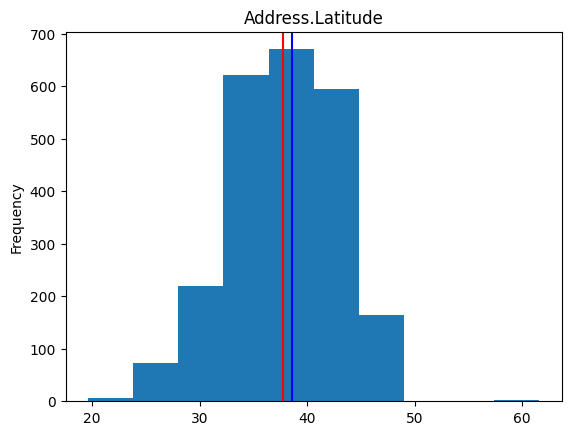

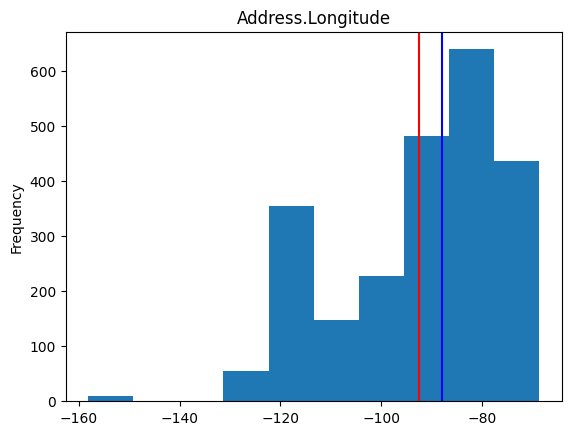

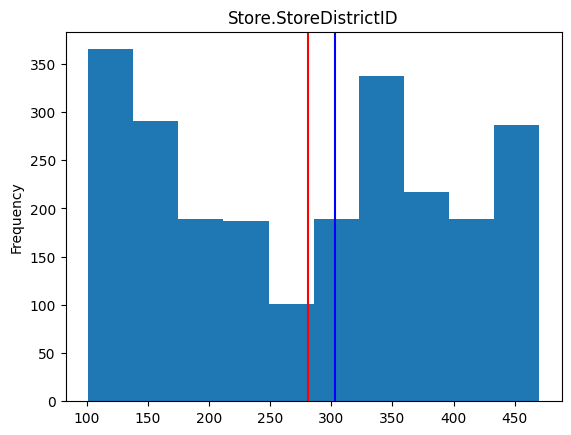

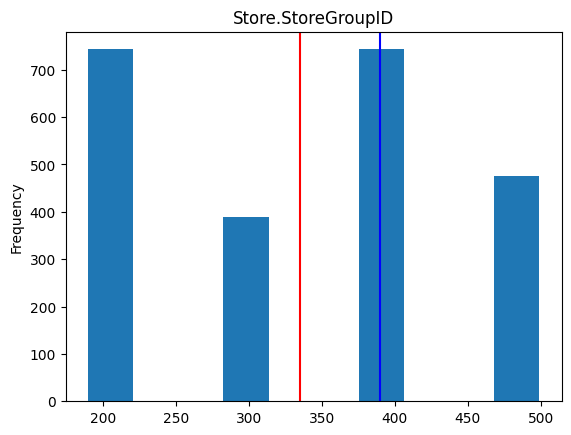

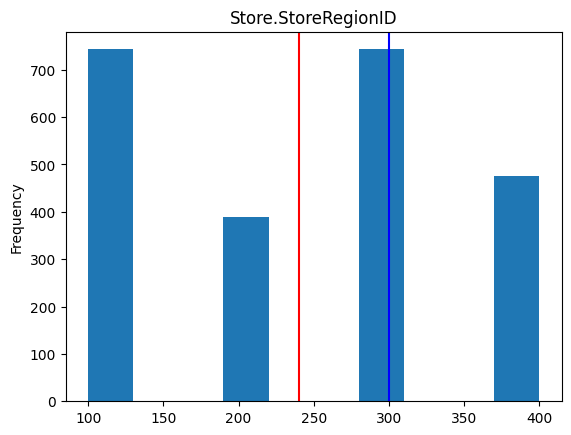

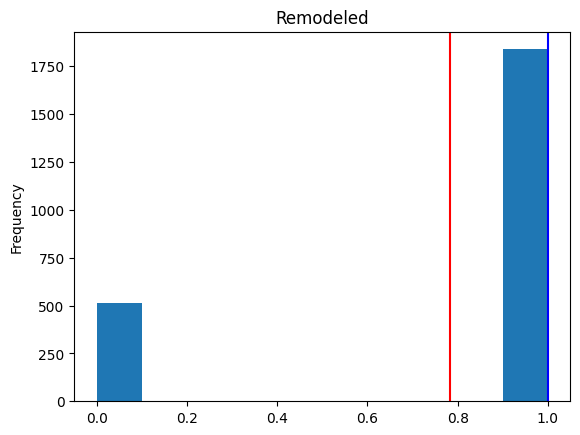

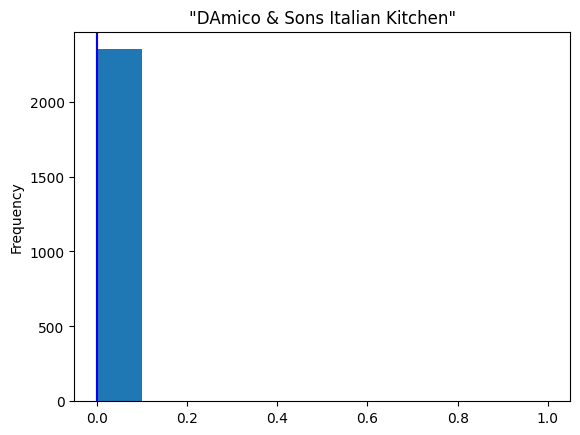

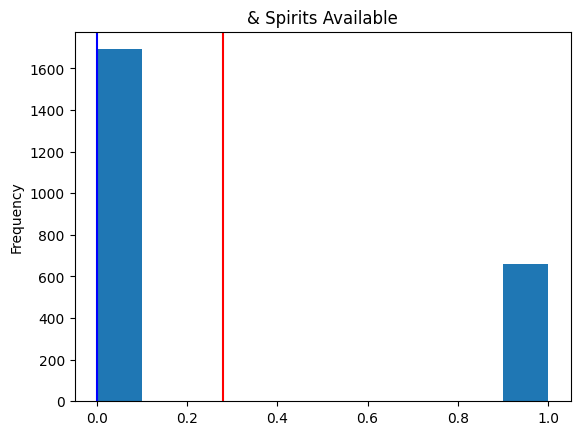

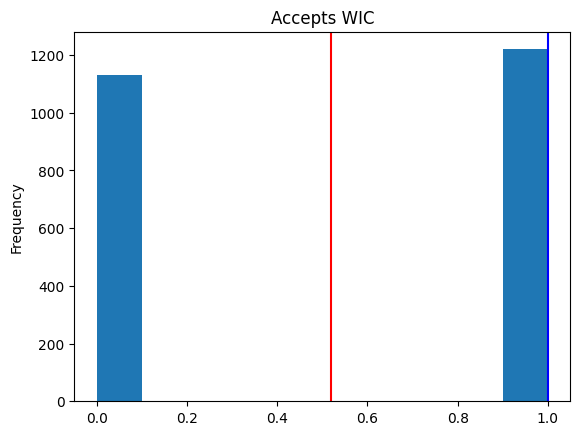

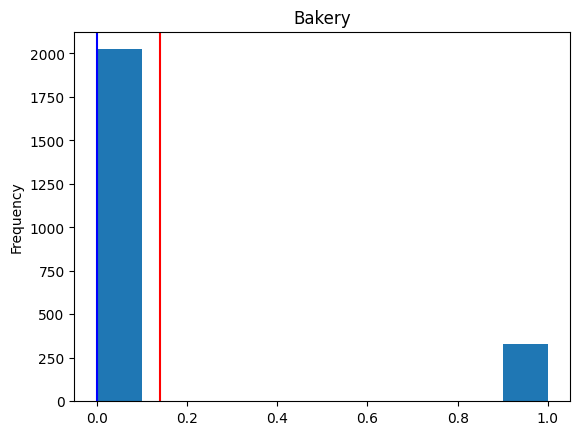

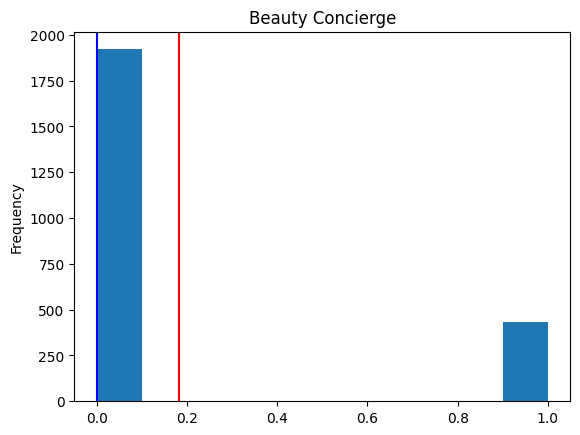

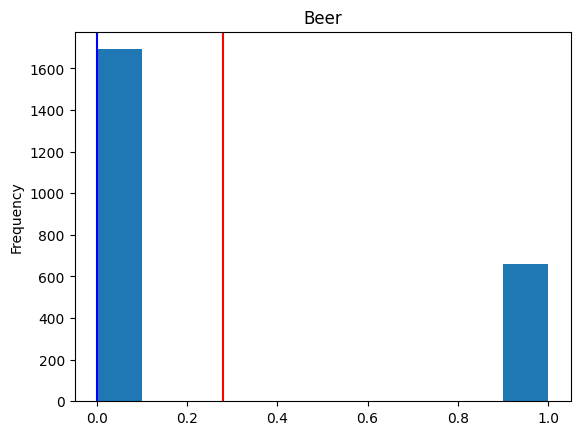

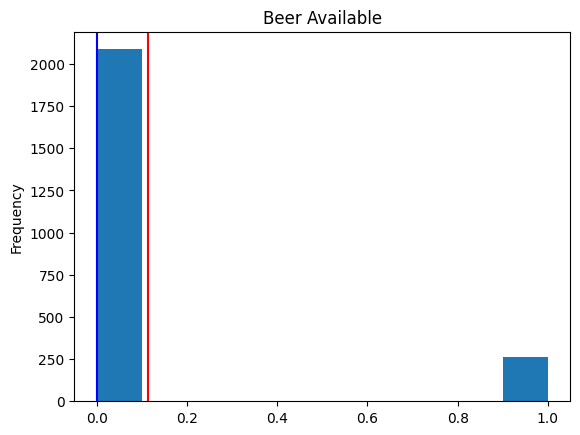

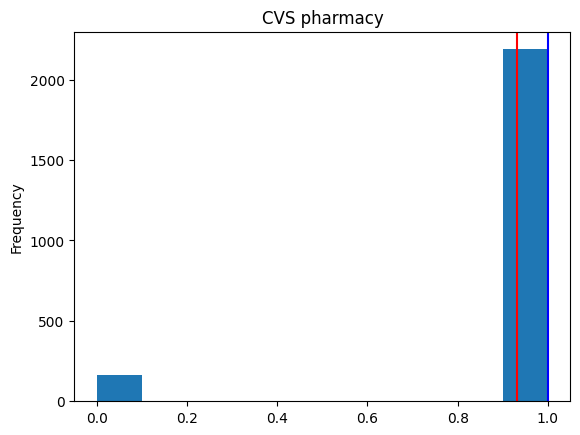

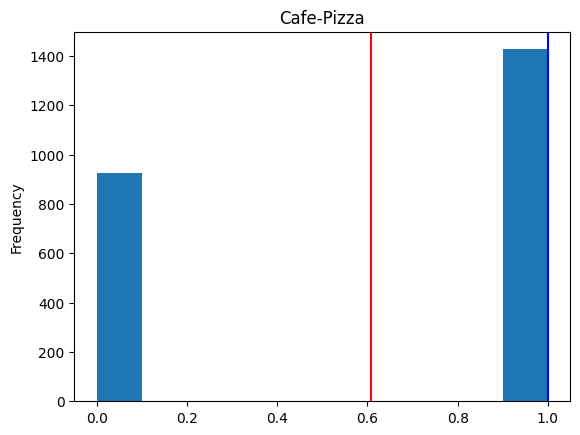

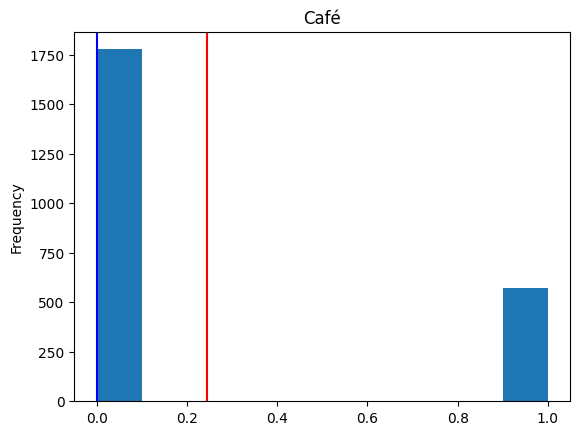

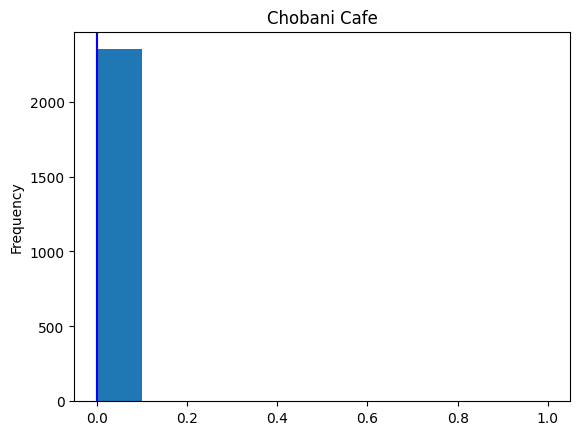

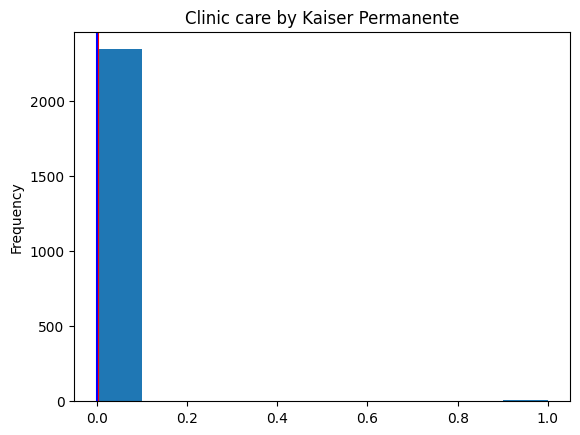

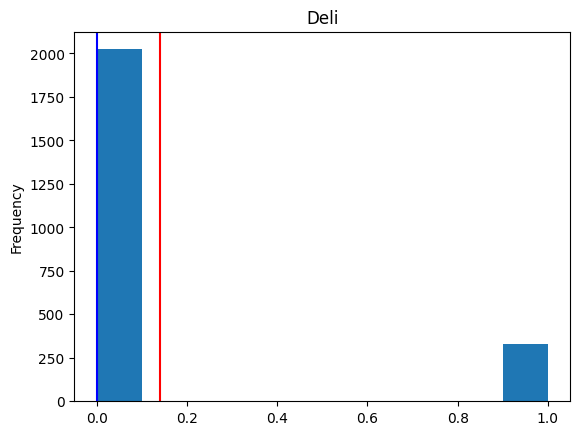

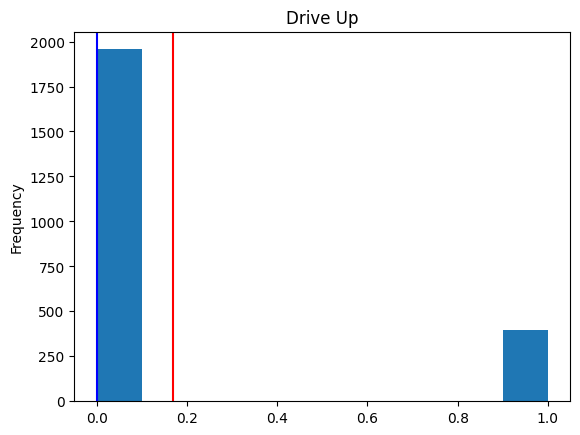

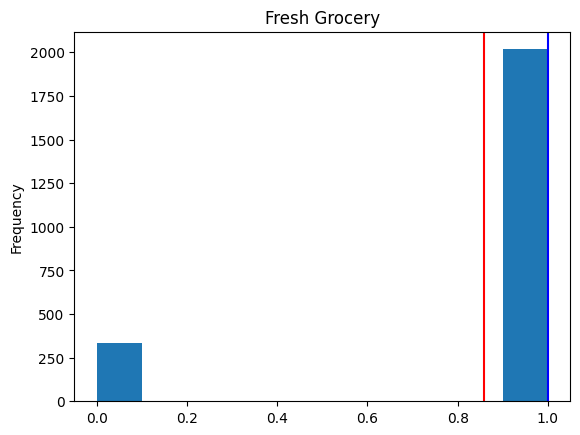

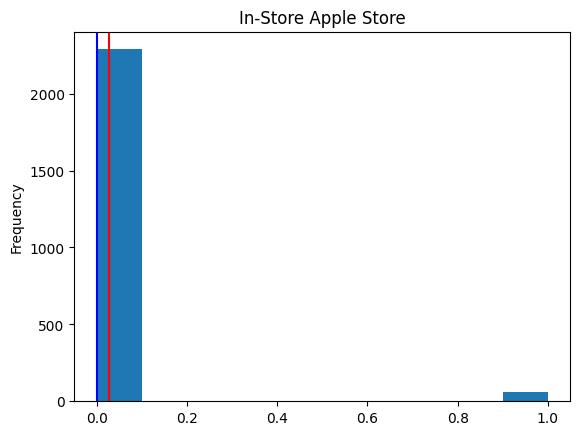

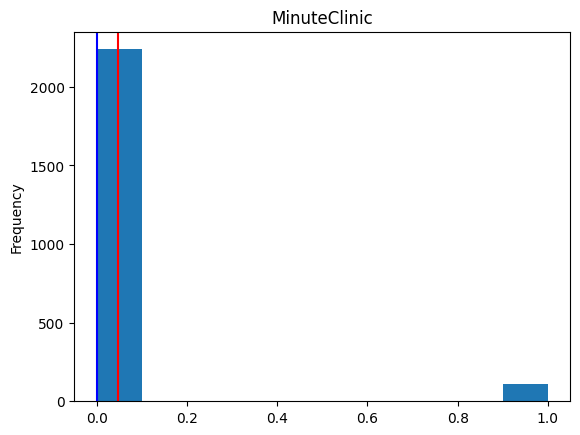

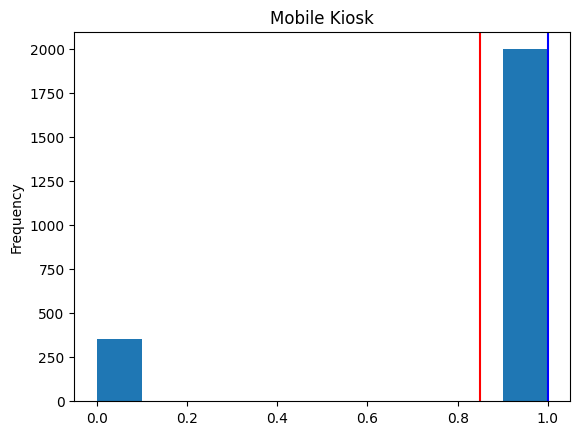

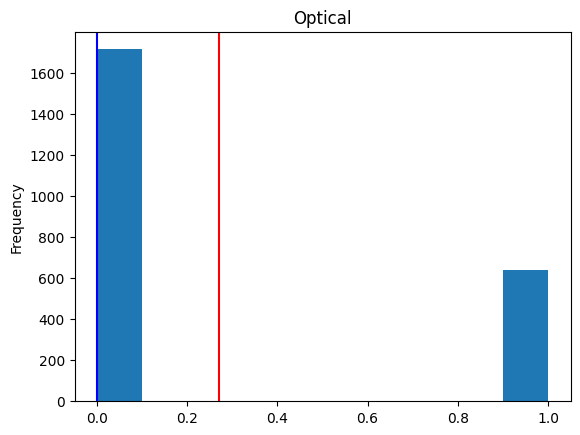

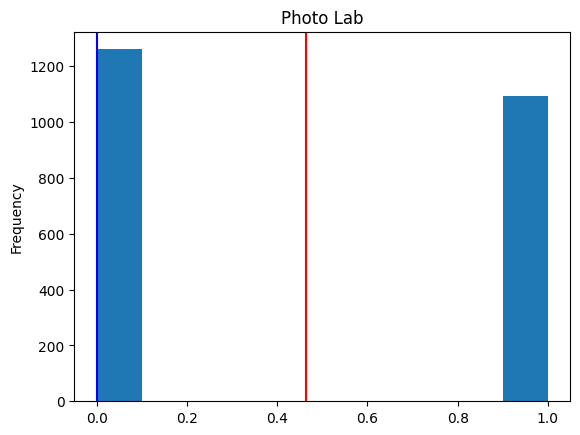

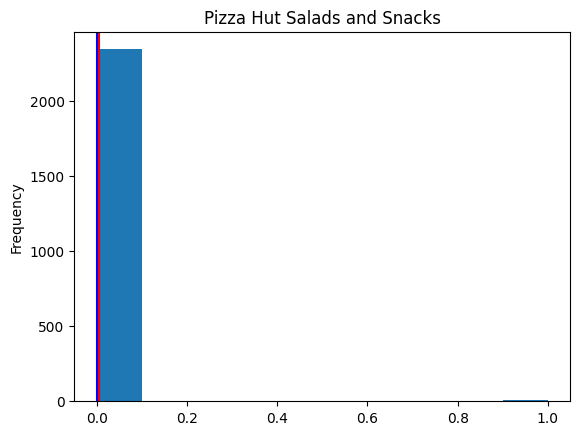

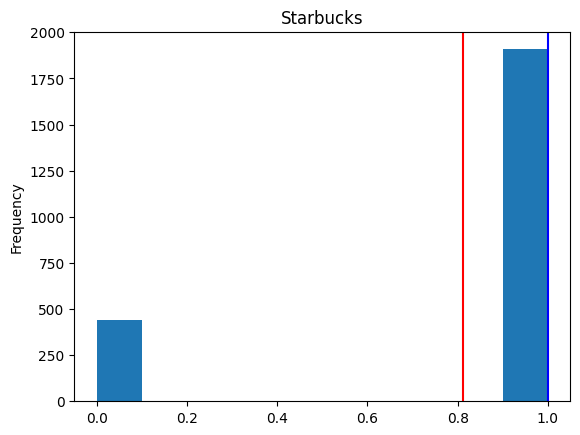

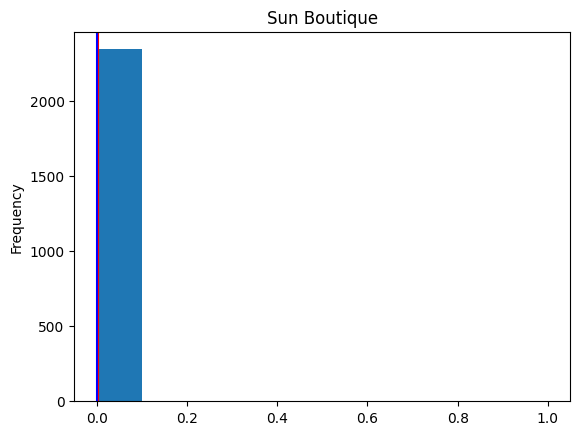

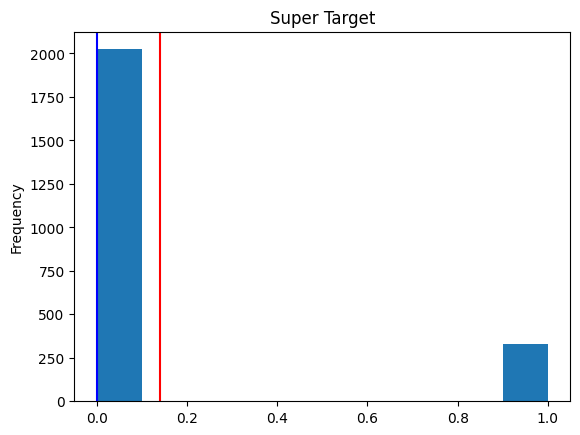

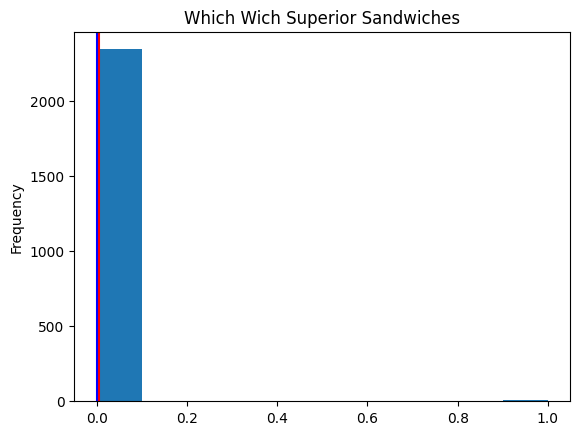

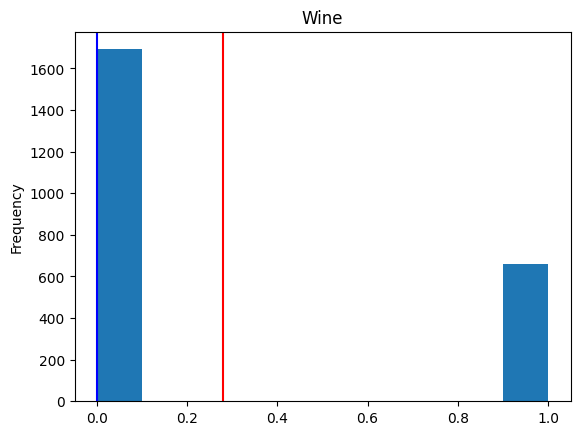

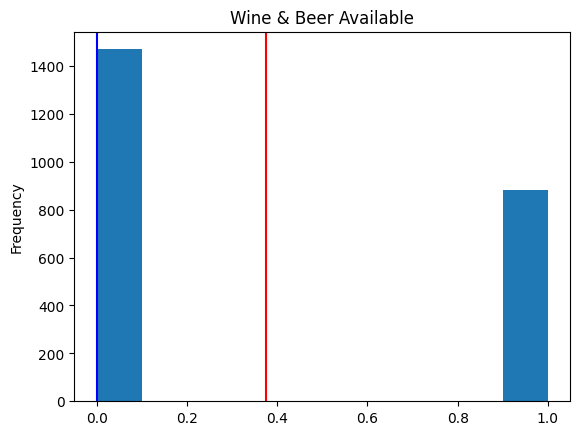

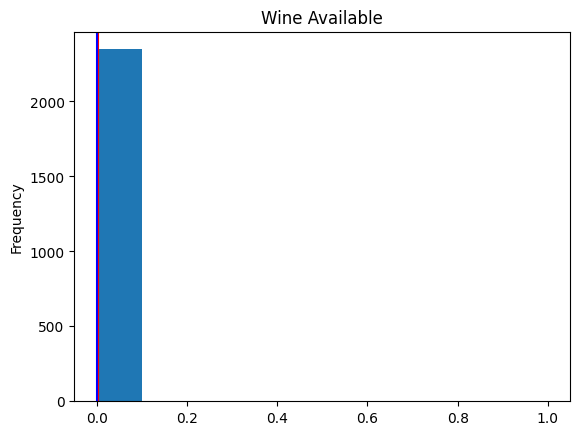

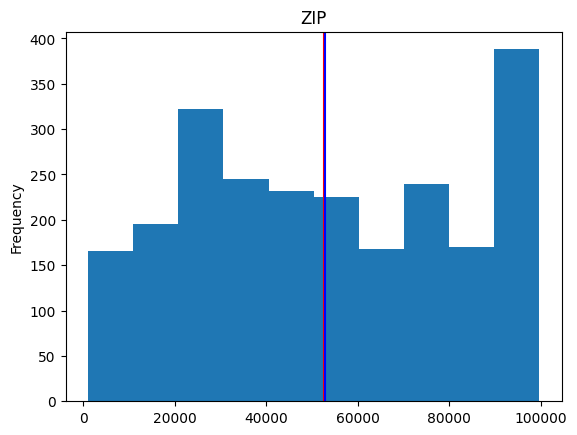

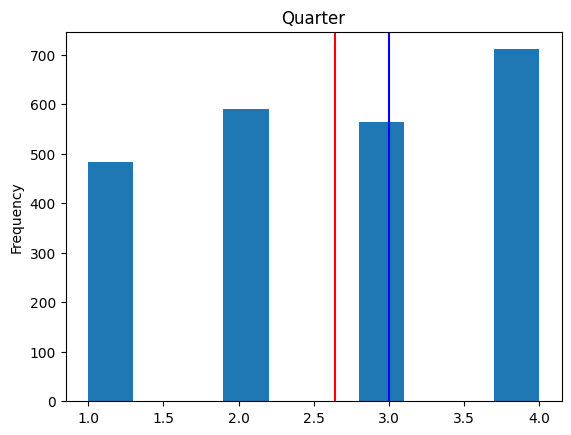

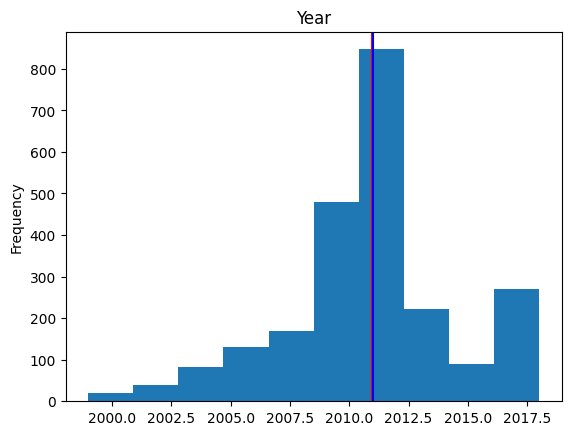

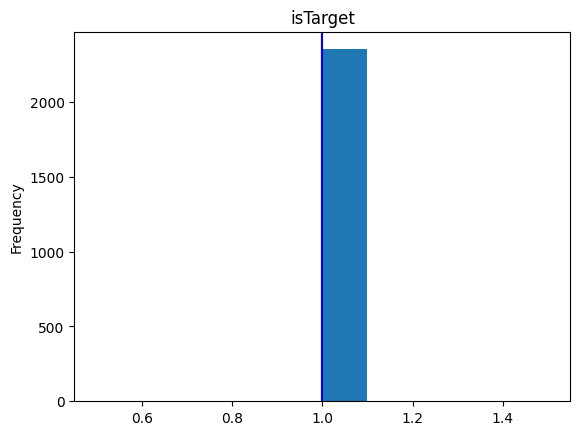

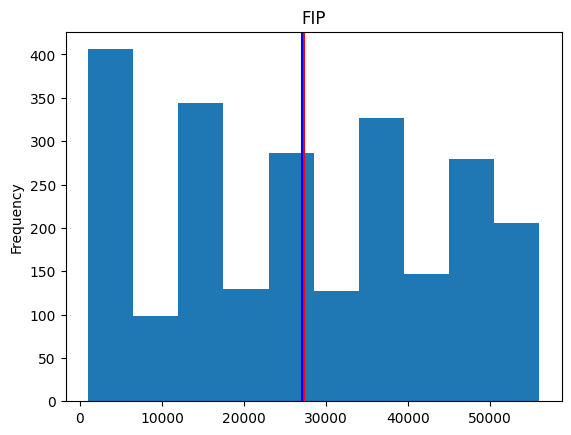

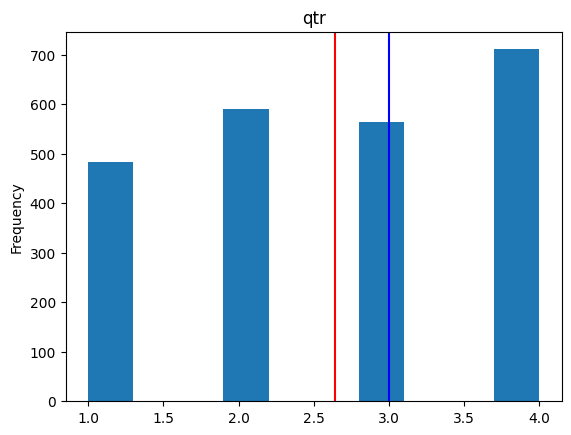

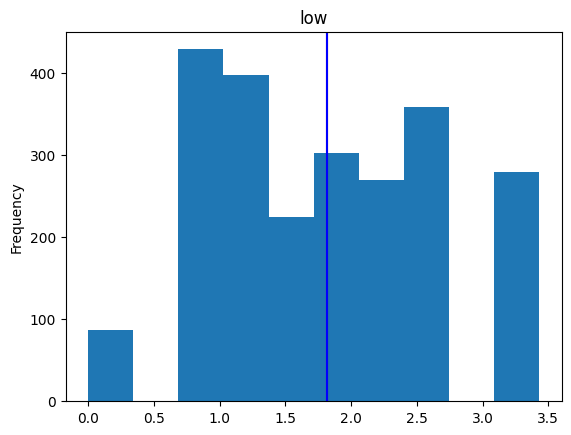

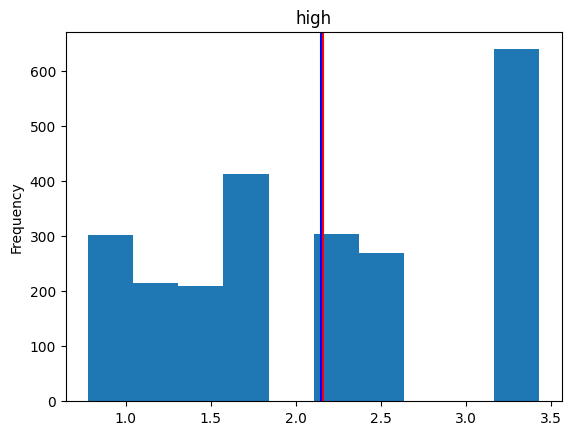

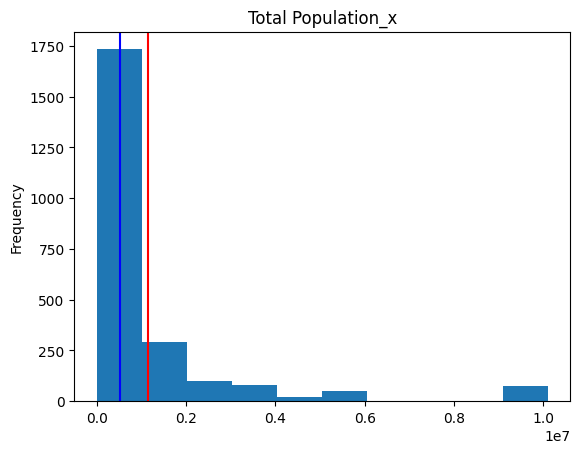

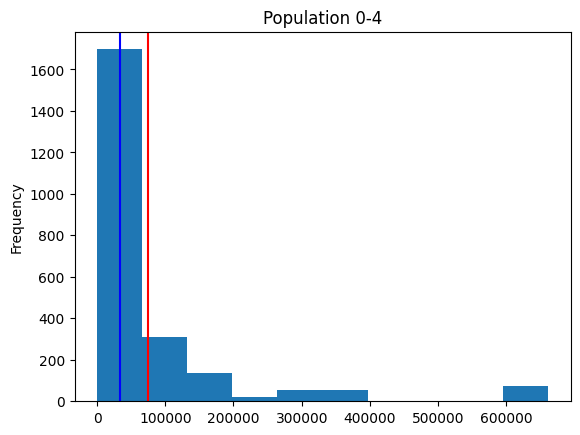

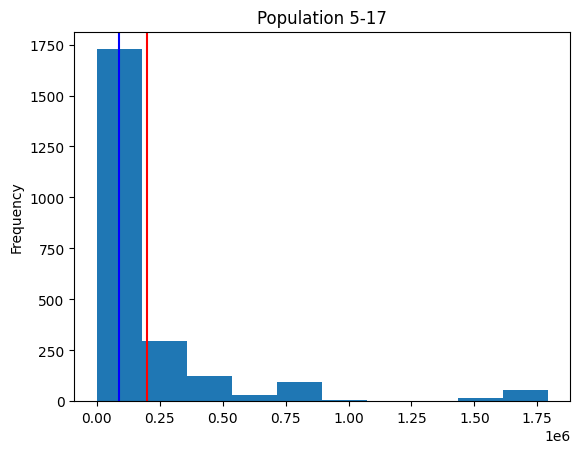

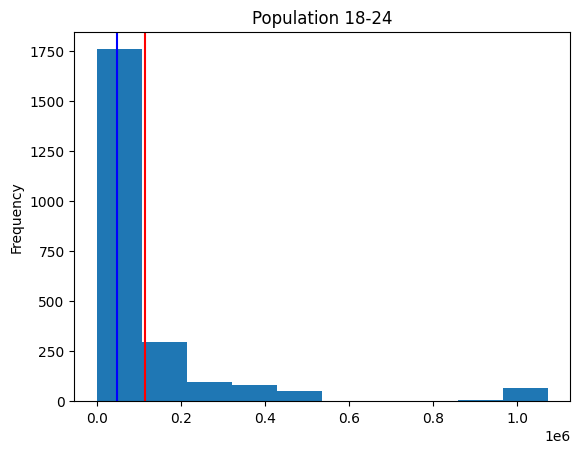

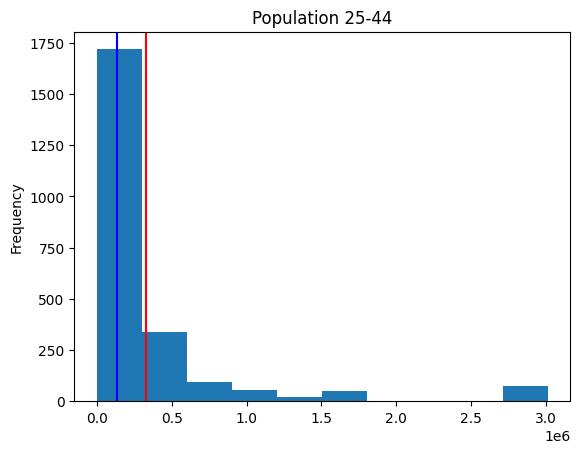

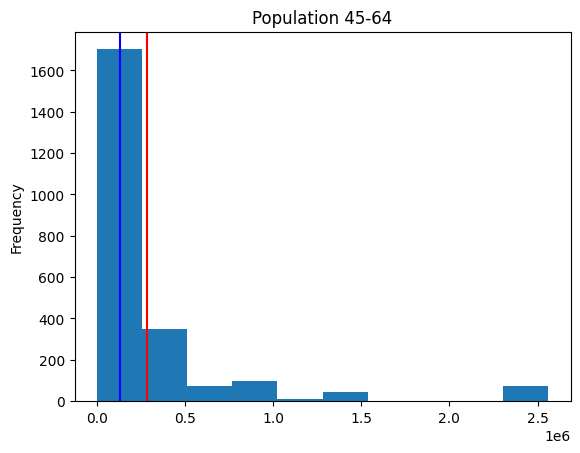

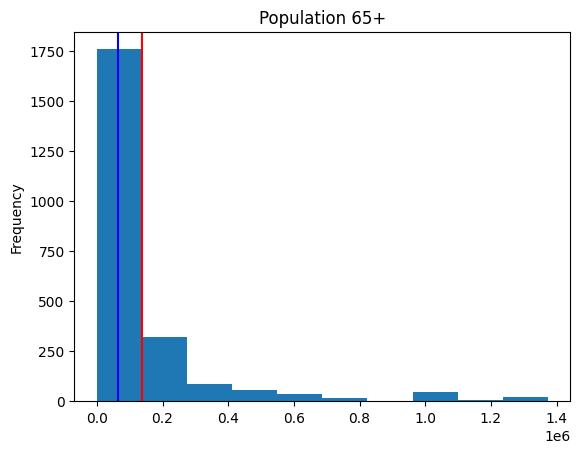

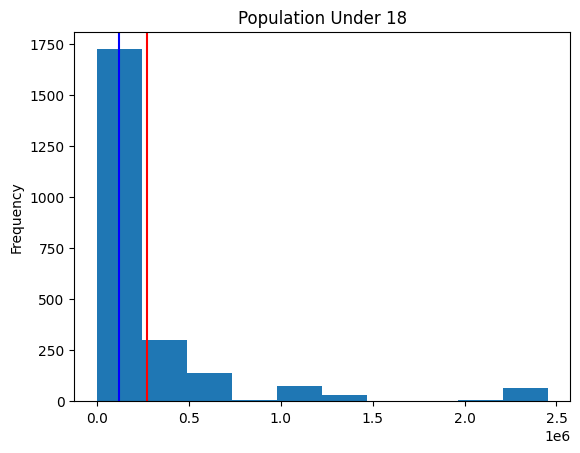

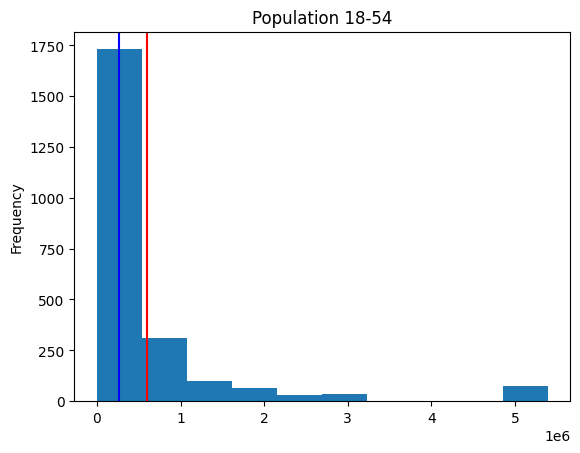

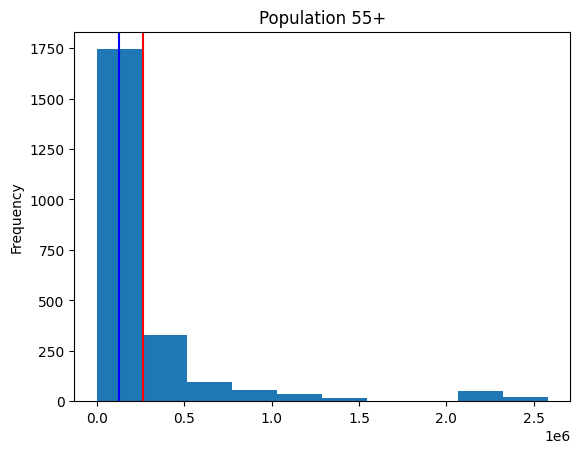

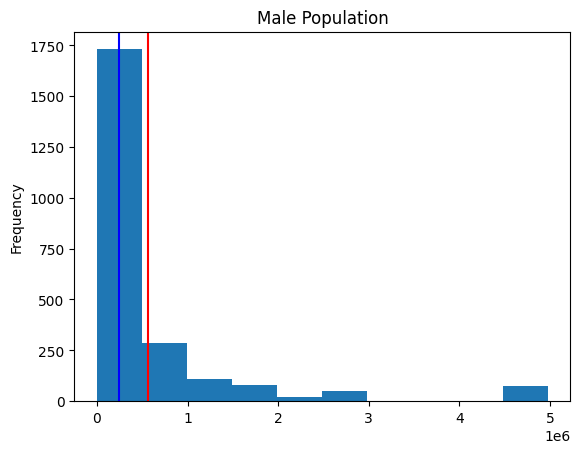

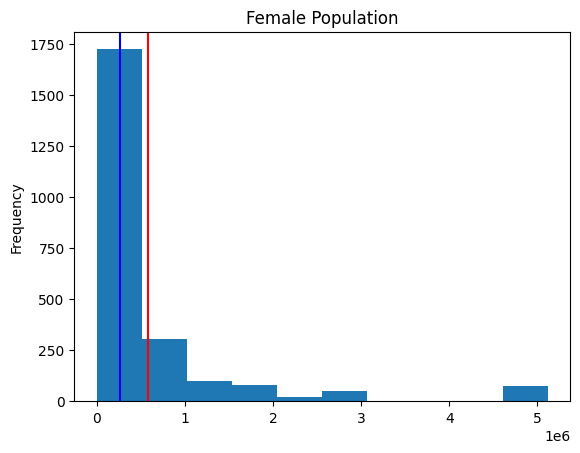

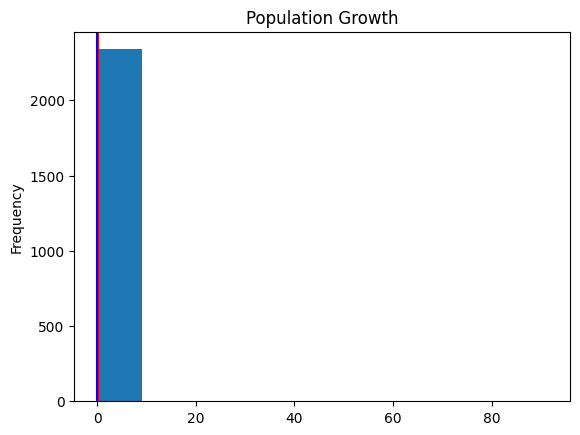

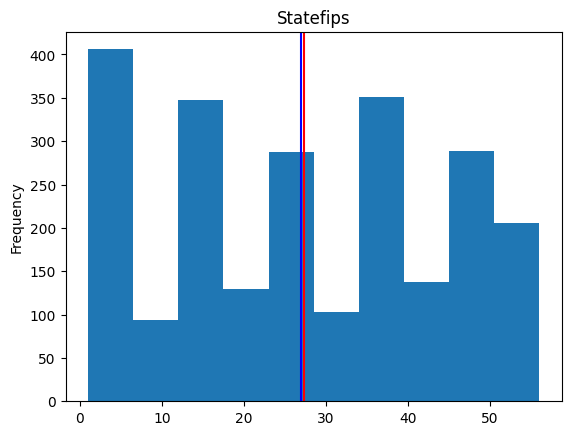

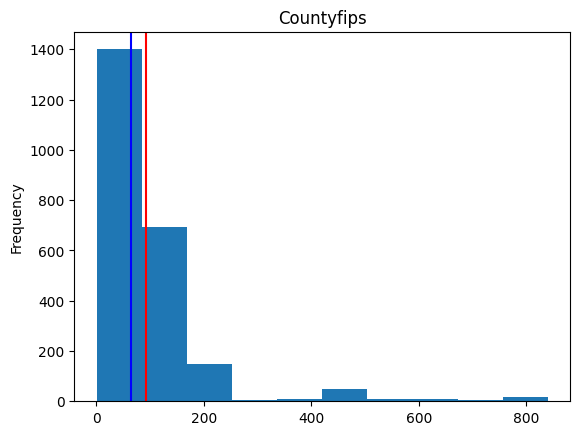

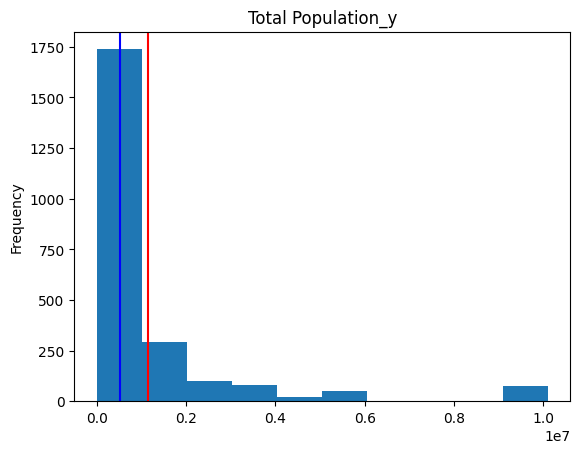

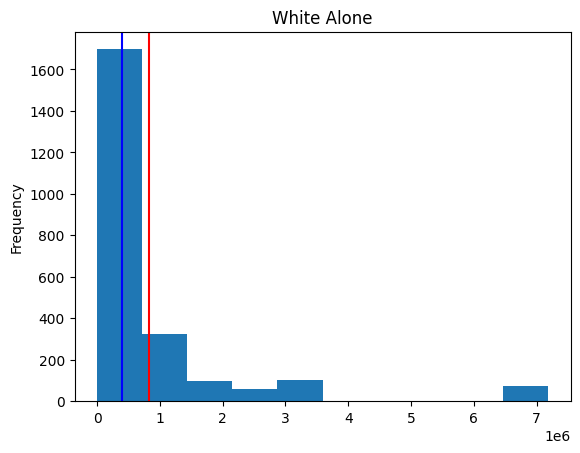

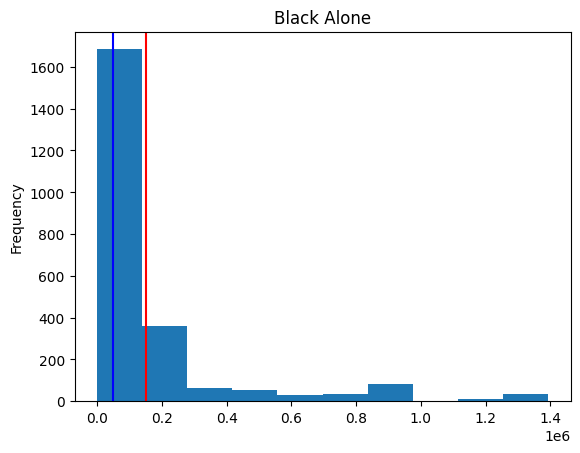

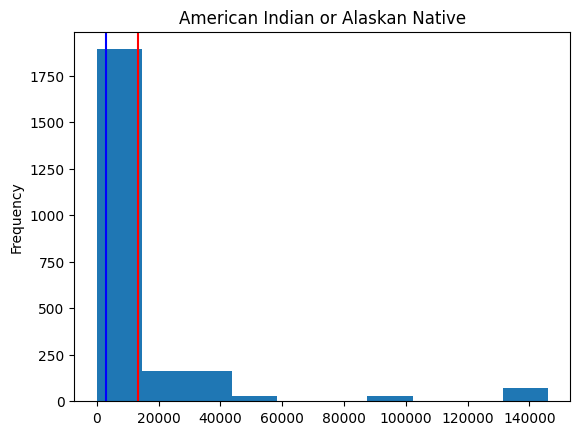

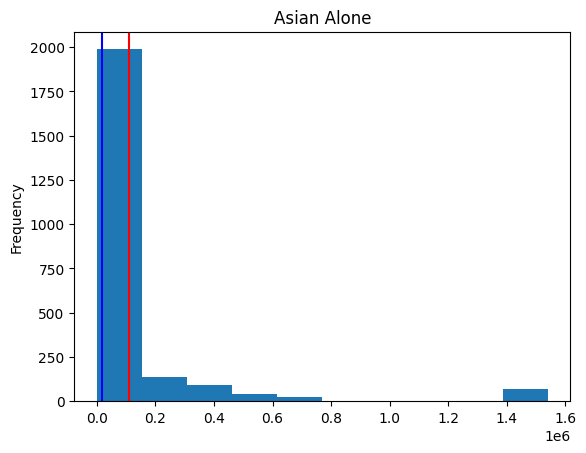

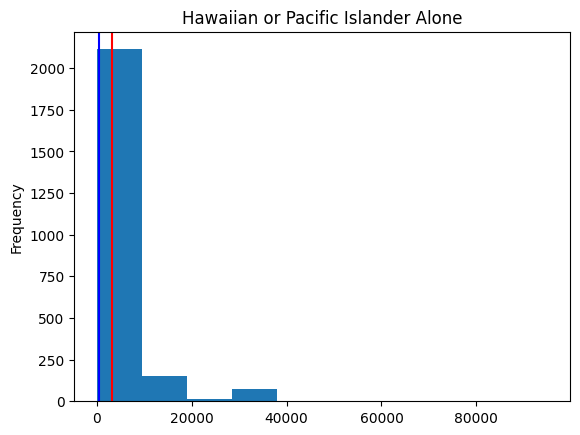

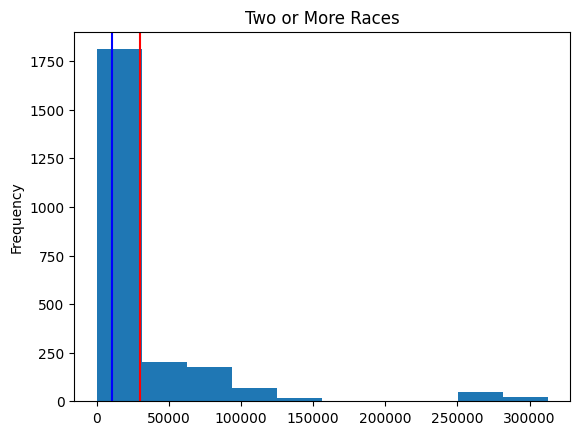

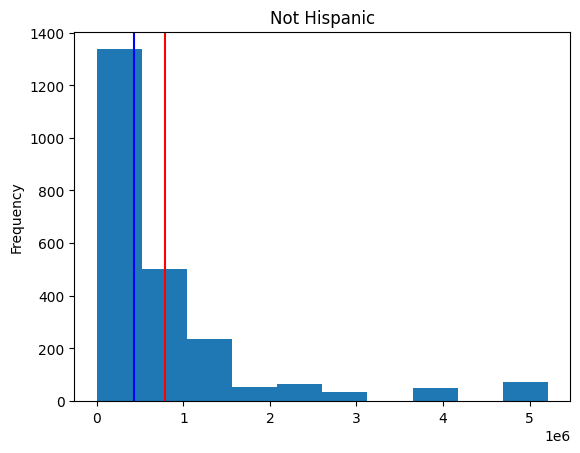

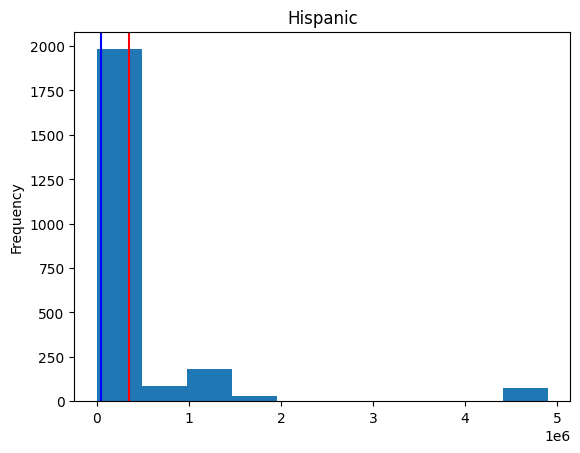

In [169]:
numeric_master_data = master_data.select_dtypes(include=['float64', 'int64'])


for col in numeric_master_data.columns:
  numeric_master_data.loc[:,col].plot(kind='hist')
  plt.axvline(numeric_master_data[col].mean(), label='Mean', c='red')
  plt.axvline(numeric_master_data[col].median(), label='Median', c='blue')
  plt.title(col)
  plt.show()

We could either do these logarithmic (or other) transformations of our dataset in order to remove some of the skew that we see, HOWEVER, because we will be scaling this dataset, this transformation will be mostly lost when we do scaling and PCA.

Now we will look at the correlations between our variables before we scale and transform them using dimensionality reduction techniques

In [170]:
corr_df = master_data.corr()
mask = np.triu(corr_df)

<ipython-input-170-959bea1a2157>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = master_data.corr()


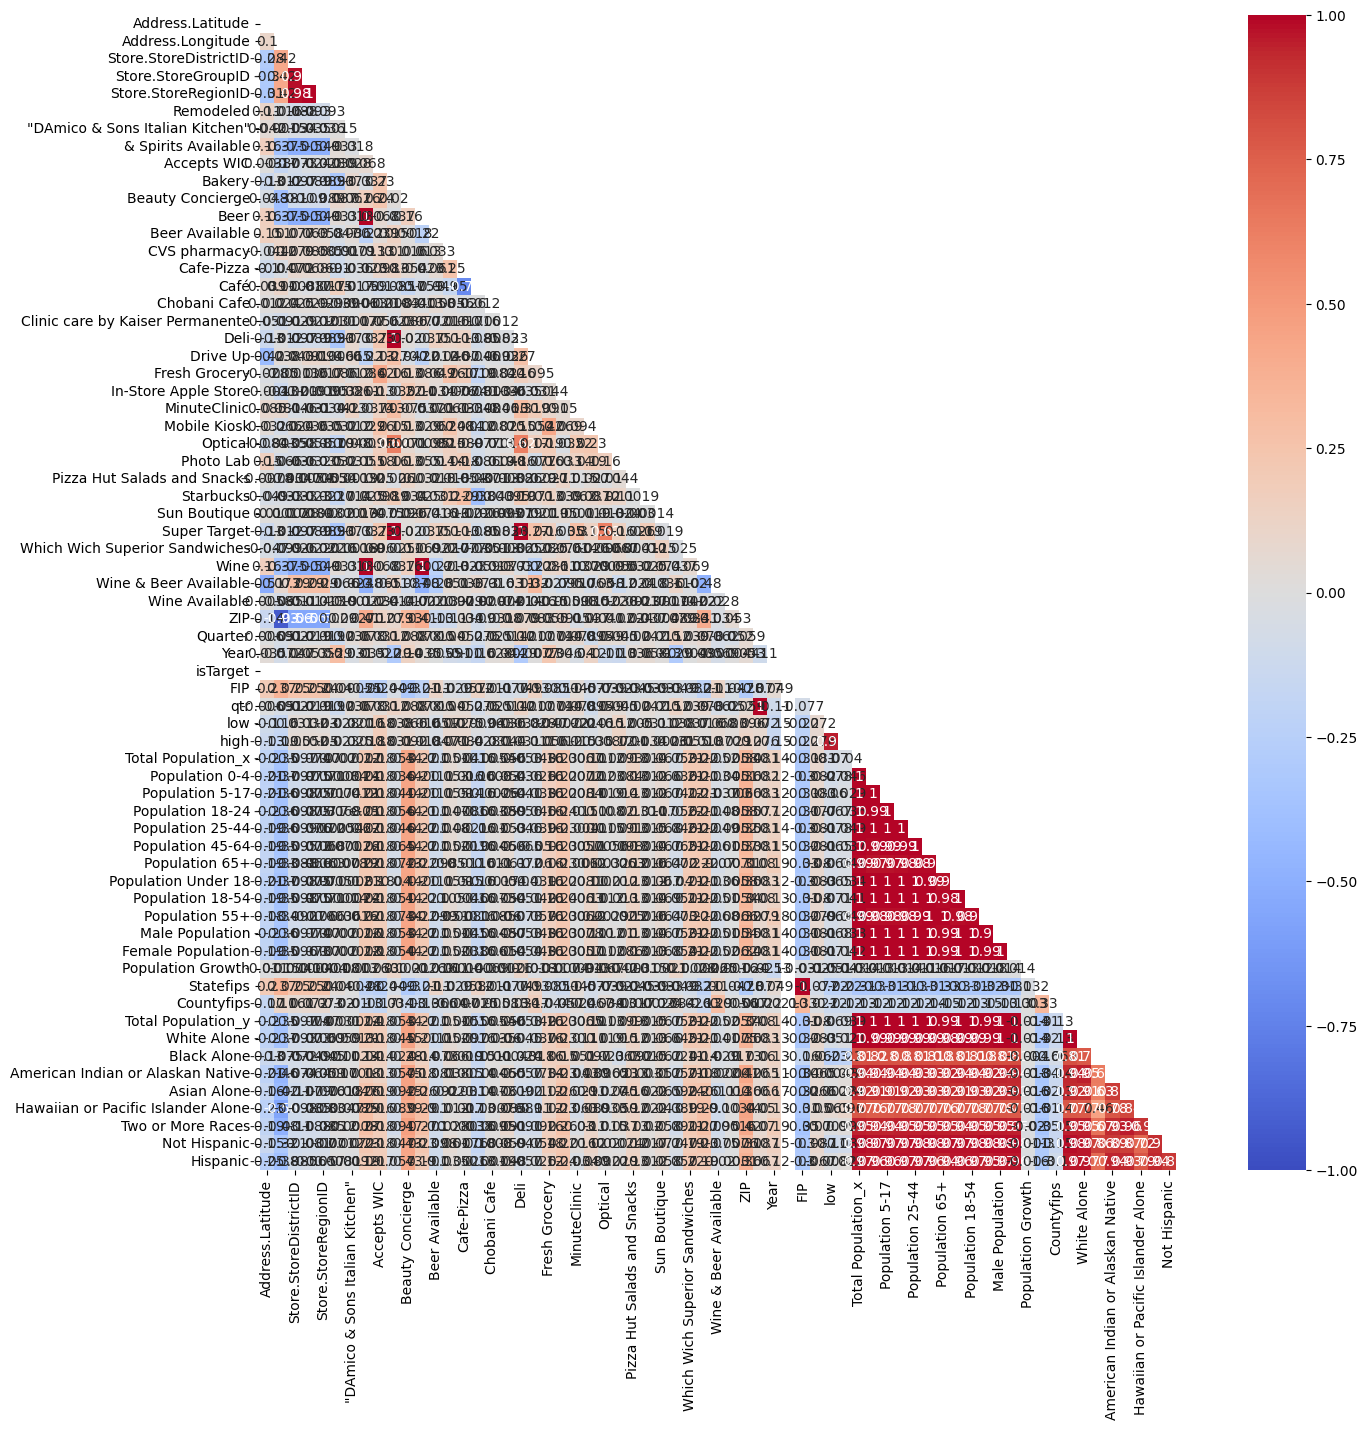

In [171]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_df, vmin=-1, vmax=1, cmap='coolwarm', annot=True, mask=mask) #annot is annotation
plt.show()

From the correlation map we see that there is some multi-colinearity.This is important to note, however, since we will be using dimensionality reduction techniques, dealing with these issues of collinearity will be done automatically

## Scaling Master Data

For our model we will need to scale our data. Let's first filter to have only numeric columns in our dataset inorder to scale.

In [172]:
numeric_master_data = master_data.select_dtypes(include=['float64', 'int64'])

In [173]:
numeric_master_data.head()

Address.Latitude  Address.Longitude  Store.StoreDistrictID  \
0         33.608825         -85.783182                  340.0   
1         33.608825         -85.783182                  340.0   
2         32.618108         -85.410636                  340.0   
3         32.618108         -85.410636                  340.0   
4         33.392907         -84.758875                  336.0   

   Store.StoreGroupID  Store.StoreRegionID  Remodeled  \
0               394.0                300.0        0.0   
1               394.0                300.0        0.0   
2               394.0                300.0        0.0   
3               394.0                300.0        0.0   
4               394.0                300.0        1.0   

   "DAmico & Sons Italian Kitchen"  & Spirits Available  Accepts WIC  Bakery  \
0                              0.0                  0.0          0.0     0.0   
1                              0.0                  0.0          0.0     0.0   
2                              0.0                  0.0          0.0     0.0   
3                              0.0                  0.0          0.0     0.0   
4                              0.0                  0.0          0.0     0.0   

   Beauty Concierge  Beer  Beer Available  CVS pharmacy  Cafe-Pizza  Café  \
0               0.0   0.0             0.0           1.0         0.0   1.0   
1               0.0   0.0             0.0           1.0         0.0   1.0   
2               0.0   0.0             0.0           1.0         1.0   0.0   
3               0.0   0.0             0.0           1.0         1.0   0.0   
4               0.0   0.0             0.0           1.0         0.0   1.0   

   Chobani Cafe  Clinic care by Kaiser Permanente  Deli  Drive Up  \
0           0.0                               0.0   0.0       0.0   
1           0.0                               0.0   0.0       0.0   
2           0.0                               0.0   0.0       0.0   
3           0.0                               0.0   0.0       0.0   
4           0.0                               0.0   0.0       0.0   

   Fresh Grocery  In-Store Apple Store  MinuteClinic  Mobile Kiosk  Optical  \
0            0.0                   0.0           0.0           1.0      0.0   
1            0.0                   0.0           0.0           1.0      0.0   
2            1.0                   0.0           0.0           1.0      0.0   
3            1.0                   0.0           0.0           1.0      0.0   
4            1.0                   0.0           0.0           1.0      0.0   

   Photo Lab  Pizza Hut Salads and Snacks  Starbucks  Sun Boutique  \
0        0.0                          0.0        1.0           0.0   
1        0.0                          0.0        1.0           0.0   
2        0.0                          0.0        1.0           0.0   
3        0.0                          0.0        1.0           0.0   
4        1.0                          0.0        1.0           0.0   

   Super Target  Which Wich Superior Sandwiches  Wine  Wine & Beer Available  \
0           0.0                             0.0   0.0                    1.0   
1           0.0                             0.0   0.0                    1.0   
2           0.0                             0.0   0.0                    1.0   
3           0.0                             0.0   0.0                    1.0   
4           0.0                             0.0   0.0                    1.0   

   Wine Available    ZIP  Quarter    Year  isTarget    FIP  qtr   low  high  \
0             0.0  36203      3.0  2006.0       1.0   1015    3  1.58  1.82   
1             0.0  36203      3.0  2006.0       1.0   1121    3  1.01  1.19   
2             0.0  36801      3.0  2005.0       1.0   1017    3  1.58  1.82   
3             0.0  36801      3.0  2005.0       1.0   1081    3  1.58  1.82   
4             0.0  30265      2.0  2013.0       1.0  13077    2  2.61  3.43   

   Total Population_x  Population 0-4  Population 5-17  Po

Let's set our scalers a variable so that we can use them.

In [174]:
ms = MinMaxScaler()
ss = StandardScaler()

Now let's fit the data our chosen scalars.

In [175]:

data_minmax_scaled = ms.fit_transform(numeric_master_data)
data_standard_scaled = ss.fit_transform(numeric_master_data)

We see that these are numpy arrays

In [176]:
type(data_minmax_scaled)

numpy.ndarray

In [177]:
type(data_standard_scaled)

numpy.ndarray

Let's convert the numpy arrays into pandas dataframes so that we can work with them.

In [178]:
df_m = pd.DataFrame(data_minmax_scaled, columns=numeric_master_data.columns, index = numeric_master_data.index)
df_s = pd.DataFrame(data_standard_scaled, columns=numeric_master_data.columns, index = numeric_master_data.index)

## Dimensionality Reduction (Part 1)

Now we want to reduce the dimensions of our datasets in order to plot the principle components against one another. We will create 6 different transformations based on 3 dimensionality reductions and the 2 scalings.

We are going to do PCA on all of the data to better understand the similarities of all targets and demographics


In [179]:
#PCA + MIN MAX
pca_m = PCA(n_components=3)
df_m_pca = pca_m.fit_transform(df_m)

#PCA + STANDARD
pca_s = PCA(n_components=3)
df_s_pca = pca_s.fit_transform(df_s)

#TSNE + MIN MAX
tsne_m = TSNE(n_components = 3, perplexity = 15) #perplexity is a parameter
df_m_tsne = tsne_m.fit_transform(df_m)

#TSNE + STANDARD
tsne_s = TSNE(n_components = 3, perplexity = 15) #perplexity is a parameter
df_s_tsne = tsne_s.fit_transform(df_s)

#UMAP + MINMAX
umapM = UMAP(n_neighbors=10, n_components=3).fit_transform(df_m)

#UMAP + STANDARD
umapS = UMAP(n_neighbors=10, n_components=3).fit_transform(df_s)

ValueError: ignored

Now that we have our 6 dimentionality reduced dataframes, it's time to look at how they are scattered. Let's start with the PCA data.

First we need to convert them from numpy data arrays to pandas dataframes.

In [ ]:
df_m_pca = pd.DataFrame(df_m_pca, index=numeric_master_data.index)
df_s_pca = pd.DataFrame(df_s_pca, index=numeric_master_data.index)

In [ ]:
#PCA MINMAX
plt.figure()
sns.pairplot(df_m_pca)
plt.show()

In [ ]:
#PCA STANDARD
plt.figure()
sns.pairplot(df_s_pca)
plt.show()

Let's now work with the TSNE data

In [ ]:
df_m_tsne = pd.DataFrame(df_m_tsne, index=numeric_master_data.index)
df_s_tsne = pd.DataFrame(df_s_tsne, index=numeric_master_data.index)

In [ ]:
#TSNE MINMAX
sns.pairplot(df_m_tsne)

In [ ]:
#TSNE STANDARD
sns.pairplot(df_s_tsne)

Now let's do the same for UMAP

In [ ]:
df_umapM = pd.DataFrame(umapM, index=numeric_master_data.index)
df_umapS = pd.DataFrame(umapS, index=numeric_master_data.index)

In [ ]:
#UMAP MINMAX
sns.pairplot(df_umapM)

In [ ]:
#UMAP STANDARD
sns.pairplot(df_umapS)

We will now look at 3d plots of these techniques to assess which is most separable

In [ ]:
#PCA Minmax

plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(df_m_pca[0],df_m_pca[1],df_m_pca[2])
plt.show()

In [ ]:
#PCA Standard
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(df_s_pca[2],df_s_pca[1],df_s_pca[0])
plt.show()

In [ ]:
#TSNE M


plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(df_m_tsne[0],df_m_tsne[1],df_m_tsne[2])
plt.show()

In [ ]:
#TSNE S

plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(df_s_tsne[2],df_s_tsne[1],df_s_tsne[0])
plt.show()


In [ ]:
#UMAP M


plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(df_umapM[2],df_umapM[1],df_umapM[0])
plt.show()

In [ ]:
#UMAP S


plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(df_umapS[0],df_umapS[1],df_umapS[2])
plt.show()

## Dimensionality Reduction (Part 2)

In [180]:
merged_demo_data = pd.merge(pop_age_sex,raw_debt_data, how='inner', on=['Year','FIP'])

In [181]:
merged_demo2 = pd.merge(merged_demo_data,race_data, how ='inner', on=['Year','FIP'] )

In [182]:
merged_demo2

FIP  Year  Total Population_x  Population 0-4  Population 5-17  \
0        1001  2000             44021.0          3029.0           9538.0   
1        1001  2000             44021.0          3029.0           9538.0   
2        1001  2000             44021.0          3029.0           9538.0   
3        1001  2000             44021.0          3029.0           9538.0   
4        1001  2001             44889.0          3120.0           9574.0   
...       ...   ...                 ...             ...              ...   
250850  56045  2018              6924.0           359.0           1083.0   
250851  56045  2019              6927.0           350.0           1065.0   
250852  56045  2019              6927.0           350.0           1065.0   
250853  56045  2019              6927.0           350.0           1065.0   
250854  56045  2019              6927.0           350.0           1065.0   

        Population 18-24  Population 25-44  Population 45-64  Population 65+  \
0                 3520.0           13444.0            9959.0          4531.0   
1                 3520.0           13444.0            9959.0          4531.0   
2                 3520.0           13444.0            9959.0          4531.0   
3                 3520.0           13444.0            9959.0          4531.0   
4                 3654.0           13507.0           10367.0          4667.0   
...                  ...               ...               ...             ...   
250850             417.0            1678.0            1961.0          1426.0   
250851             426.0            1680.0            1928.0          1478.0   
250852             426.0            1680.0            1928.0          1478.0   
250853             426.0            1680.0            1928.0          1478.0   
250854             426.0            1680.0            1928.0          1478.0   

        Population Under 18  Population 18-54  Population 55+  \
0                   12567.0           22673.0          8781.0   
1                   12567.0           22673.0          8781.0   
2                   12567.0           22673.0          8781.0   
3                   12567.0           22673.0          8781.0   
4                   12694.0           23155.0          9040.0   
...                     ...               ...             ...   
250850               1442.0            2900.0          2582.0   
250851               1415.0            2881.0          2631.0   
250852               1415.0            2881.0          2631.0   
250853               1415.0            2881.0          2631.0   
250854               1415.0            2881.0          2631.0   

        Male Population  Female Population  Population Growth COUNTYNAME  \
0               21385.0            22636.0          -0.991022   Autauga    
1               21385.0            22636.0          -0.991022   Autauga    
2               21385.0            22636.0          -0.991022   Autauga    
3               21385.0            22636.0          -0.991022   Autauga    
4               21813.0            23076.0           0.019718   Autauga    
...                 ...                ...                ...        ...   
250850           3624.0             3271.0          -0.006315    Weston    
250851           3615.0             3265.0           0.000433    Weston    
250852           3615.0             3265.0           0.000433    Weston    
250853           3615.0             3265.0           0.000433    Weston    
250854           3615.0             3265.0           0.000433    Weston    

       STATE  qtr   low  high       date  Quarter  Statefips  Countyfips  \
0         AL    1  2.61  3.43 2000-01-01        1          1           1   
1         AL    2  2.61  3.43 2000-04-01        2          1           1   
2         AL    3  2.61  3.43 2000-07-01        3          1           1   
3         AL    4  2.61  3.43 2000-10-01        4          1           1   
4         AL    1  2.61  3.43 2001-01-01        1          1  

In [183]:
merged_demo2.isna().sum()

FIP                                   0
Year                                  0
Total Population_x                    0
Population 0-4                        0
Population 5-17                       0
Population 18-24                      0
Population 25-44                      0
Population 45-64                      0
Population 65+                        0
Population Under 18                   0
Population 18-54                      0
Population 55+                        0
Male Population                       0
Female Population                     0
Population Growth                     0
COUNTYNAME                            0
STATE                                 0
qtr                                   0
low                                   0
high                                  0
date                                  0
Quarter                               0
Statefips                             0
Countyfips                            0
Description                           0


Let's remove duplicates

In [184]:
merged_demo2.drop_duplicates(inplace=True)

In [185]:
merged_demo2

FIP  Year  Total Population_x  Population 0-4  Population 5-17  \
0        1001  2000             44021.0          3029.0           9538.0   
1        1001  2000             44021.0          3029.0           9538.0   
2        1001  2000             44021.0          3029.0           9538.0   
3        1001  2000             44021.0          3029.0           9538.0   
4        1001  2001             44889.0          3120.0           9574.0   
...       ...   ...                 ...             ...              ...   
250850  56045  2018              6924.0           359.0           1083.0   
250851  56045  2019              6927.0           350.0           1065.0   
250852  56045  2019              6927.0           350.0           1065.0   
250853  56045  2019              6927.0           350.0           1065.0   
250854  56045  2019              6927.0           350.0           1065.0   

        Population 18-24  Population 25-44  Population 45-64  Population 65+  \
0                 3520.0           13444.0            9959.0          4531.0   
1                 3520.0           13444.0            9959.0          4531.0   
2                 3520.0           13444.0            9959.0          4531.0   
3                 3520.0           13444.0            9959.0          4531.0   
4                 3654.0           13507.0           10367.0          4667.0   
...                  ...               ...               ...             ...   
250850             417.0            1678.0            1961.0          1426.0   
250851             426.0            1680.0            1928.0          1478.0   
250852             426.0            1680.0            1928.0          1478.0   
250853             426.0            1680.0            1928.0          1478.0   
250854             426.0            1680.0            1928.0          1478.0   

        Population Under 18  Population 18-54  Population 55+  \
0                   12567.0           22673.0          8781.0   
1                   12567.0           22673.0          8781.0   
2                   12567.0           22673.0          8781.0   
3                   12567.0           22673.0          8781.0   
4                   12694.0           23155.0          9040.0   
...                     ...               ...             ...   
250850               1442.0            2900.0          2582.0   
250851               1415.0            2881.0          2631.0   
250852               1415.0            2881.0          2631.0   
250853               1415.0            2881.0          2631.0   
250854               1415.0            2881.0          2631.0   

        Male Population  Female Population  Population Growth COUNTYNAME  \
0               21385.0            22636.0          -0.991022   Autauga    
1               21385.0            22636.0          -0.991022   Autauga    
2               21385.0            22636.0          -0.991022   Autauga    
3               21385.0            22636.0          -0.991022   Autauga    
4               21813.0            23076.0           0.019718   Autauga    
...                 ...                ...                ...        ...   
250850           3624.0             3271.0          -0.006315    Weston    
250851           3615.0             3265.0           0.000433    Weston    
250852           3615.0             3265.0           0.000433    Weston    
250853           3615.0             3265.0           0.000433    Weston    
250854           3615.0             3265.0           0.000433    Weston    

       STATE  qtr   low  high       date  Quarter  Statefips  Countyfips  \
0         AL    1  2.61  3.43 2000-01-01        1          1           1   
1         AL    2  2.61  3.43 2000-04-01        2          1           1   
2         AL    3  2.61  3.43 2000-07-01        3          1           1   
3         AL    4  2.61  3.43 2000-10-01        4          1           1   
4         AL    1  2.61  3.43 2001-01-01        1          1  

In [186]:


max_year = merged_demo2['Year'].max()
max_year


2019

Now let's filter only the most recent demographic data

In [187]:
filtered_2019 = merged_demo2[merged_demo2['Year'] == 2019]
filtered_2019

FIP  Year  Total Population_x  Population 0-4  Population 5-17  \
76       1001  2019             55869.0          3277.0           9688.0   
77       1001  2019             55869.0          3277.0           9688.0   
78       1001  2019             55869.0          3277.0           9688.0   
79       1001  2019             55869.0          3277.0           9688.0   
156      1003  2019            223234.0         12039.0          35515.0   
...       ...   ...                 ...             ...              ...   
250774  56043  2019              7805.0           399.0           1385.0   
250851  56045  2019              6927.0           350.0           1065.0   
250852  56045  2019              6927.0           350.0           1065.0   
250853  56045  2019              6927.0           350.0           1065.0   
250854  56045  2019              6927.0           350.0           1065.0   

        Population 18-24  Population 25-44  Population 45-64  Population 65+  \
76                4465.0           14597.0           14918.0          8924.0   
77                4465.0           14597.0           14918.0          8924.0   
78                4465.0           14597.0           14918.0          8924.0   
79                4465.0           14597.0           14918.0          8924.0   
156              15805.0           51839.0           61206.0         46830.0   
...                  ...               ...               ...             ...   
250774             517.0            1725.0            2049.0          1730.0   
250851             426.0            1680.0            1928.0          1478.0   
250852             426.0            1680.0            1928.0          1478.0   
250853             426.0            1680.0            1928.0          1478.0   
250854             426.0            1680.0            1928.0          1478.0   

        Population Under 18  Population 18-54  Population 55+  \
76                  12965.0           26714.0         16190.0   
77                  12965.0           26714.0         16190.0   
78                  12965.0           26714.0         16190.0   
79                  12965.0           26714.0         16190.0   
156                 47554.0           96435.0         79245.0   
...                     ...               ...             ...   
250774               1784.0            3158.0          2863.0   
250851               1415.0            2881.0          2631.0   
250852               1415.0            2881.0          2631.0   
250853               1415.0            2881.0          2631.0   
250854               1415.0            2881.0          2631.0   

        Male Population  Female Population  Population Growth COUNTYNAME  \
76              27078.0            28691.0           0.006050   Autauga    
77              27078.0            28691.0           0.006050   Autauga    
78              27078.0            28691.0           0.006050   Autauga    
79              27078.0            28691.0           0.006050   Autauga    
156            108396.0           115169.0           0.024691   Baldwin    
...                 ...                ...                ...        ...   
250774           3971.0             3853.0          -0.009141  Washakie    
250851           3615.0             3265.0           0.000433    Weston    
250852           3615.0             3265.0           0.000433    Weston    
250853           3615.0             3265.0           0.000433    Weston    
250854           3615.0             3265.0           0.000433    Weston    

       STATE  qtr   low  high       date  Quarter  Statefips  Countyfips  \
76        AL    1  3.43  3.43 2019-01-01        1          1           1   
77        AL    2  3.43  3.43 2019-04-01        2          1           1   
78        AL    3  3.43  3.43 2019-07-01        3          1           1   
79        AL    4  3.43  3.43 2019-10-01        4          1           1   
156       AL    1  2.61  3.43 2019-01-01        1          1  

Now let's extract Quarter 1 so that we have a snap shot of whats going on. We will assume data from quarter 1 is for the year

In [188]:
annual_data = filtered_2019[filtered_2019['qtr']== 1 ]

In [189]:
annual_data

FIP  Year  Total Population_x  Population 0-4  Population 5-17  \
76       1001  2019             55869.0          3277.0           9688.0   
156      1003  2019            223234.0         12039.0          35515.0   
236      1005  2019             24686.0          1309.0           3773.0   
316      1007  2019             22394.0          1246.0           3311.0   
396      1009  2019             57826.0          3438.0           9817.0   
...       ...   ...                 ...             ...              ...   
250531  56037  2019             42343.0          2797.0           8171.0   
250611  56039  2019             23464.0          1130.0           3070.0   
250691  56041  2019             20226.0          1361.0           4391.0   
250771  56043  2019              7805.0           399.0           1385.0   
250851  56045  2019              6927.0           350.0           1065.0   

        Population 18-24  Population 25-44  Population 45-64  Population 65+  \
76                4465.0           14597.0           14918.0          8924.0   
156              15805.0           51839.0           61206.0         46830.0   
236               2000.0            6412.0            6331.0          4861.0   
316               1768.0            6278.0            6058.0          3733.0   
396               4460.0           13941.0           15356.0         10814.0   
...                  ...               ...               ...             ...   
250531            3558.0           11991.0           10337.0          5489.0   
250611            1634.0            7729.0            6184.0          3717.0   
250691            1445.0            5058.0            4946.0          3025.0   
250771             517.0            1725.0            2049.0          1730.0   
250851             426.0            1680.0            1928.0          1478.0   

        Population Under 18  Population 18-54  Population 55+  \
76                  12965.0           26714.0         16190.0   
156                 47554.0           96435.0         79245.0   
236                  5082.0           11494.0          8110.0   
316                  4557.0           11198.0          6639.0   
396                 13255.0           26111.0         18460.0   
...                     ...               ...             ...   
250531              10968.0           20302.0         11073.0   
250611               4200.0           12486.0          6778.0   
250691               5752.0            8717.0          5757.0   
250771               1784.0            3158.0          2863.0   
250851               1415.0            2881.0          2631.0   

        Male Population  Female Population  Population Growth   COUNTYNAME  \
76              27078.0            28691.0           0.006050     Autauga    
156            108396.0           115169.0           0.024691     Baldwin    
236             13030.0            11627.0          -0.007478     Barbour    
316             11878.0            10435.0           0.001207        Bibb    
396             28554.0            29286.0           0.000952      Blount    
...                 ...                ...                ...          ...   
250531          22167.0            20750.0          -0.012016  Sweetwater    
250611          12116.0            11269.0           0.008380       Teton    
250691          10222.0             9974.0          -0.003253       Uinta    
250771           3971.0             3853.0          -0.009141    Washakie    
250851           3615.0             3265.0           0.000433      Weston    

       STATE  qtr   low  high       date  Quarter  Statefips  Countyfips  \
76        AL    1  3.43  3.43 2019-01-01        1          1           1   
156       AL    1  2.61  3.43 2019-01-01        1          1           3   
236       AL    1  0.78  1.01 2019-01-01        1          1           5   
316       AL    1  1.58  1.82 2019-01-01        1          1           7   
396       AL    1  3.43  3.43 2019-01-

Checking that the number of rows is the same as the number of unique values for FIP codes

In [190]:
annual_data.nunique()

FIP                                   3137
Year                                     1
Total Population_x                    3083
Population 0-4                        2367
Population 5-17                       2806
Population 18-24                      2571
Population 25-44                      2871
Population 45-64                      2931
Population 65+                        2834
Population Under 18                   2878
Population 18-54                      3003
Population 55+                        2957
Male Population                       3024
Female Population                     3028
Population Growth                     3124
COUNTYNAME                            1915
STATE                                   51
qtr                                      1
low                                     10
high                                     9
date                                     1
Quarter                                  1
Statefips                               51
Countyfips 

In [191]:
master_data

Address.AddressLine1 Address.City COUNTYNAME_x  \
0     400 Oxford Exchange Blvd       Oxford      Calhoun   
1     400 Oxford Exchange Blvd       Oxford      Calhoun   
2           2640 Enterprise Dr      Opelika          Lee   
3           2640 Enterprise Dr      Opelika          Lee   
4             555 Bullsboro Dr       Newnan       Coweta   
...                        ...          ...          ...   
2346             700 Barnes Dr   San Marcos         Hays   
2347             700 Barnes Dr   San Marcos         Hays   
2348       5188 Kyle Center Dr         Kyle         Hays   
2349       5188 Kyle Center Dr         Kyle         Hays   
2350       5188 Kyle Center Dr         Kyle         Hays   

                             Address.FormattedAddress  Address.Latitude  \
0     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4             555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
...                                               ...               ...   
2346         700 Barnes Dr, San Marcos, TX 78666-6187         29.846426   
2347         700 Barnes Dr, San Marcos, TX 78666-6187         29.846426   
2348         5188 Kyle Center Dr, Kyle, TX 78640-6137         30.011692   
2349         5188 Kyle Center Dr, Kyle, TX 78640-6137         30.011692   
2350         5188 Kyle Center Dr, Kyle, TX 78640-6137         30.011692   

      Address.Longitude Address.PostalCode STATE_x  \
0            -85.783182         36203-3459      AL   
1            -85.783182         36203-3459      AL   
2            -85.410636         36801-1511      AL   
3            -85.410636         36801-1511      AL   
4            -84.758875         30265-1045      GA   
...                 ...                ...     ...   
2346         -97.970298         78666-6187      TX   
2347         -97.970298         78666-6187      TX   
2348         -97.864363         78640-6137      TX   
2349         -97.864363         78640-6137      TX   
2350         -97.864363         78640-6137      TX   

     LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
0                                   NaT         2006-07-19 12:00:00   
1                                   NaT         2006-07-19 12:00:00   
2                                   NaT         2005-07-20 12:00:00   
3                                   NaT         2005-07-20 12:00:00   
4                   2013-06-27 12:00:00         1999-10-06 12:00:00   
...                                 ...                         ...   
2346                2009-03-04 12:00:00         2009-03-04 12:00:00   
2347                2009-03-04 12:00:00         2009-03-04 12:00:00   
2348                                NaT         2009-10-07 12:00:00   
2349                                NaT         2009-10-07 12:00:00   
2350                                NaT         2009-10-07 12:00:00   

            Name  Store.StoreDistrictID  Store.StoreGroupID  \
0         Oxford                  340.0               394.0   
1         Oxford                  340.0               394.0   
2        Opelika                  340.0               394.0   
3        Opelika                  340.0               394.0   
4         Newnan                  336.0               394.0   
...          ...                    ...                 ...   
2346  San Marcos                  322.0               391.0   
2347  San Marcos                  322.0               391.0   
2348        Kyle                  322.0               391.0   
2349        Kyle                  322.0               391.0   
2350        Kyle                  322.0               391.0   

      Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
0                   300.0            Regular      STR        

Filter the FIPS codes where there is a Target
Then remove that from the annual data

In [192]:
FIPS = master_data['FIP'].unique()


In [193]:


annual_data = annual_data[~annual_data['FIP'].isin(FIPS)]


In [194]:
annual_data

FIP  Year  Total Population_x  Population 0-4  Population 5-17  \
236      1005  2019             24686.0          1309.0           3773.0   
316      1007  2019             22394.0          1246.0           3311.0   
396      1009  2019             57826.0          3438.0           9817.0   
476      1011  2019             10101.0           565.0           1541.0   
556      1013  2019             19448.0          1100.0           3174.0   
...       ...   ...                 ...             ...              ...   
250531  56037  2019             42343.0          2797.0           8171.0   
250611  56039  2019             23464.0          1130.0           3070.0   
250691  56041  2019             20226.0          1361.0           4391.0   
250771  56043  2019              7805.0           399.0           1385.0   
250851  56045  2019              6927.0           350.0           1065.0   

        Population 18-24  Population 25-44  Population 45-64  Population 65+  \
236               2000.0            6412.0            6331.0          4861.0   
316               1768.0            6278.0            6058.0          3733.0   
396               4460.0           13941.0           15356.0         10814.0   
476                811.0            2868.0            2605.0          1711.0   
556               1515.0            4587.0            5023.0          4049.0   
...                  ...               ...               ...             ...   
250531            3558.0           11991.0           10337.0          5489.0   
250611            1634.0            7729.0            6184.0          3717.0   
250691            1445.0            5058.0            4946.0          3025.0   
250771             517.0            1725.0            2049.0          1730.0   
250851             426.0            1680.0            1928.0          1478.0   

        Population Under 18  Population 18-54  Population 55+  \
236                  5082.0           11494.0          8110.0   
316                  4557.0           11198.0          6639.0   
396                 13255.0           26111.0         18460.0   
476                  2106.0            4874.0          3121.0   
556                  4274.0            8363.0          6811.0   
...                     ...               ...             ...   
250531              10968.0           20302.0         11073.0   
250611               4200.0           12486.0          6778.0   
250691               5752.0            8717.0          5757.0   
250771               1784.0            3158.0          2863.0   
250851               1415.0            2881.0          2631.0   

        Male Population  Female Population  Population Growth   COUNTYNAME  \
236             13030.0            11627.0          -0.007478     Barbour    
316             11878.0            10435.0           0.001207        Bibb    
396             28554.0            29286.0           0.000952      Blount    
476              5547.0             4597.0          -0.007175     Bullock    
556              9076.0            10425.0          -0.009322      Butler    
...                 ...                ...                ...          ...   
250531          22167.0            20750.0          -0.012016  Sweetwater    
250611          12116.0            11269.0           0.008380       Teton    
250691          10222.0             9974.0          -0.003253       Uinta    
250771           3971.0             3853.0          -0.009141    Washakie    
250851           3615.0             3265.0           0.000433      Weston    

       STATE  qtr   low  high       date  Quarter  Statefips  Countyfips  \
236       AL    1  0.78  1.01 2019-01-01        1          1           5   
316       AL    1  1.58  1.82 2019-01-01        1          1           7   
396       AL    1  3.43  3.43 2019-01-01        1          1           9   
476       AL    1  1.01  1.19 2019-01-01        1          1          11   
556       AL    1  0.00  0.78 2019-01-

Now that we have all of the counties where there is no Target we can add isTarget = 0

In [195]:
annual_data['isTarget'] = 0

<ipython-input-195-215268fa4a11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_data['isTarget'] = 0


In [196]:
annual_data

FIP  Year  Total Population_x  Population 0-4  Population 5-17  \
236      1005  2019             24686.0          1309.0           3773.0   
316      1007  2019             22394.0          1246.0           3311.0   
396      1009  2019             57826.0          3438.0           9817.0   
476      1011  2019             10101.0           565.0           1541.0   
556      1013  2019             19448.0          1100.0           3174.0   
...       ...   ...                 ...             ...              ...   
250531  56037  2019             42343.0          2797.0           8171.0   
250611  56039  2019             23464.0          1130.0           3070.0   
250691  56041  2019             20226.0          1361.0           4391.0   
250771  56043  2019              7805.0           399.0           1385.0   
250851  56045  2019              6927.0           350.0           1065.0   

        Population 18-24  Population 25-44  Population 45-64  Population 65+  \
236               2000.0            6412.0            6331.0          4861.0   
316               1768.0            6278.0            6058.0          3733.0   
396               4460.0           13941.0           15356.0         10814.0   
476                811.0            2868.0            2605.0          1711.0   
556               1515.0            4587.0            5023.0          4049.0   
...                  ...               ...               ...             ...   
250531            3558.0           11991.0           10337.0          5489.0   
250611            1634.0            7729.0            6184.0          3717.0   
250691            1445.0            5058.0            4946.0          3025.0   
250771             517.0            1725.0            2049.0          1730.0   
250851             426.0            1680.0            1928.0          1478.0   

        Population Under 18  Population 18-54  Population 55+  \
236                  5082.0           11494.0          8110.0   
316                  4557.0           11198.0          6639.0   
396                 13255.0           26111.0         18460.0   
476                  2106.0            4874.0          3121.0   
556                  4274.0            8363.0          6811.0   
...                     ...               ...             ...   
250531              10968.0           20302.0         11073.0   
250611               4200.0           12486.0          6778.0   
250691               5752.0            8717.0          5757.0   
250771               1784.0            3158.0          2863.0   
250851               1415.0            2881.0          2631.0   

        Male Population  Female Population  Population Growth   COUNTYNAME  \
236             13030.0            11627.0          -0.007478     Barbour    
316             11878.0            10435.0           0.001207        Bibb    
396             28554.0            29286.0           0.000952      Blount    
476              5547.0             4597.0          -0.007175     Bullock    
556              9076.0            10425.0          -0.009322      Butler    
...                 ...                ...                ...          ...   
250531          22167.0            20750.0          -0.012016  Sweetwater    
250611          12116.0            11269.0           0.008380       Teton    
250691          10222.0             9974.0          -0.003253       Uinta    
250771           3971.0             3853.0          -0.009141    Washakie    
250851           3615.0             3265.0           0.000433      Weston    

       STATE  qtr   low  high       date  Quarter  Statefips  Countyfips  \
236       AL    1  0.78  1.01 2019-01-01        1          1           5   
316       AL    1  1.58  1.82 2019-01-01        1          1           7   
396       AL    1  3.43  3.43 2019-01-01        1          1           9   
476       AL    1  1.01  1.19 2019-01-01        1          1          11   
556       AL    1  0.00  0.78 2019-01-

In [197]:
master_data

Address.AddressLine1 Address.City COUNTYNAME_x  \
0     400 Oxford Exchange Blvd       Oxford      Calhoun   
1     400 Oxford Exchange Blvd       Oxford      Calhoun   
2           2640 Enterprise Dr      Opelika          Lee   
3           2640 Enterprise Dr      Opelika          Lee   
4             555 Bullsboro Dr       Newnan       Coweta   
...                        ...          ...          ...   
2346             700 Barnes Dr   San Marcos         Hays   
2347             700 Barnes Dr   San Marcos         Hays   
2348       5188 Kyle Center Dr         Kyle         Hays   
2349       5188 Kyle Center Dr         Kyle         Hays   
2350       5188 Kyle Center Dr         Kyle         Hays   

                             Address.FormattedAddress  Address.Latitude  \
0     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
1     400 Oxford Exchange Blvd, Oxford, AL 36203-3459         33.608825   
2          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
3          2640 Enterprise Dr, Opelika, AL 36801-1511         32.618108   
4             555 Bullsboro Dr, Newnan, GA 30265-1045         33.392907   
...                                               ...               ...   
2346         700 Barnes Dr, San Marcos, TX 78666-6187         29.846426   
2347         700 Barnes Dr, San Marcos, TX 78666-6187         29.846426   
2348         5188 Kyle Center Dr, Kyle, TX 78640-6137         30.011692   
2349         5188 Kyle Center Dr, Kyle, TX 78640-6137         30.011692   
2350         5188 Kyle Center Dr, Kyle, TX 78640-6137         30.011692   

      Address.Longitude Address.PostalCode STATE_x  \
0            -85.783182         36203-3459      AL   
1            -85.783182         36203-3459      AL   
2            -85.410636         36801-1511      AL   
3            -85.410636         36801-1511      AL   
4            -84.758875         30265-1045      GA   
...                 ...                ...     ...   
2346         -97.970298         78666-6187      TX   
2347         -97.970298         78666-6187      TX   
2348         -97.864363         78640-6137      TX   
2349         -97.864363         78640-6137      TX   
2350         -97.864363         78640-6137      TX   

     LocationMilestones.LastRemodelDate LocationMilestones.OpenDate  \
0                                   NaT         2006-07-19 12:00:00   
1                                   NaT         2006-07-19 12:00:00   
2                                   NaT         2005-07-20 12:00:00   
3                                   NaT         2005-07-20 12:00:00   
4                   2013-06-27 12:00:00         1999-10-06 12:00:00   
...                                 ...                         ...   
2346                2009-03-04 12:00:00         2009-03-04 12:00:00   
2347                2009-03-04 12:00:00         2009-03-04 12:00:00   
2348                                NaT         2009-10-07 12:00:00   
2349                                NaT         2009-10-07 12:00:00   
2350                                NaT         2009-10-07 12:00:00   

            Name  Store.StoreDistrictID  Store.StoreGroupID  \
0         Oxford                  340.0               394.0   
1         Oxford                  340.0               394.0   
2        Opelika                  340.0               394.0   
3        Opelika                  340.0               394.0   
4         Newnan                  336.0               394.0   
...          ...                    ...                 ...   
2346  San Marcos                  322.0               391.0   
2347  San Marcos                  322.0               391.0   
2348        Kyle                  322.0               391.0   
2349        Kyle                  322.0               391.0   
2350        Kyle                  322.0               391.0   

      Store.StoreRegionID SubTypeDescription TypeCode  Remodeled  \
0                   300.0            Regular      STR        

Let's update isTarget

In [216]:
master_data['isTarget'] = 1

Let's join on only the same columns (demographic data)

In [217]:
common_columns = set(master_data.columns) & set(annual_data.columns)

common_columns

{'American Indian or Alaskan Native',
 'Asian Alone',
 'Black Alone',
 'COUNTYNAME',
 'Countyfips',
 'Description',
 'FIP',
 'Female Population',
 'Hawaiian or Pacific Islander Alone',
 'Hispanic',
 'Male Population',
 'Not Hispanic',
 'Population 0-4',
 'Population 18-24',
 'Population 18-54',
 'Population 25-44',
 'Population 45-64',
 'Population 5-17',
 'Population 55+',
 'Population 65+',
 'Population Growth',
 'Population Under 18',
 'Quarter',
 'STATE',
 'Statefips',
 'Total Population_x',
 'Total Population_y',
 'Two or More Races',
 'White Alone',
 'Year',
 'date',
 'high',
 'isTarget',
 'low',
 'qtr'}

In [218]:
result = pd.merge(master_data[common_columns],annual_data[common_columns], how = 'outer')

<ipython-input-218-9bd1b3865383>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  result = pd.merge(master_data[common_columns],annual_data[common_columns], how = 'outer')
<ipython-input-218-9bd1b3865383>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  result = pd.merge(master_data[common_columns],annual_data[common_columns], how = 'outer')


Now we have a dataset that contains all counties whether there is a target or not

In [219]:
result

Asian Alone  Female Population  Population 65+  Countyfips  \
0           807.0            59870.0         15953.0          15   
1           280.0            41988.0         10928.0         121   
2           130.0            18555.0          5566.0          17   
3          2784.0            63935.0         10625.0          81   
4          2463.0            68029.0         15823.0          77   
...           ...                ...             ...         ...   
4671        453.0            20750.0          5489.0          37   
4672        395.0            11269.0          3717.0          39   
4673        100.0             9974.0          3025.0          41   
4674         64.0             3853.0          1730.0          43   
4675        117.0             3265.0          1478.0          45   

      Hawaiian or Pacific Islander Alone  Quarter   COUNTYNAME  qtr  \
0                                  100.0      3.0     Calhoun     3   
1                                    6.0      3.0   Talladega     3   
2                                   11.0      3.0    Chambers     3   
3                                   78.0      3.0         Lee     3   
4                                  119.0      2.0      Coweta     2   
...                                  ...      ...          ...  ...   
4671                                69.0      1.0  Sweetwater     1   
4672                                33.0      1.0       Teton     1   
4673                                31.0      1.0       Uinta     1   
4674                                 6.0      1.0    Washakie     1   
4675                                 2.0      1.0      Weston     1   

      Population Growth  Statefips  isTarget STATE            Description  \
0              0.007958          1         1    AL     Calhoun County, AL   
1              0.005457          1         1    AL   Talladega County, AL   
2             -0.005189          1         1    AL    Chambers County, AL   
3              0.031560          1         1    AL         Lee County, AL   
4              0.018002         13         1    GA      Coweta County, GA   
...                 ...        ...       ...   ...                    ...   
4671          -0.012016         56         0    WY  Sweetwater County, WY   
4672           0.008380         56         0    WY       Teton County, WY   
4673          -0.003253         56         0    WY       Uinta County, WY   
4674          -0.009141         56         0    WY    Washakie County, WY   
4675           0.000433         56         0    WY      Weston County, WY   

      Population 25-44  high  Population Under 18  \
0              30030.0  1.82              26816.0   
1              21899.0  1.19              19819.0   
2               8967.0  1.82               8589.0   
3              32329.0  1.82              28693.0   
4              35608.0  3.43              34935.0   
...                ...   ...                  ...   
4671           11991.0  1.37              10968.0   
4672            7729.0  1.19               4200.0   
4673            5058.0  1.82               5752.0   
4674            1725.0  2.15               1784.0   
4675            1680.0  1.82               1415.0   

      American Indian or Alaskan Native  Population 5-17  White Alone  \
0                                 531.0          19578.0      89258.0   
1                                 253.0          14720.0      54666.0   
2                                  61.0           6430.0      21099.0   
3                                 392.0          21189.0      92415.0   
4                                 531.0          26326.0     103608.0   
...                                 ...              ...          ...   
4671                              626.0           8171.0      39698.0   
4672                              208.0           3070.0      22285.0   
4673                              292.0           4391.0      19277.0   
4674                              138.0     

In [220]:
result.isnull().sum()

Asian Alone                           0
Female Population                     5
Population 65+                        5
Countyfips                            0
Hawaiian or Pacific Islander Alone    0
Quarter                               0
COUNTYNAME                            5
qtr                                   0
Population Growth                     5
Statefips                             0
isTarget                              0
STATE                                 5
Description                           0
Population 25-44                      5
high                                  0
Population Under 18                   5
American Indian or Alaskan Native     0
Population 5-17                       5
White Alone                           0
Population 18-54                      5
Male Population                       5
Total Population_x                    5
date                                  0
Total Population_y                    0
Hispanic                              0


In [221]:
result[result['STATE'].isnull() == True]

Asian Alone  Female Population  Population 65+  Countyfips  \
1297       1492.0                NaN             NaN          45   
1298        276.0                NaN             NaN          47   
1987        571.0                NaN             NaN          17   
1988       1880.0                NaN             NaN         145   
2250       3428.0                NaN             NaN         133   

      Hawaiian or Pacific Islander Alone  Quarter COUNTYNAME  qtr  \
1297                                 0.0      4.0        NaN    4   
1298                                 0.0      4.0        NaN    4   
1987                                 0.0      2.0        NaN    2   
1988                                 0.0      2.0        NaN    2   
2250                                 0.0      4.0        NaN    4   

      Population Growth  Statefips  isTarget STATE           Description  \
1297                NaN         24         1   NaN   Wicomico County, MD   
1298                NaN         24         1   NaN  Worcester County, MD   
1987                NaN         26         1   NaN        Bay County, MI   
1988                NaN         26         1   NaN    Saginaw County, MI   
2250                NaN         37         1   NaN     Onslow County, NC   

      Population 25-44  high  Population Under 18  \
1297               NaN  1.19                  NaN   
1298               NaN  2.15                  NaN   
1987               NaN  1.01                  NaN   
1988               NaN  0.78                  NaN   
2250               NaN  3.43                  NaN   

      American Indian or Alaskan Native  Population 5-17  White Alone  \
1297                              178.0              NaN      61992.0   
1298                               83.0              NaN      37395.0   
1987                              755.0              NaN     107296.0   
1988                             1114.0              NaN     166750.0   
2250                             1241.0              NaN     115323.0   

      Population 18-54  Male Population  Total Population_x       date  \
1297               NaN              NaN                 NaN 1999-10-01   
1298               NaN              NaN                 NaN 1999-10-01   
1987               NaN              NaN                 NaN 1999-04-01   
1988               NaN              NaN                 NaN 1999-04-01   
2250               NaN              NaN                 NaN 1999-10-01   

      Total Population_y  Hispanic    Year    FIP   low  Black Alone  \
1297             83714.0    1612.0  1999.0  24045  1.01      20052.0   
1298             45707.0     494.0  1999.0  24047  1.82       7953.0   
1987            110295.0    4170.0  1999.0  26017  0.78       1673.0   
1988            210400.0   13935.0  1999.0  26145  0.00      40656.0   
2250            149628.0   10554.0  1999.0  37133  2.61      29636.0   

      Two or More Races  Not Hispanic  Population 45-64  Population 55+  \
1297                0.0       82102.0               NaN             NaN   
1298                0.0       45213.0               NaN             NaN   
1987                0.0      106125.0               NaN             NaN   
1988                0.0      196465.0               NaN             NaN   
2250                0.0      139074.0               NaN             NaN   

      Population 18-24  Population 0-4  
1297               NaN             NaN  
1298               NaN             NaN  
1987               NaN             NaN  
1988               NaN             NaN  
2250               NaN             NaN

There are nulls because we don't have data for 1999 but we don't have data dating back to 1999 for all population data only household income. Let's drop these columns

In [222]:


result = result.dropna(subset=['STATE'])


In [223]:
result.isnull().sum()

Asian Alone                           0
Female Population                     0
Population 65+                        0
Countyfips                            0
Hawaiian or Pacific Islander Alone    0
Quarter                               0
COUNTYNAME                            0
qtr                                   0
Population Growth                     0
Statefips                             0
isTarget                              0
STATE                                 0
Description                           0
Population 25-44                      0
high                                  0
Population Under 18                   0
American Indian or Alaskan Native     0
Population 5-17                       0
White Alone                           0
Population 18-54                      0
Male Population                       0
Total Population_x                    0
date                                  0
Total Population_y                    0
Hispanic                              0


## Clustering

Now lets remove the isTarget column in order to cluster. We'll start with dimensionality reduction using umap and scaling our data

In [233]:

result2 = result.drop(columns=['isTarget'])


In [234]:
result['isTarget'] = result['isTarget'].astype(int)

<ipython-input-234-ac06b11e4409>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['isTarget'] = result['isTarget'].astype(int)


In [235]:


numeric_result = result2.select_dtypes(include=['float64', 'int64'])


In [226]:

result_minmax_scaled = ms.fit_transform(numeric_result)
result_standard_scaled = ss.fit_transform(numeric_result)

In [227]:
results_m = pd.DataFrame(result_minmax_scaled, columns=numeric_result.columns, index = numeric_result.index)
results_s = pd.DataFrame(result_standard_scaled, columns=numeric_result.columns, index = numeric_result.index)

In [228]:
#UMAP + MINMAX
result_umapM = UMAP(n_neighbors=10, n_components=3).fit_transform(results_m)

#UMAP + STANDARD
result_umapS = UMAP(n_neighbors=10, n_components=3).fit_transform(results_s)

In [252]:
df_result_umapM = pd.DataFrame(result_umapM, index=numeric_result.index)
df_result_umapS = pd.DataFrame(result_umapS, index=numeric_result.index)

In [253]:
df_result_umapM['isTarget'] = result['isTarget']
df_result_umapS['isTarget'] = result['isTarget']


In [254]:
# prompt: drop istarget

df_result_umapM_drop = df_result_umapM.drop(columns=['isTarget'], inplace=False)
df_result_umapS_drop = df_result_umapS.drop(columns=['isTarget'], inplace=False)


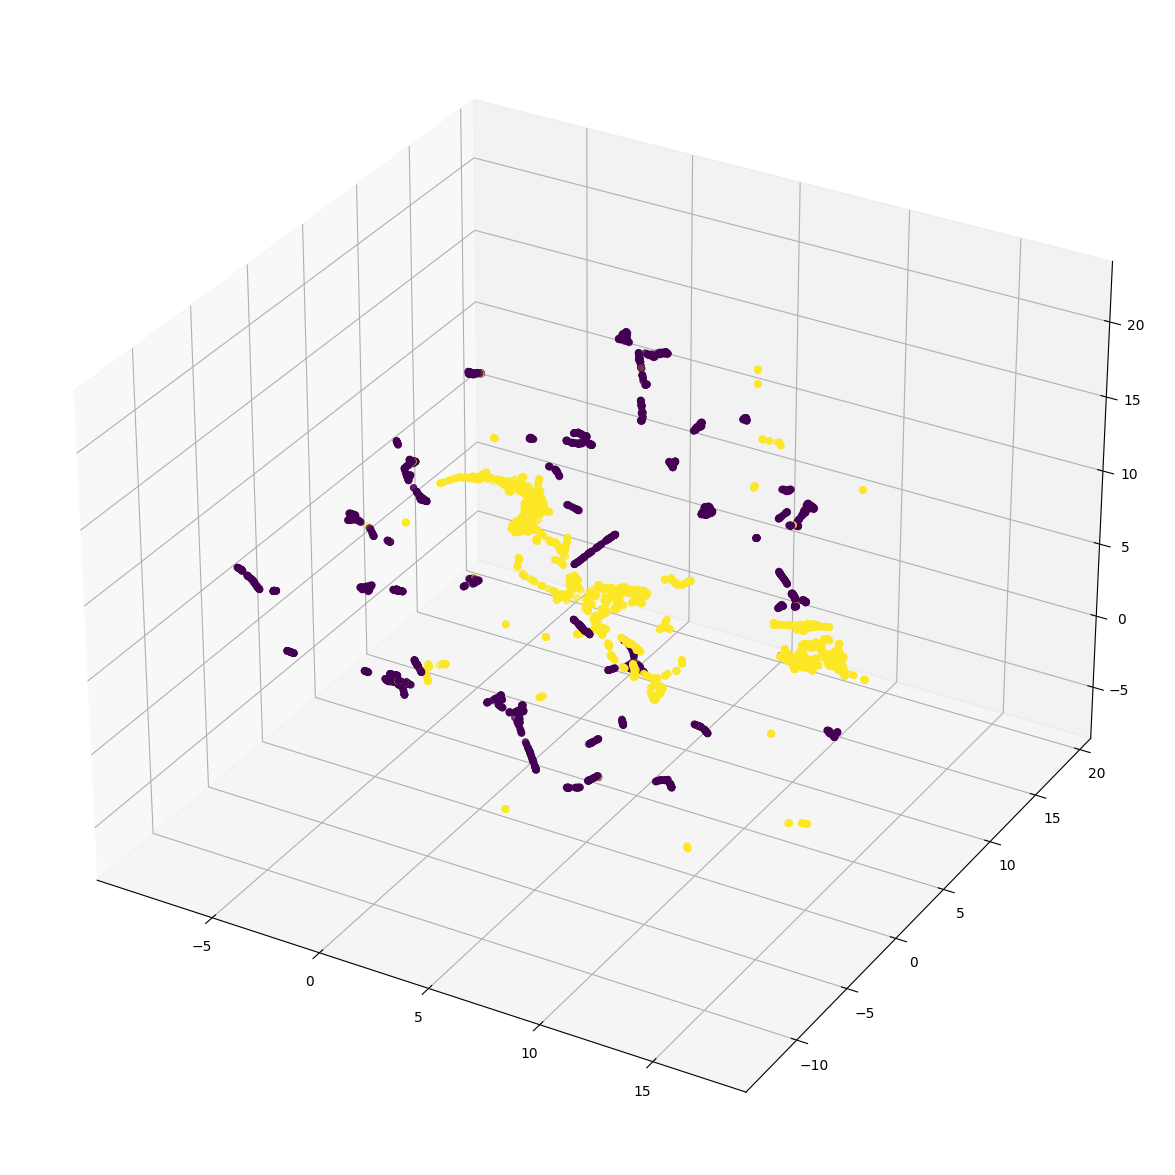

In [246]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(df_result_umapM[2],df_result_umapM[1],df_result_umapM[0], c=df_result_umapM['isTarget'])
plt.show()

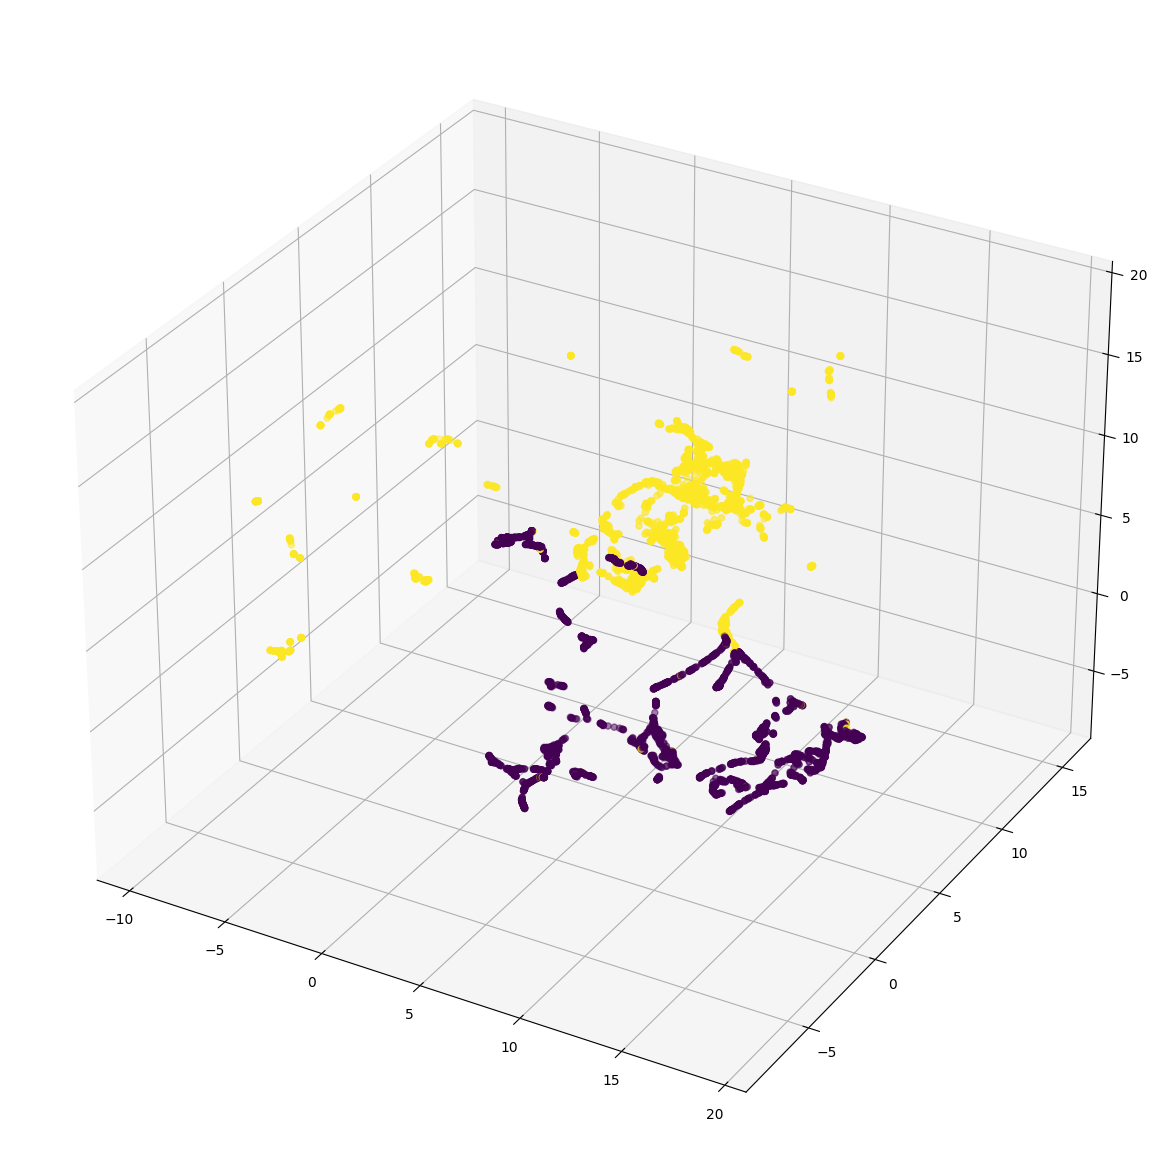

In [247]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(df_result_umapS[2],df_result_umapS[1],df_result_umapS[0], c=df_result_umapS['isTarget'])
plt.show()

In [260]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




# Create a list to store the silhouette scores for each value of n_clusters
silhouette_scores_results = []

# For each value of n_clusters, fit a KMeans model and calculate the silhouette score
k2means = KMeans(n_clusters=2)
k2means.fit(df_result_umapM_drop)
cluster_labels = k2means.fit_predict(df_result_umapM_drop)
silhouette_scores_results.append(silhouette_score(df_result_umapM_drop, k2means.labels_))

# Find the value of n_clusters that maximizes the silhouette score
best_n_clusters = np.argmax(silhouette_scores_results)


# Print the silhouette score for the best value of n_clusters
print("Silhouette score for the best value of n_clusters:", silhouette_scores_results[best_n_clusters])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for the best value of n_clusters: 0.25743154


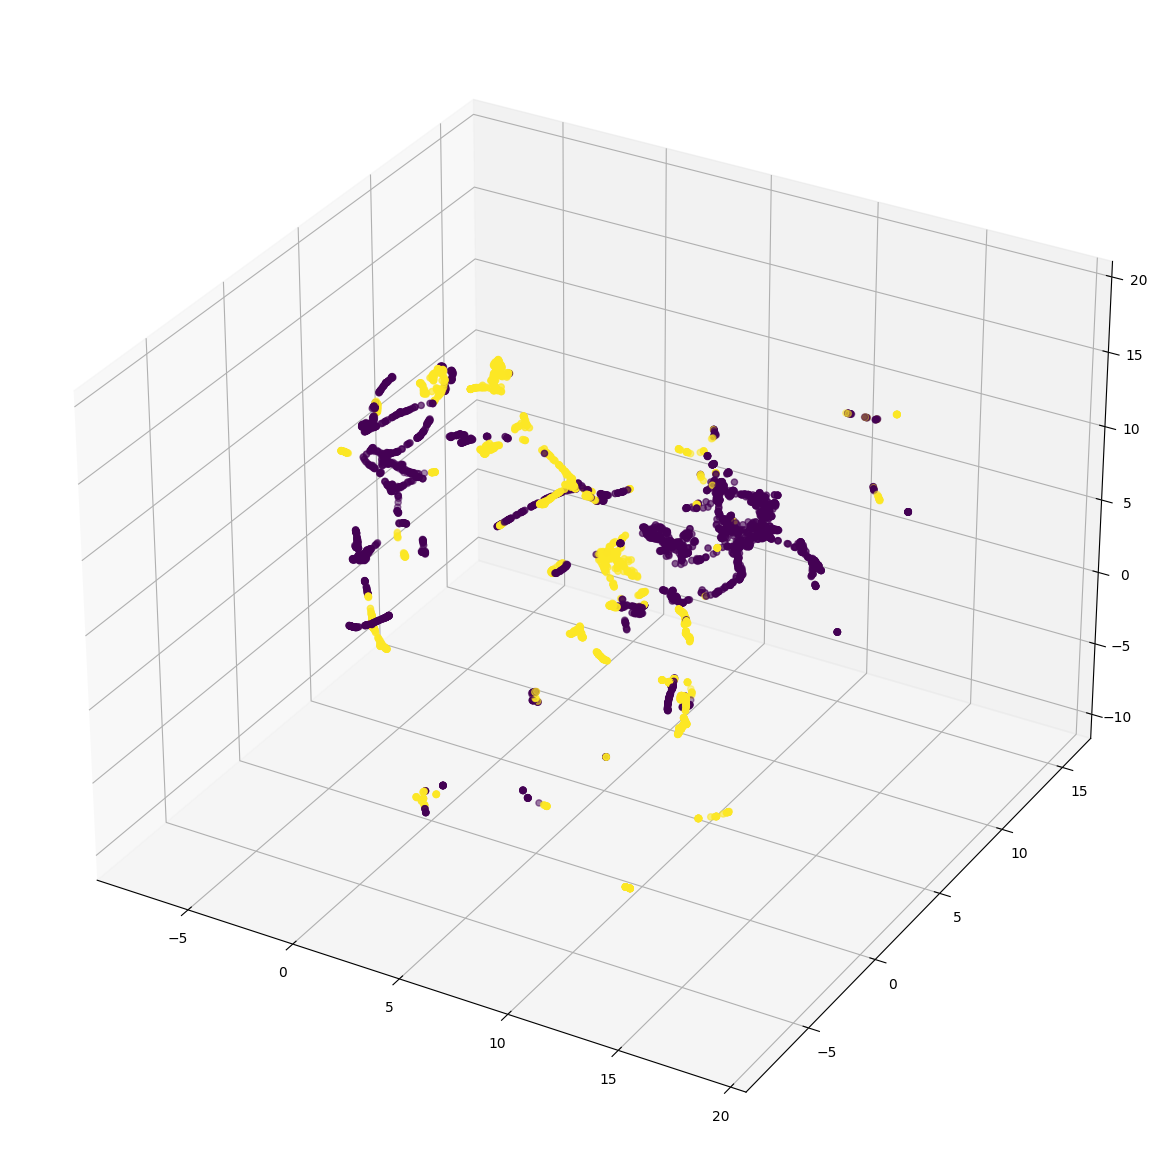

In [261]:

plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(df_result_umapS[0],df_result_umapS[1],df_result_umapS[2], c= cluster_labels)
plt.show()

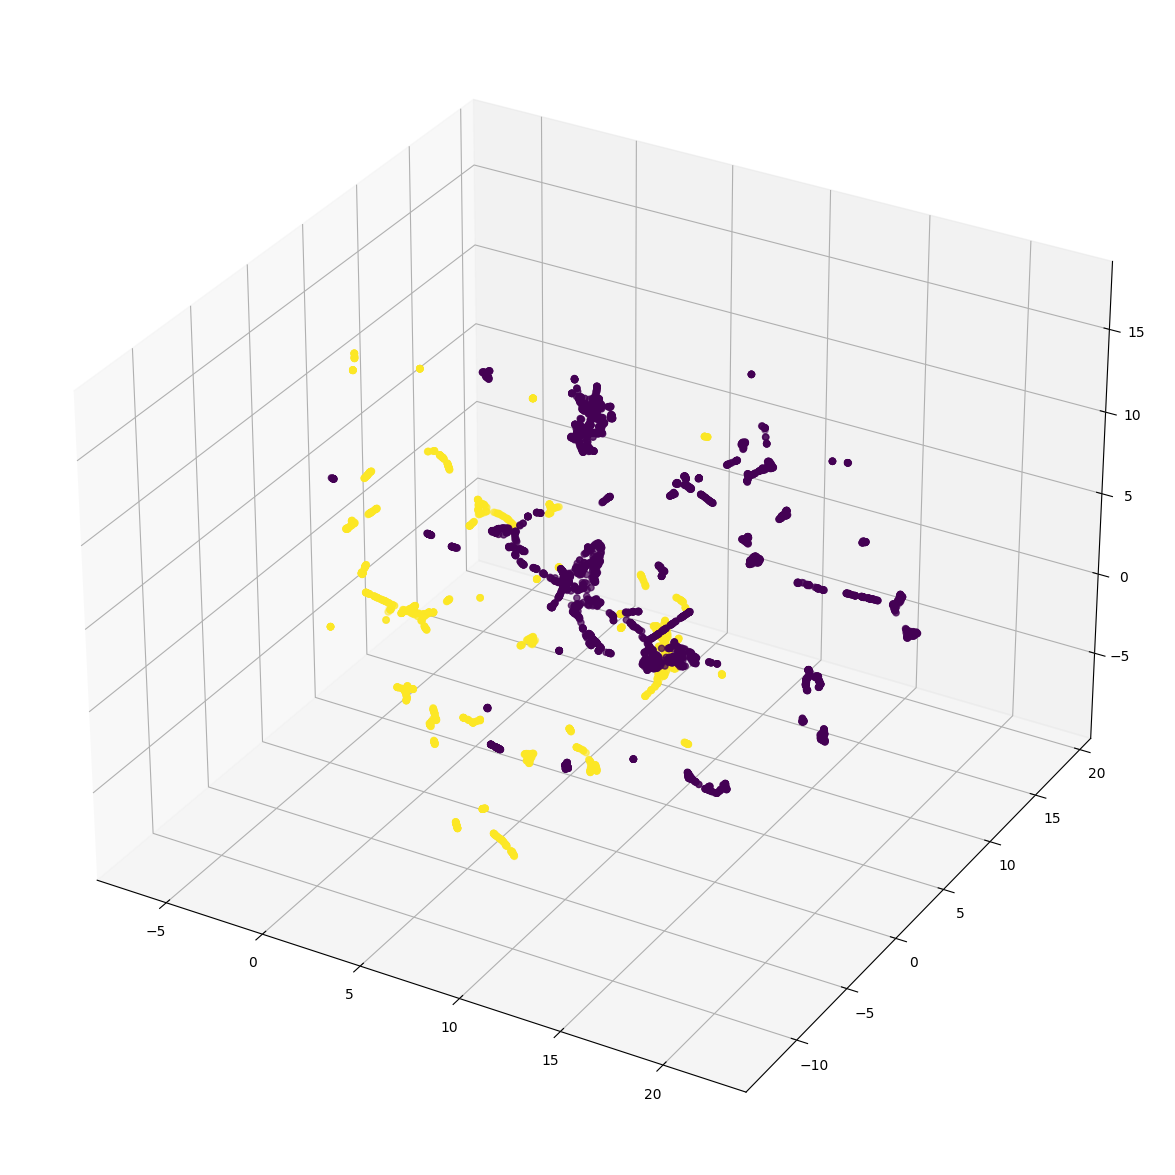

In [262]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(df_result_umapM[0],df_result_umapM[1],df_result_umapM[2], c= cluster_labels)
plt.show()

do a logistic regression

## Delete

 Let's do another round of PCA except this time we will filter the data from 1999 - 2017. Since we will want to predict for the latest data which is up to 2019 we will section this out

In [ ]:
# master data subset 1999-2016

master_data_1999_2016 = master_data[master_data['Year'].between(1999, 2016)]


Since all rows that we've filtered have a target let's add a Target column which we will use to determine if a target is in that county or not. We will use 1 for Yes and 0 for no

In [ ]:
master_data_1999_2016['Target'] = 1

Now let's remove all Target information so that we can make groupings based on the demographic data and not just on the fact that there are targets

In [ ]:
# prompt: drop list of columns from master data 1999-2017

master_data_1999_2016 = master_data_1999_2016.drop(columns = ['Address.AddressLine1', 'Address.City', 'COUNTYNAME_x',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode', 'Remodeled',
       '"DAmico & Sons Italian Kitchen"', '& Spirits Available', 'Accepts WIC',
       'Bakery', 'Beauty Concierge', 'Beer', 'Beer Available', 'CVS pharmacy',
       'Cafe-Pizza', 'Café', 'Chobani Cafe',
       'Clinic care by Kaiser Permanente', 'Deli', 'Drive Up', 'Fresh Grocery',
       'In-Store Apple Store', 'MinuteClinic', 'Mobile Kiosk', 'Optical',
       'Photo Lab', 'Pizza Hut Salads and Snacks', 'Starbucks', 'Sun Boutique',
       'Super Target', 'Which Wich Superior Sandwiches', 'Wine',
       'Wine & Beer Available', 'Wine Available', 'ZIP', 'LastMilestoneEvent'], axis=1)


In [ ]:
master_data_1999_2016.head()

Now let's do the same for data past 2017 we will also add a isTarget column but this time we will use 0

In [ ]:
master_data_2017_2019 = master_data[master_data['Year'].between(2017, 2019)]


In [ ]:
master_data_2017_2019['Target'] = 0

Let's remove the Target information now

In [ ]:
master_data_2017_2019 = master_data_2017_2019.drop(columns = ['Address.AddressLine1', 'Address.City', 'COUNTYNAME_x',
       'Address.FormattedAddress', 'Address.Latitude', 'Address.Longitude',
       'Address.PostalCode', 'Address.Subdivision',
       'LocationMilestones.LastRemodelDate', 'LocationMilestones.OpenDate',
       'Name', 'Store.StoreDistrictID', 'Store.StoreGroupID',
       'Store.StoreRegionID', 'SubTypeDescription', 'TypeCode', 'Remodeled',
       '"DAmico & Sons Italian Kitchen"', '& Spirits Available', 'Accepts WIC',
       'Bakery', 'Beauty Concierge', 'Beer', 'Beer Available', 'CVS pharmacy',
       'Cafe-Pizza', 'Café', 'Chobani Cafe',
       'Clinic care by Kaiser Permanente', 'Deli', 'Drive Up', 'Fresh Grocery',
       'In-Store Apple Store', 'MinuteClinic', 'Mobile Kiosk', 'Optical',
       'Photo Lab', 'Pizza Hut Salads and Snacks', 'Starbucks', 'Sun Boutique',
       'Super Target', 'Which Wich Superior Sandwiches', 'Wine',
       'Wine & Beer Available', 'Wine Available', 'ZIP', 'LastMilestoneEvent'], axis=1)


## Clustering

In [ ]:


numeric_master_data_1999_2016 = master_data_1999_2016.select_dtypes(include=['int64', 'float64'])


In [ ]:


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create a range of possible values for the number of clusters
n_clusters = range(2, 10)

# Create a list to store the silhouette scores for each value of n_clusters
silhouette_scores = []

# For each value of n_clusters, fit a KMeans model and calculate the silhouette score
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(numeric_master_data_1999_2016)
    silhouette_scores.append(silhouette_score(numeric_master_data_1999_2016, kmeans.labels_))

# Find the value of n_clusters that maximizes the silhouette score
best_n_clusters = np.argmax(silhouette_scores) + 2

# Fit a KMeans model to the data using the best value of n_clusters
kmeans = KMeans(n_clusters=best_n_clusters + 1)
kmeans.fit(numeric_master_data_1999_2016)

# Print the silhouette score for the best value of n_clusters
print("Silhouette score for the best value of n_clusters:", silhouette_scores[best_n_clusters])

This silhouette score is pretty great it means that our clusters are well defined. Let's visualize this

We want to find the value of K that gives diminishing returns for inertia AND maximizes silhouette score

In [ ]:
ks = np.arange(2,20,1)

inertia = [] #inertia is the sum of the squared distance between each point and its centroid
sil_scores = [] #Silhouette score is metric of inter vs intra cluster distance

for k in ks: #looping through different numbers of clusters
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(numeric_master_data)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(numeric_master_data, kmeans.labels_))


In [ ]:
#plot the inertia to find best value of K

plt.figure()
plt.plot(ks, inertia)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia vs Values of K')
plt.show()

In [ ]:
#plot the silhouette scores as well

plt.figure()
plt.plot(ks, sil_scores)
plt.axvline(4, color='red') #drawing a vertical line at 4
plt.xlabel('Values of K')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores vs Values of K for KMEANS')
plt.show()

In [ ]:
#let's fit our final and most optimal clustering to our data

final_kmeans = KMeans(n_clusters=4)
final_kmeans.fit(numeric_master_data)

In [ ]:
#creating a new column in our dataframe for the cluster labels
numeric_master_data['kmeans'] = final_kmeans.labels_

In [ ]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(numeric_master_data[2], numeric_master_data[1], numeric_master_data[0], c=cluster_df['kmeans'])  #color according to the label
plt.title('3D Representation of UMAP Standard Scaled Dimentionality Reduction with K=4 Kmeans Clustering')
#plt.legend()
plt.show()

## Decision Tree

In [ ]:
# prompt: create a decision tree for master data 1999-2016

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numeric_master_data_1999_2016, master_data_1999_2016['Target'], test_size=0.25)

# Create a decision tree classifier
classifier = DecisionTreeClassifier()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)


## Model Evaluation

Let's also check the precision and recall

In [ ]:

import sklearn.metrics

precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

# Print the precision and recall
print("Precision:", precision)
print("Recall:", recall)


## Parameter Optimization

## Conclusion